In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [132]:
import os
from tqdm import tqdm
from glob import glob
import pickle
from collections import defaultdict
import numpy_indexed as npi

import skimage
import numpy as np
import pandas as pd
import scipy
import cv2

In [100]:
import sys

sys.path.append('..')
from src.configs import config
from src.utils import visualisation
from src.utils import dataset as ds

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
path = os.path.join(config.PATHS['DATA'], 'findimagedupes.full.log')

warnings = list()
duplicates = list()
with open(path) as fd:
    for line in fd:
        if 'Warning' in line:
            line = line.split('/')[-1]
            line = line.split(')')[0]
            line = line.split('\n')[0]
            line = '.'.join(line.split('.')[:-1])
            warnings.append(line)
        else:
            line = line.split('\n')[0]
            line = line.split(' ')
            duplicates.append(line)

In [5]:
np.array(warnings[:10])

array([], dtype=float64)

In [9]:
idx, i = 0, 0
idxs = [i for i, dupl in enumerate(duplicates) if sum(['test' in el for el in dupl])]
externals = [el for dupl in duplicates for el in dupl if 'external' in el]
externals = [os.path.basename(el)[:-4] for el in externals]

In [10]:
duplicates[idx]

['/home/vessemer/Projects/HPA/data/external_data_rgb/34873_752_D3_2_blue_red_green.png',
 '/home/vessemer/Projects/HPA/data/train_full_size_rgb/77868626-bb9b-11e8-b2b9-ac1f6b6435d0_blue_red_green.png']

/home/vessemer/Projects/HPA/data/test_full_size_rgb/74993d6e-bad8-11e8-b2b9-ac1f6b6435d0_blue_red_green.png
/home/vessemer/Projects/HPA/data/external_data_rgb/56856_1050_F6_6_blue_red_green.png


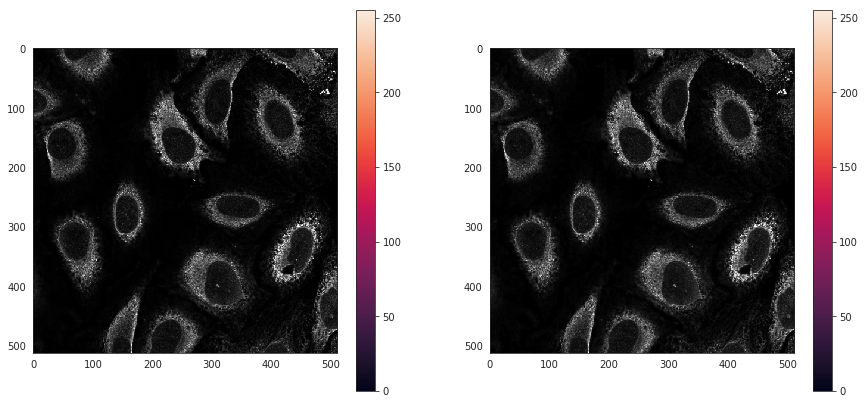

In [88]:
i += 1
idx = idxs[i]
# idx += 1
image_1 = cv2.imread(duplicates[idx][0].replace('test_full_size_rgb', 'test_shrinked').replace('external_data_rgb', 'train_shrinked').replace('blue_red_green', 'yellow'))
image_2 = cv2.imread(duplicates[idx][1].replace('test_full_size_rgb', 'test_shrinked').replace('external_data_rgb', 'train_shrinked').replace('blue_red_green', 'yellow'))

print('\n'.join(duplicates[idx]))

plt.figure(figsize=(15, 7))
plt.subplot(121)
a = plt.imshow(image_1)
plt.colorbar(a)
plt.subplot(122)
a = plt.imshow(image_2)
plt.colorbar(a)
plt.show()

for path in duplicates[idx]:
    if 'train' in path:
        key = os.path.basename(path).split('_')[0]
        targets = config.labels.query('Id==@key').Target
        print(targets)
        names = [
            config.label_names[el] 
            for el in targets.values[0]
        ]
        print(names)

In [30]:
template = '../data/models/resnet50_pure'
predicts = list()
keys = list()
for fold in range(config.PARAMS['NB_FOLDS']):
    predicts.append(np.load(os.path.join(template, 'test_predicts_old_fold_{}.npy'.format(fold))))
    key =pd.read_csv(os.path.join(template, 'test_keys_old_fold_{}'.format(fold)))
    keys.append(key)
    

In [106]:
errors = list()
leaks = list()

for idx in idxs:
    dupl = duplicates[idx]
    queries = list()
    pids = list()
    for d in dupl:
        pid = '.'.join(os.path.basename(d).split('_blue_red_green.')[:-1])
        queries.append(config.labels.query('Id==@pid'))
        if 'test' in d:
            pids.append(pid)

    queries = pd.concat(queries)
    if len(queries):
        queries = queries[config.label_names_list].values
        if np.equal(queries.any(axis=0), queries.all(axis=0)).all():
            for pid in pids:
                leaks.append((pid, *queries[0]))
        else:
            errors.append((dupl, queries))

leaks = pd.DataFrame(leaks, columns=['Id'] + config.label_names_list)

In [107]:
leaks.head()

,Id,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,74993d6e-bad8-11e8-b2b9-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5cf25ab2-bacc-11e8-b2b8-ac1f6b6435d0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,d57ef6f6-bad2-11e8-b2b8-ac1f6b6435d0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,8316d286-bad6-11e8-b2b9-ac1f6b6435d0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,77161884-bad6-11e8-b2b9-ac1f6b6435d0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [151]:
test_df = pd.read_csv(os.path.join(config.PATHS['CSV'], 'sample_submission.csv'))
for name in config.label_names_list + ['Predicted', 'Target']:
    test_df[name] = 0

test_df_orig = pd.read_csv('simple.csv')

In [152]:
folds = ds.get_folds(config.PARAMS['NB_FOLDS'])
_, valid_dataset = ds.get_datasets(folds, fold)

test_dataset = ds.ProteinDataset(
    test_df, 
    config.PATHS['TEST'], 
    config.label_names_list, 
    augmentations=None
)

In [147]:
index = test_df.loc[test_df.Id.isin(leaks.Id.values), 'Id'].index

selected = leaks[config.label_names_list].values.astype(np.bool_)
idxs = np.array(np.where(selected))
groups = npi.group_by(idxs[0]).split(idxs[1])

In [149]:
for idx, el in tqdm(zip(index, groups)):
    # test_datagen.dataset.labels.loc[idx, [label_names[e] for e in el]] = predictions[idx, el]
    target = ' '.join(['%d' % e for e in el])
    if test_df_orig.loc[idx, 'Predicted'] != target:
        print(test_df_orig.loc[idx, 'Predicted'], '|', target)
    test_df_orig.loc[idx, 'Predicted'] = target

104it [00:00, 657.23it/s]

4 | 16
16 | 0 7
0 2 | 7
4 | 6 21
15 25 | 16
0 | 2 4
14 16 25 | 4
0 16 | 0 16 17
0 | 0 16
0 16 17 18 | 0 16 25
5 | 16 23
23 | 16 25
0 16 | 16 17 23
0 25 | 14
2 | 4
5 16 | 12
16 21 | 25
16 17 25 | 0
12 | 0 21
14 | 0
4 26 | 14 16
16 | 0 16 25
0 16 | 5
0 2 | 12
4 | 0 16 25
25 | 0 16
16 21 22 25 | 4
16 17 | 4
14 16 | 15 25
0 7 | 0 16 17 18
14 25 | 4 21 26
2 7 | 4
0 14 16 25 | 2
16 23 | 0 16
0 16 25 | 14 16
2 4 21 | 0 16
0 | 16 22 25
6 | 14 16 25
0 7 | 0 21
0 14 16 17 18 25 | 16 25
2 25 | 13
21 25 | 7
25 | 18 25
25 | 14 16
0 18 19 21 25 | 16 25
21 25 | 5
13 | 0 16 17 18
14 | 0
14 16 17 | 17 25
0 16 | 16 17 23
5 | 16
2 16 | 0
15 25 | 0 16
0 | 14 16 19
0 14 16 25 | 2 16
0 16 21 | 1
0 | 0 25
16 25 | 23
0 16 | 2 16
12 | 15 25
14 16 17 | 7 17
2 4 | 0 21
4 | 0 16
0 21 25 | 17
0 14 | 13
23 | 16 21
25 | 0 5
0 | 19
0 21 25 | 23
5 | 4
2 16 25 | 14 16
25 | 14
0 16 | 17
13 25 | 19
17 23 | 14
14 | 4 17 21
16 25 | 0 16 25
14 16 | 21 25
23 | 21 25
4 | 21 25
19 | 4 25
0 16 | 16
0 | 2 17
0 16 | 14 16
0 25 | 

In [150]:
df = test_df_orig[['Id', 'Predicted']]
df.to_csv('simple_leaks.csv', index=False)

# External Dataset Processing

In [5]:
csv_path = os.path.join(config.PATHS['CSV'], 'external_full.csv')
df = pd.read_csv(csv_path)
df.head()

,verification,url,labels,xml_id
0,enhanced,http://v18.proteinatlas.org/images/49886/824_H...,nucleoplasm,ENSG00000168884
1,enhanced,http://v18.proteinatlas.org/images/49886/824_H...,nucleoplasm,ENSG00000168884
2,enhanced,http://v18.proteinatlas.org/images/49886/978_H...,nucleus|cytosol,ENSG00000168884
3,enhanced,http://v18.proteinatlas.org/images/49886/978_H...,nucleus|cytosol,ENSG00000168884
4,enhanced,http://v18.proteinatlas.org/images/49886/884_H...,cytosol,ENSG00000168884


In [6]:
df.url.values

array(['http://v18.proteinatlas.org/images/49886/824_H10_1_{}.jpg',
       'http://v18.proteinatlas.org/images/49886/824_H10_2_{}.jpg',
       'http://v18.proteinatlas.org/images/49886/978_H10_1_{}.jpg', ...,
       'http://v18.proteinatlas.org/images/67699/1487_G11_5_{}.jpg',
       'http://v18.proteinatlas.org/images/67699/1398_C9_1_{}.jpg',
       'http://v18.proteinatlas.org/images/67699/1398_C9_2_{}.jpg'],
      dtype=object)

In [17]:
key = '27231_1161_C8_1_blue_red_green'
df.query('Id==@key').url.values

array(['http://v18.proteinatlas.org/images/27231/1161_C8_1_{}.jpg'],
      dtype=object)

In [12]:
df['Id'] = df.url.apply(lambda x: '.'.join('_'.join(x.split('/')[-2:]).split('.')[:-1]).format('blue_red_green'))
df['paths'] = df.Id.apply(lambda x: os.path.join(config.PATHS['DATA'], 'external_data_rgb', '.'.join([x, 'png'])))

df.head()

,verification,url,labels,xml_id,Id,paths
0,enhanced,http://v18.proteinatlas.org/images/49886/824_H...,nucleoplasm,ENSG00000168884,49886_824_H10_1_blue_red_green,../data/external_data_rgb/49886_824_H10_1_blue...
1,enhanced,http://v18.proteinatlas.org/images/49886/824_H...,nucleoplasm,ENSG00000168884,49886_824_H10_2_blue_red_green,../data/external_data_rgb/49886_824_H10_2_blue...
2,enhanced,http://v18.proteinatlas.org/images/49886/978_H...,nucleus|cytosol,ENSG00000168884,49886_978_H10_1_blue_red_green,../data/external_data_rgb/49886_978_H10_1_blue...
3,enhanced,http://v18.proteinatlas.org/images/49886/978_H...,nucleus|cytosol,ENSG00000168884,49886_978_H10_2_blue_red_green,../data/external_data_rgb/49886_978_H10_2_blue...
4,enhanced,http://v18.proteinatlas.org/images/49886/884_H...,cytosol,ENSG00000168884,49886_884_H10_1_blue_red_green,../data/external_data_rgb/49886_884_H10_1_blue...


In [9]:
unlabeled = df.Id[df.labels.isna()].values
len([el for el in externals if el in unlabeled]), unlabeled.shape

(208, (9819,))

In [10]:
df.dropna(inplace=True)
df.shape

(75530, 6)

In [11]:
reverse_labels = { k.lower(): v for k, v in config.reverse_train_labels.items() }

In [12]:
df['Target'] = df.labels.apply(
    lambda x: [
        reverse_labels[el] for el in x.split('|')
        if el in reverse_labels.keys()
    ])
df['Target'] = df.Target.apply(lambda x: x if len(x) else None)
df['externals'] = df.labels.apply(
    lambda x: [
        el for el in x.split('|')
        if el not in reverse_labels.keys()
    ])

# target = [el for target in df.Target.values for el in target]
# target_bincount = np.bincount(target)
# { v: target_bincount[k] for k, v in config.label_names.items() }
df.head()

,verification,url,labels,xml_id,Id,paths,Target,externals
0,enhanced,http://v18.proteinatlas.org/images/49886/824_H...,nucleoplasm,ENSG00000168884,49886_824_H10_1_blue_red_green,../data/external_data_rgb/49886_824_H10_1_blue...,[0],[]
1,enhanced,http://v18.proteinatlas.org/images/49886/824_H...,nucleoplasm,ENSG00000168884,49886_824_H10_2_blue_red_green,../data/external_data_rgb/49886_824_H10_2_blue...,[0],[]
2,enhanced,http://v18.proteinatlas.org/images/49886/978_H...,nucleus|cytosol,ENSG00000168884,49886_978_H10_1_blue_red_green,../data/external_data_rgb/49886_978_H10_1_blue...,[25],[nucleus]
3,enhanced,http://v18.proteinatlas.org/images/49886/978_H...,nucleus|cytosol,ENSG00000168884,49886_978_H10_2_blue_red_green,../data/external_data_rgb/49886_978_H10_2_blue...,[25],[nucleus]
4,enhanced,http://v18.proteinatlas.org/images/49886/884_H...,cytosol,ENSG00000168884,49886_884_H10_1_blue_red_green,../data/external_data_rgb/49886_884_H10_1_blue...,[25],[]


In [13]:
target = pd.Series([el for target in df.externals.values for el in target])
target.value_counts()

nucleus            9175
vesicles           9054
midbody             100
midbody ring         51
cleavage furrow       8
dtype: int64

In [ ]:
# df[df.verification == 'uncertain'].labels.value_counts()

In [14]:
df = df[~df.Target.isna()]
df = df[df.verification != 'uncertain']
df.head()

,verification,url,labels,xml_id,Id,paths,Target,externals
0,enhanced,http://v18.proteinatlas.org/images/49886/824_H...,nucleoplasm,ENSG00000168884,49886_824_H10_1_blue_red_green,../data/external_data_rgb/49886_824_H10_1_blue...,[0],[]
1,enhanced,http://v18.proteinatlas.org/images/49886/824_H...,nucleoplasm,ENSG00000168884,49886_824_H10_2_blue_red_green,../data/external_data_rgb/49886_824_H10_2_blue...,[0],[]
2,enhanced,http://v18.proteinatlas.org/images/49886/978_H...,nucleus|cytosol,ENSG00000168884,49886_978_H10_1_blue_red_green,../data/external_data_rgb/49886_978_H10_1_blue...,[25],[nucleus]
3,enhanced,http://v18.proteinatlas.org/images/49886/978_H...,nucleus|cytosol,ENSG00000168884,49886_978_H10_2_blue_red_green,../data/external_data_rgb/49886_978_H10_2_blue...,[25],[nucleus]
4,enhanced,http://v18.proteinatlas.org/images/49886/884_H...,cytosol,ENSG00000168884,49886_884_H10_1_blue_red_green,../data/external_data_rgb/49886_884_H10_1_blue...,[25],[]


In [20]:
config.labels.head(3)

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
def fill_targets(row):
    for num in row.Target:
        name = config.label_names[int(num)]
        row.loc[name] = 1
    return row


In [22]:
# Dataset preparation
for key in config.label_names.keys():
    df[config.label_names[key]] = 0

df = df.apply(fill_targets, axis=1)
df.head()

,verification,url,labels,xml_id,Id,paths,Target,externals,Nucleoplasm,Nuclear membrane,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,enhanced,http://v18.proteinatlas.org/images/49886/824_H...,nucleoplasm,ENSG00000168884,49886_824_H10_1_blue_red_green,../data/external_data_rgb/49886_824_H10_1_blue...,[0],[],1,0,...,0,0,0,0,0,0,0,0,0,0
1,enhanced,http://v18.proteinatlas.org/images/49886/824_H...,nucleoplasm,ENSG00000168884,49886_824_H10_2_blue_red_green,../data/external_data_rgb/49886_824_H10_2_blue...,[0],[],1,0,...,0,0,0,0,0,0,0,0,0,0
2,enhanced,http://v18.proteinatlas.org/images/49886/978_H...,nucleus|cytosol,ENSG00000168884,49886_978_H10_1_blue_red_green,../data/external_data_rgb/49886_978_H10_1_blue...,[25],[nucleus],0,0,...,0,0,0,0,0,0,0,1,0,0
3,enhanced,http://v18.proteinatlas.org/images/49886/978_H...,nucleus|cytosol,ENSG00000168884,49886_978_H10_2_blue_red_green,../data/external_data_rgb/49886_978_H10_2_blue...,[25],[nucleus],0,0,...,0,0,0,0,0,0,0,1,0,0
4,enhanced,http://v18.proteinatlas.org/images/49886/884_H...,cytosol,ENSG00000168884,49886_884_H10_1_blue_red_green,../data/external_data_rgb/49886_884_H10_1_blue...,[25],[],0,0,...,0,0,0,0,0,0,0,1,0,0


In [23]:
external_csv = os.path.join(config.PATHS['CSV'], 'prepared_external.csv')
df['Id'] = df.Id.apply(lambda x: x.replace('_blue_red_green', ''))
df['Target'] = df.Target.apply(lambda x: " ".join(map(str, x)))
df[config.labels.columns].to_csv(external_csv, index=False)
pd.concat([config.labels, pd.read_csv(external_csv)]).shape

(163426, 30)

In [24]:
config.labels.tail(3)

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
95304,67699_1487_G11_5,[0],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95305,67699_1398_C9_1,[0],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
95306,67699_1398_C9_2,[0],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Clean files from warning

In [84]:
for fname in tqdm(warnings):
    path = os.path.join(config.PATHS['EXT'], '.'.join([fname, 'png']))
    if os.path.isfile(path):
        os.remove(path)
    path = 'yellow'.join(path.split('blue_red_green'))
    if os.path.isfile(path):
        os.remove(path)


100%|██████████| 4643/4643 [00:00<00:00, 12384.01it/s]


In [232]:
template = '../data/train_shrinked/*.png'

corrupted = list()
for path in tqdm(glob(template)):
    image = cv2.imread(path)
    if image is None:
        corrupted.append(path)
        print(path)

 74%|███████▍  | 143114/193362 [28:52<10:08, 82.62it/s]

../data/train_shrinked/0fedc5f2-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9116378a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a480418c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143131/193362 [28:52<10:08, 82.61it/s]

../data/train_shrinked/791a4962-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b9f67ab2-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c08b1f4a-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/715b92c0-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143161/193362 [28:52<10:07, 82.62it/s]

../data/train_shrinked/1694b480-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7344648-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/752a42da-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/04db2e42-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143193/193362 [28:53<10:07, 82.62it/s]

../data/train_shrinked/76633bc4-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fdf21ee4-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b38e2f54-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eafc778e-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143237/193362 [28:53<10:06, 82.62it/s]

../data/train_shrinked/38529268-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/59540c28-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4015f9fc-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143259/193362 [28:53<10:06, 82.62it/s]

../data/train_shrinked/19de3ac2-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f1df06b8-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5a49542c-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e5a49a0e-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8654c184-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/98fd9c5a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6eea33dc-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ee3251f6-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143294/193362 [28:54<10:05, 82.63it/s]

../data/train_shrinked/6908ed24-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/1f10f862-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143314/193362 [28:54<10:05, 82.63it/s]

../data/train_shrinked/b8a6cf22-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc1168e4-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143334/193362 [28:54<10:05, 82.63it/s]

../data/train_shrinked/dea19dc6-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9936a972-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ff326f94-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b12b316e-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143354/193362 [28:54<10:05, 82.63it/s]

../data/train_shrinked/71c8eb6e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/32af6c98-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7da41ac6-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bbb7d938-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143376/193362 [28:55<10:04, 82.63it/s]

../data/train_shrinked/10c9c102-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6567e5e8-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a9506a28-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143397/193362 [28:55<10:04, 82.63it/s]

../data/train_shrinked/b07bc1c4-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eef705fa-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143416/193362 [28:55<10:04, 82.63it/s]

../data/train_shrinked/e2581f78-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e73812ee-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/375fb9e6-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62c829c8-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143435/193362 [28:55<10:04, 82.63it/s]

../data/train_shrinked/3da31472-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/74da8684-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143464/193362 [28:56<10:03, 82.63it/s]

../data/train_shrinked/c8d3806c-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/06f6d9a2-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8658cf48-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/779060d2-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8cf867ce-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143487/193362 [28:56<10:03, 82.64it/s]

../data/train_shrinked/a2ec1fd4-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/53a73e54-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/73f49160-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ea3bcaf6-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1b034336-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c84a6ae-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c8ac47b6-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143510/193362 [28:56<10:03, 82.64it/s]

../data/train_shrinked/101e365e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e4ddb3ca-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d838acd4-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c02f950-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/82ee2572-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143530/193362 [28:56<10:03, 82.64it/s]

../data/train_shrinked/004b47de-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143567/193362 [28:57<10:02, 82.64it/s]

../data/train_shrinked/54fce3d4-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d7d92a0-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1f91d9d2-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e0ed3f22-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143590/193362 [28:57<10:02, 82.64it/s]

../data/train_shrinked/8acb4a78-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0d6ea74-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/14cb7a82-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c26d7324-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b6cd02c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143612/193362 [28:57<10:01, 82.64it/s]

../data/train_shrinked/60c3634a-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/39283e74-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c9618938-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143642/193362 [28:58<10:01, 82.64it/s]

../data/train_shrinked/872e3950-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e43dee82-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b27d1f6e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3ad2789a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143663/193362 [28:58<10:01, 82.64it/s]

../data/train_shrinked/78b00d72-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c9883860-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143693/193362 [28:58<10:00, 82.64it/s]

../data/train_shrinked/77fb5102-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/69bbd2b2-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5113cd86-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/93da542a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143724/193362 [28:59<10:00, 82.65it/s]

../data/train_shrinked/02e42082-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143745/193362 [28:59<10:00, 82.65it/s]

../data/train_shrinked/8f19e0f8-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/93df4b96-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0b728cca-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143766/193362 [28:59<10:00, 82.65it/s]

../data/train_shrinked/d279ab52-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/31897ab2-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9bc257f4-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0af9dafc-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143809/193362 [28:59<09:59, 82.65it/s]

../data/train_shrinked/ff9f759e-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bfa5bec0-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/945ce356-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c086d42-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/170a080a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143835/193362 [29:00<09:59, 82.66it/s]

../data/train_shrinked/d3998a48-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d00aac52-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5d9e4824-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c2c546c8-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/902f93c4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143849/193362 [29:00<09:58, 82.66it/s]

../data/train_shrinked/7f837cdc-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/25cedffe-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b8ddd08-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6df98ce-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143882/193362 [29:00<09:58, 82.66it/s]

../data/train_shrinked/fc9ba76e-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/15029c6e-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b6fbeefa-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143903/193362 [29:00<09:58, 82.66it/s]

../data/train_shrinked/0c7e4d56-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ed91786-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4014da08-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6b23a7c6-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab25f400-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143924/193362 [29:01<09:58, 82.66it/s]

../data/train_shrinked/112efbea-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/49d1121c-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3e1d10dc-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143953/193362 [29:01<09:57, 82.66it/s]

../data/train_shrinked/c98a51f4-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a8ffd69e-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1d25dbd8-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143973/193362 [29:01<09:57, 82.66it/s]

../data/train_shrinked/0ab5c4ca-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/055bd1a4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5dff4194-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d223fd4-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 143993/193362 [29:01<09:57, 82.66it/s]

../data/train_shrinked/502c1736-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 74%|███████▍  | 144035/193362 [29:02<09:56, 82.66it/s]

../data/train_shrinked/1b6d317c-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1895bdde-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fcbd6e02-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 74%|███████▍  | 144054/193362 [29:02<09:56, 82.66it/s]

../data/train_shrinked/bc17b79a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0a3eb75e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/93a4370c-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e339fce-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144085/193362 [29:03<09:56, 82.66it/s]

../data/train_shrinked/bb2f40d8-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba0b7ef6-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/16c60ce4-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5a0c2bfc-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144110/193362 [29:03<09:55, 82.66it/s]

../data/train_shrinked/94b41236-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a44004ca-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab654f6e-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/311a9862-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7f807998-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144131/193362 [29:03<09:55, 82.66it/s]

../data/train_shrinked/4d18f6ec-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1d21966a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144152/193362 [29:03<09:55, 82.66it/s]

../data/train_shrinked/eadbcb70-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f5c09c38-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144182/193362 [29:04<09:54, 82.67it/s]

../data/train_shrinked/3ba28bd8-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/56263a44-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c054a3c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9a6b8954-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144213/193362 [29:04<09:54, 82.67it/s]

../data/train_shrinked/98be9d36-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f572bc4e-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a249c85a-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ed69b94e-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e0a6e64-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/06a3e6b0-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e01abe32-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144229/193362 [29:04<09:54, 82.67it/s]

../data/train_shrinked/7b713070-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dcbf5842-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cae81418-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8fcf55a-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b8734f0-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1d3721d8-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144264/193362 [29:04<09:53, 82.67it/s]

../data/train_shrinked/b1396638-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/487cdd18-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b6d3568-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144286/193362 [29:05<09:53, 82.68it/s]

../data/train_shrinked/e46f5238-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/11db3844-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bcf44906-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b5f3ebfc-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/079f3248-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/117a5b76-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144308/193362 [29:05<09:53, 82.68it/s]

../data/train_shrinked/3c0151fa-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/10ab5254-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f560dd88-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d1a4e36-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144330/193362 [29:05<09:53, 82.68it/s]

../data/train_shrinked/ead3c6ca-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a26ecafc-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2df165b0-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/41e3ae98-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144363/193362 [29:06<09:52, 82.68it/s]

../data/train_shrinked/dfa4735c-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/15eeceae-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c9634b76-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144396/193362 [29:06<09:52, 82.68it/s]

../data/train_shrinked/02b8f364-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/349eb3d4-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2298264c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b3017f98-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144428/193362 [29:06<09:51, 82.69it/s]

../data/train_shrinked/c33a01ca-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f450df6-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c93d4984-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9716b492-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144439/193362 [29:06<09:51, 82.69it/s]

../data/train_shrinked/7de73f3c-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0e7093dc-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f0d194e6-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/38b95be4-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144473/193362 [29:07<09:51, 82.69it/s]

../data/train_shrinked/826a9e3e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6610b1e2-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8a2cf93c-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144496/193362 [29:07<09:50, 82.69it/s]

../data/train_shrinked/300d9f44-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f3eacf8-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144515/193362 [29:07<09:50, 82.69it/s]

../data/train_shrinked/23dbd640-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/054e7b36-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b6e8920-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144546/193362 [29:07<09:50, 82.69it/s]

../data/train_shrinked/b6ae69a0-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8337feee-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac04796e-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c40b2c6-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9dae4f52-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1984433a-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f835642-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144568/193362 [29:08<09:50, 82.70it/s]

../data/train_shrinked/0419f612-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d097c678-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/877917fa-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/bb836480-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144590/193362 [29:08<09:49, 82.70it/s]

../data/train_shrinked/6d385524-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/341709d8-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/af37da38-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144621/193362 [29:08<09:49, 82.70it/s]

../data/train_shrinked/c4b864d8-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8693531a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/665585a8-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/156283e2-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7edbac94-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144655/193362 [29:09<09:48, 82.70it/s]

../data/train_shrinked/2b4863fa-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7a57c42-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/951084a6-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dcfa6ffa-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1f347262-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/94526d8c-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d58dbefe-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144677/193362 [29:09<09:48, 82.70it/s]

../data/train_shrinked/d83a3e2e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c42edc50-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/00884f46-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/30e4641e-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144700/193362 [29:09<09:48, 82.71it/s]

../data/train_shrinked/6fa201dc-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8701797e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7d4de166-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b992015a-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144722/193362 [29:09<09:48, 82.71it/s]

../data/train_shrinked/3b0e1d28-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/adda729c-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bed7f4d8-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144755/193362 [29:10<09:47, 82.71it/s]

../data/train_shrinked/859562bc-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/caac9e6a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ddcd32b6-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ccda1326-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/812f8794-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a84e9b04-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/01e8a3e4-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144786/193362 [29:10<09:47, 82.71it/s]

../data/train_shrinked/38717482-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8c193218-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c4c03d30-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d20e64da-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144816/193362 [29:10<09:46, 82.71it/s]

../data/train_shrinked/9d474338-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e1ba2ab4-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144837/193362 [29:11<09:46, 82.71it/s]

../data/train_shrinked/05316fc0-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4ff8947a-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144866/193362 [29:11<09:46, 82.72it/s]

../data/train_shrinked/39788062-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4629c9be-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/2953de56-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144887/193362 [29:11<09:46, 82.72it/s]

../data/train_shrinked/834fd20a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e0608f2-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f1951b18-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144909/193362 [29:11<09:45, 82.72it/s]

../data/train_shrinked/a17e0c20-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/71a05796-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2163ff58-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5aa1b6d0-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6ad6be2-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144931/193362 [29:12<09:45, 82.72it/s]

../data/train_shrinked/8d96b450-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/0060269e-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/286c2042-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8231ba8e-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144963/193362 [29:12<09:45, 82.72it/s]

../data/train_shrinked/f59201e4-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7ac9060a-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a8876ff6-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/59a7b7ec-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 144982/193362 [29:12<09:44, 82.72it/s]

../data/train_shrinked/135459c8-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a633576-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▍  | 145000/193362 [29:12<09:44, 82.72it/s]

../data/train_shrinked/c4908034-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad4a48b0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ee664078-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c3fed860-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145027/193362 [29:13<09:44, 82.72it/s]

../data/train_shrinked/8fa70dc8-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e3d5dae-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145043/193362 [29:13<09:44, 82.72it/s]

../data/train_shrinked/362ce79c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebcf144e-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8584c82-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d390151a-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145066/193362 [29:13<09:43, 82.72it/s]

../data/train_shrinked/43ee09c8-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7e1a7a40-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2a62c81e-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145104/193362 [29:14<09:43, 82.72it/s]

../data/train_shrinked/77e76cba-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa6771f8-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/86c6dea4-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145125/193362 [29:14<09:43, 82.72it/s]

../data/train_shrinked/f3440b1c-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc907e94-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6841513c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145145/193362 [29:14<09:42, 82.72it/s]

../data/train_shrinked/df8ab0cc-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4fd7e90-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145173/193362 [29:14<09:42, 82.72it/s]

../data/train_shrinked/e6d3a618-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/09414830-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145184/193362 [29:15<09:42, 82.72it/s]

../data/train_shrinked/5faa908e-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/74033510-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145203/193362 [29:15<09:42, 82.72it/s]

../data/train_shrinked/aae88a8c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/88b8ae16-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b29689aa-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8c19f636-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/eef7933e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f712bc1a-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6bca492c-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c621b52-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/619c7cae-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1d94ed04-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145231/193362 [29:15<09:41, 82.73it/s]

../data/train_shrinked/c4d0ad7e-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/4d048bf6-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f32323b4-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145253/193362 [29:15<09:41, 82.73it/s]

../data/train_shrinked/00357b1e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0d95ba48-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145288/193362 [29:16<09:41, 82.73it/s]

../data/train_shrinked/aec14c94-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/34a66e9a-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/52dcb686-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/527e6b9e-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/232b0632-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/128041f2-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/473f8a4e-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145303/193362 [29:16<09:40, 82.73it/s]

../data/train_shrinked/82afcef6-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/56fbf3f2-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7626d306-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/67ef04b8-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9236aab6-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145325/193362 [29:16<09:40, 82.73it/s]

../data/train_shrinked/1a80f302-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/43d730c2-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145358/193362 [29:16<09:40, 82.74it/s]

../data/train_shrinked/0792db00-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/48452ac2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/646fab26-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/737c660e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8233c32a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/37fa8714-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7dfe05c0-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145382/193362 [29:17<09:39, 82.74it/s]

../data/train_shrinked/b578c7cc-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8ed664e2-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ed2e59f2-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b2a44178-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145405/193362 [29:17<09:39, 82.74it/s]

../data/train_shrinked/34e07480-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/54555432-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6b68743c-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/c2d75614-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145436/193362 [29:17<09:39, 82.74it/s]

../data/train_shrinked/dcee3a6e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ca0f699c-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/a925f542-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/b2ccee50-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/73f8fed6-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b3c7f15c-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145459/193362 [29:17<09:38, 82.74it/s]

../data/train_shrinked/0eedcdca-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f85522e4-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/68ad8444-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145500/193362 [29:18<09:38, 82.75it/s]

../data/train_shrinked/3216aff0-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b84baa56-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0228a6e2-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/65af6b42-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bda76406-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/53a80932-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f5b629aa-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2a814504-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ed865da2-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f67f532a-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145512/193362 [29:18<09:38, 82.75it/s]

../data/train_shrinked/f31d8058-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145554/193362 [29:18<09:37, 82.75it/s]

../data/train_shrinked/9a04b35c-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/405469c2-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145575/193362 [29:19<09:37, 82.75it/s]

../data/train_shrinked/fe641ebc-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0b4c8a0a-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/962acc9a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/45002d34-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145595/193362 [29:19<09:37, 82.75it/s]

../data/train_shrinked/d368692c-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5cc9b4de-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f667c53e-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/870344cc-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145629/193362 [29:19<09:36, 82.76it/s]

../data/train_shrinked/8b1a4d3e-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/92cf4eaa-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a04a9c2-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1b843484-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/561e9c0a-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4328622c-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0e40a38c-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/85b47b38-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/819c8e82-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145652/193362 [29:19<09:36, 82.76it/s]

../data/train_shrinked/593e41ea-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c4337d4-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c3900d6-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8ffd5c0-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145683/193362 [29:20<09:36, 82.76it/s]

../data/train_shrinked/38f2f024-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/97f6d7da-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a0c5526-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6993d522-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145715/193362 [29:20<09:35, 82.76it/s]

../data/train_shrinked/190f7acc-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f0776802-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/77fe33b8-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/a418ae3c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/321dd78c-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc4b89aa-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7857e4a6-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145751/193362 [29:20<09:35, 82.77it/s]

../data/train_shrinked/763c4638-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebb468de-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b82cb89e-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dcfbd380-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d58ae51c-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bfcc0f9e-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cb8f5178-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b592ebfc-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0f895344-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0aeb18f0-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145775/193362 [29:21<09:34, 82.77it/s]

../data/train_shrinked/8b4590d4-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cdfb3b74-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145798/193362 [29:21<09:34, 82.77it/s]

../data/train_shrinked/1b796d7e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8df69686-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6b5030f0-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/02f839b2-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a0b8ef8e-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b17f9326-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f46eb142-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ddb0205a-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145822/193362 [29:21<09:34, 82.78it/s]

../data/train_shrinked/8672c3e4-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/86f9e2fe-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/14fb4b82-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4290379e-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/809c4c86-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c3105952-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145844/193362 [29:21<09:34, 82.78it/s]

../data/train_shrinked/12d33fc6-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/abe0cf1a-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145875/193362 [29:22<09:33, 82.78it/s]

../data/train_shrinked/660c1ada-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b38850ea-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e53c3ed0-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7e7569b2-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7de5d148-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145899/193362 [29:22<09:33, 82.78it/s]

../data/train_shrinked/42260b3c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/087fa2ba-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e30040c2-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cf8d0c9c-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145929/193362 [29:22<09:32, 82.78it/s]

../data/train_shrinked/1fd53926-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc3a40fe-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ce2f294-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/a672c330-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145953/193362 [29:23<09:32, 82.78it/s]

../data/train_shrinked/607923fe-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b6baaac-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/69627f98-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1b38396-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc1da3b2-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 75%|███████▌  | 145974/193362 [29:23<09:32, 82.78it/s]

../data/train_shrinked/d0aef600-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6d295200-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 145991/193362 [29:23<09:32, 82.78it/s]

../data/train_shrinked/5f0d8d9e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7a3d4b46-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3515f378-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146011/193362 [29:23<09:32, 82.78it/s]

../data/train_shrinked/ca98d614-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/47088e22-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad8547ba-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/14de0ff6-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146028/193362 [29:24<09:31, 82.78it/s]

../data/train_shrinked/76a0cbe2-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146058/193362 [29:24<09:31, 82.78it/s]

../data/train_shrinked/4c7d14fc-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0db4737a-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0b37e1fa-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146086/193362 [29:24<09:31, 82.78it/s]

../data/train_shrinked/ec7a8296-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a327c44-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/65f02f26-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1f49af86-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/14f2225a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0bde66fa-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0470db52-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/658979ba-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146131/193362 [29:25<09:30, 82.78it/s]

../data/train_shrinked/851eacaa-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/47836984-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/065ff140-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/578a8cd8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146155/193362 [29:25<09:30, 82.78it/s]

../data/train_shrinked/c6adc692-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6bebd0e6-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/881bf84e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f02d01c-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/97915e76-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5052a0c8-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146167/193362 [29:25<09:30, 82.78it/s]

../data/train_shrinked/9e4e85e8-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6051d98e-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/70a7a0ba-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc1f760e-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/58a88bb8-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146197/193362 [29:26<09:29, 82.78it/s]

../data/train_shrinked/3a8ccbce-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/552929d2-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146241/193362 [29:26<09:29, 82.79it/s]

../data/train_shrinked/0924c044-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/767d139e-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a0777a1e-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8b995ac-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bb6e6632-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce9dd1c6-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e9892536-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e501d640-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146252/193362 [29:26<09:29, 82.79it/s]

../data/train_shrinked/ebc4c4be-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d892ec96-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/13d38552-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146274/193362 [29:26<09:28, 82.79it/s]

../data/train_shrinked/fb7a59b0-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d657b86-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0f505290-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146306/193362 [29:27<09:28, 82.79it/s]

../data/train_shrinked/954fb0e8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d3d35da-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dca73188-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c0ba65d6-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4edd97e-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c011595a-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f845489e-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146330/193362 [29:27<09:28, 82.79it/s]

../data/train_shrinked/10cb0924-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a79c15ac-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ee58419a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a1d36702-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146353/193362 [29:27<09:27, 82.80it/s]

../data/train_shrinked/2b2211c6-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/53b013ca-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/42ea07dc-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/267ed068-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146366/193362 [29:27<09:27, 82.80it/s]

../data/train_shrinked/548fbe52-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/137d718e-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e3a8d420-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f4cecd2-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/793b6700-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa39ca56-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146402/193362 [29:28<09:27, 82.80it/s]

../data/train_shrinked/e7965730-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/05058e28-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cdb3ac12-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e77a964-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6023d5e0-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146422/193362 [29:28<09:26, 82.80it/s]

../data/train_shrinked/b1bfa428-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc602238-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cb9df3dc-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146446/193362 [29:28<09:26, 82.80it/s]

../data/train_shrinked/d695ccea-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc7126be-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f7907ae-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f002d4ce-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/afa258c2-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/b663ea30-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/26ddf514-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146468/193362 [29:28<09:26, 82.80it/s]

../data/train_shrinked/d59f40ee-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a5d68b8c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e26dc82-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146488/193362 [29:29<09:26, 82.81it/s]

../data/train_shrinked/d5be7fe2-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/49b7492e-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/346fee22-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0555dcba-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7e4f6c2e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146523/193362 [29:29<09:25, 82.81it/s]

../data/train_shrinked/9aef423a-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/804082d8-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f34ecf6-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/461058de-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146556/193362 [29:29<09:25, 82.81it/s]

../data/train_shrinked/14b107e8-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc720b98-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/997d65a6-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c349b004-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8eea0d4-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/3774b00a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146578/193362 [29:29<09:24, 82.82it/s]

../data/train_shrinked/84d027d2-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/65627e60-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/58472fcc-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f4169db8-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ed99a6e-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/44ab5862-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/31a598da-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146614/193362 [29:30<09:24, 82.82it/s]

../data/train_shrinked/af46acd4-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/460260b8-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/86fd7c2a-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c726b11e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9015d5f2-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1229592e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146625/193362 [29:30<09:24, 82.82it/s]

../data/train_shrinked/0c6f5926-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f835706c-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146650/193362 [29:30<09:23, 82.82it/s]

../data/train_shrinked/40f73f90-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4bd3ef8c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b54aa10-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d349258e-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/173ca58c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b87af0b0-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b2d1c07e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146671/193362 [29:30<09:23, 82.82it/s]

../data/train_shrinked/43fcd020-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ecce6a48-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9681f156-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146691/193362 [29:31<09:23, 82.82it/s]

../data/train_shrinked/06bd43d8-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bb315ce8-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f7afc760-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc2cc856-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146711/193362 [29:31<09:23, 82.83it/s]

../data/train_shrinked/d048f956-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f0ef5ea-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4070c888-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b2803ac8-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/08e087d2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146747/193362 [29:31<09:22, 82.83it/s]

../data/train_shrinked/f2aebfb4-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a21c4c74-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fd4ef438-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146771/193362 [29:31<09:22, 82.83it/s]

../data/train_shrinked/bcd81364-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/983d83c6-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/efe8d0ec-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6562ba42-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8ceab21a-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146793/193362 [29:32<09:22, 82.83it/s]

../data/train_shrinked/90431dc8-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b5ac6e6-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f3c7ffd4-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e0234e26-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5f091546-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146834/193362 [29:32<09:21, 82.83it/s]

../data/train_shrinked/4a2fcac4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/63b92796-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/669a7f48-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146853/193362 [29:32<09:21, 82.83it/s]

../data/train_shrinked/23eaf4dc-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146873/193362 [29:33<09:21, 82.83it/s]

../data/train_shrinked/510c525a-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9b8e3796-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ea7a4806-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146893/193362 [29:33<09:20, 82.84it/s]

../data/train_shrinked/00716b36-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c501f57a-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/12817e3a-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146913/193362 [29:33<09:20, 82.84it/s]

../data/train_shrinked/ba23b0dc-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146933/193362 [29:33<09:20, 82.84it/s]

../data/train_shrinked/d8c02840-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a597fefe-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0042017c-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1fa5924c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e853eb84-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146951/193362 [29:34<09:20, 82.84it/s]

../data/train_shrinked/628ed50e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1c97b6d6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146967/193362 [29:34<09:20, 82.83it/s]

../data/train_shrinked/d4c92926-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3f7ee190-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fdfb656c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ebbbbdc-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 76%|███████▌  | 146990/193362 [29:34<09:19, 82.83it/s]

../data/train_shrinked/01b79bd0-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1cb6bd56-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1508bd4a-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b931cdde-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7893c7c4-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8de7264c-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/05a16868-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/15c93aa4-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147011/193362 [29:34<09:19, 82.84it/s]

../data/train_shrinked/b805bf22-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d84abd0c-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/690177be-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0530d502-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/7ac9d5ca-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7930e80e-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147032/193362 [29:34<09:19, 82.84it/s]

../data/train_shrinked/f284811e-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a5888192-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147054/193362 [29:35<09:19, 82.84it/s]

../data/train_shrinked/1ad11a96-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e9f19d76-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8cf47e62-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c562c338-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ae6ab216-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/693cc1a0-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147084/193362 [29:35<09:18, 82.84it/s]

../data/train_shrinked/aa63012a-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c8a731f8-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc8b8c0a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147108/193362 [29:35<09:18, 82.84it/s]

../data/train_shrinked/13d4b18a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/47e29126-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/dcb8bdc4-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c5d7f4e-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/978aa4ca-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147130/193362 [29:35<09:18, 82.84it/s]

../data/train_shrinked/1dfb77be-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/487186dc-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8eccc74a-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa446174-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ff640c94-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147151/193362 [29:36<09:17, 82.84it/s]

../data/train_shrinked/b8a7ce1e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cab3c368-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147183/193362 [29:36<09:17, 82.85it/s]

../data/train_shrinked/c9ebaeb4-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f52fb66-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/58a6e932-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd42e0ac-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/955a56ae-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147203/193362 [29:36<09:17, 82.85it/s]

../data/train_shrinked/16ae4c3e-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb13f68a-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4538ba2-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/49673430-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147230/193362 [29:37<09:16, 82.85it/s]

../data/train_shrinked/045edf1c-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/210d1658-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d75b9538-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/87a0c9d6-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147263/193362 [29:37<09:16, 82.85it/s]

../data/train_shrinked/0a424aec-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a31f1680-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/cd3278f2-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147283/193362 [29:37<09:16, 82.85it/s]

../data/train_shrinked/cfc9491a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/99e83aaa-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c18a43e-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147312/193362 [29:37<09:15, 82.85it/s]

../data/train_shrinked/56f26dfa-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd345914-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/746acc86-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8e3cfcc-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147334/193362 [29:38<09:15, 82.85it/s]

../data/train_shrinked/371c55b6-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe230d5c-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7ac70c2c-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ffb00d58-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/082e6c1a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147366/193362 [29:38<09:15, 82.86it/s]

../data/train_shrinked/858b4144-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147392/193362 [29:38<09:14, 82.85it/s]

../data/train_shrinked/ab5b0766-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/88afda66-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0189cff8-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/c0febb58-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c7bbd430-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▌  | 147423/193362 [29:39<09:14, 82.85it/s]

../data/train_shrinked/e7324266-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c51a9e62-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4e2cf2e-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147445/193362 [29:39<09:14, 82.86it/s]

../data/train_shrinked/89d1164a-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4fb50d6e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/17f1f8cc-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147473/193362 [29:39<09:13, 82.85it/s]

../data/train_shrinked/e4a53968-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0bcd5de-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/20aef5b0-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6d389fda-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147496/193362 [29:40<09:13, 82.86it/s]

../data/train_shrinked/e387afd6-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/69490dae-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1fc396a-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8aea62e-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147523/193362 [29:40<09:13, 82.86it/s]

../data/train_shrinked/258d10d0-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e8d93ba-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ddc38d4-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6ccb753c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f67e7ce0-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147545/193362 [29:40<09:12, 82.86it/s]

../data/train_shrinked/c66a0b7c-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8bedad6-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/032a7b88-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd090262-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147565/193362 [29:40<09:12, 82.86it/s]

../data/train_shrinked/f18ddcb6-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/11a60a3e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/200ea262-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a875af92-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/14b5422c-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c17d590-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147587/193362 [29:41<09:12, 82.87it/s]

../data/train_shrinked/81887644-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9c397ac-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3f9078ee-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e54f205c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b67a5c8-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147620/193362 [29:41<09:11, 82.87it/s]

../data/train_shrinked/0d2e7700-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147641/193362 [29:41<09:11, 82.87it/s]

../data/train_shrinked/50fb845c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/94743bc4-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a0d38b56-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5060d5d4-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/69be2594-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147662/193362 [29:41<09:11, 82.87it/s]

../data/train_shrinked/15a298e4-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/47543490-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6809d842-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147694/193362 [29:42<09:11, 82.87it/s]

../data/train_shrinked/9b939b12-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/64157fac-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/aec8d3ee-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147714/193362 [29:42<09:10, 82.87it/s]

../data/train_shrinked/1c40f88a-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e359ccda-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147724/193362 [29:42<09:10, 82.87it/s]

../data/train_shrinked/258a409e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147751/193362 [29:42<09:10, 82.87it/s]

../data/train_shrinked/3d5fac28-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f6a96e14-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f5e0bf70-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2be24582-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147772/193362 [29:43<09:10, 82.87it/s]

../data/train_shrinked/3d3be9de-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a80889f2-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9a4a61c-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/49db374e-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a8fbf48a-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/91c7a246-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8c8a528c-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/34720140-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/42429352-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147790/193362 [29:43<09:09, 82.87it/s]

../data/train_shrinked/5f09c8aa-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b10b6080-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2774572-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/444fd7ca-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147832/193362 [29:43<09:09, 82.88it/s]

../data/train_shrinked/e49a5654-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/071fea5a-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147852/193362 [29:44<09:09, 82.88it/s]

../data/train_shrinked/9fdae1f2-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb09866e-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c8838644-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147885/193362 [29:44<09:08, 82.88it/s]

../data/train_shrinked/8ec3411e-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6d41e98e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/64930e1a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c0a6634-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e80672b6-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 76%|███████▋  | 147908/193362 [29:44<09:08, 82.88it/s]

../data/train_shrinked/e593cfea-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cf37c18e-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f5ff4106-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148047/193362 [29:46<09:06, 82.88it/s]

../data/train_shrinked/895d2a1c-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148073/193362 [29:46<09:06, 82.89it/s]

../data/train_shrinked/8dce30ae-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/632f959a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1f882b08-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fef4fb24-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0c0e0e4-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1dbfe762-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/13428212-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/14072a06-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148094/193362 [29:46<09:06, 82.89it/s]

../data/train_shrinked/22807c72-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148117/193362 [29:46<09:05, 82.89it/s]

../data/train_shrinked/f0c9ffda-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d6157ba4-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/eeb8a4be-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/99ba2fb6-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f9b0160-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b8b506e-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148141/193362 [29:47<09:05, 82.89it/s]

../data/train_shrinked/5e037efc-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e8a5295a-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148151/193362 [29:47<09:05, 82.89it/s]

../data/train_shrinked/5507bbe8-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148180/193362 [29:47<09:05, 82.89it/s]

../data/train_shrinked/54d8499c-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b7e3eb4-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/8888916e-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148202/193362 [29:47<09:04, 82.89it/s]

../data/train_shrinked/ee7befac-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f6e8dd4-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/98b486f0-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148221/193362 [29:48<09:04, 82.89it/s]

../data/train_shrinked/cc170188-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/74581c74-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148261/193362 [29:48<09:04, 82.89it/s]

../data/train_shrinked/8f50304e-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e6e3028-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4450c9b4-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4674636-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148281/193362 [29:48<09:03, 82.89it/s]

../data/train_shrinked/c7343aac-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2a0227aa-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1c62ffb6-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148306/193362 [29:49<09:03, 82.89it/s]

../data/train_shrinked/0f2aca4a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f5abbaa0-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c02e8428-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e9f9c0a-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e3966382-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/82ec2c28-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/103f4ee0-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148329/193362 [29:49<09:03, 82.90it/s]

../data/train_shrinked/c2bec778-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ced95812-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148354/193362 [29:49<09:02, 82.90it/s]

../data/train_shrinked/2eb947c0-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7ffe149c-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f31c1e4-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5cdc1006-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6d5b3a36-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5d885994-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/92ea16a0-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2bce4d5a-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ea078534-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148380/193362 [29:49<09:02, 82.90it/s]

../data/train_shrinked/fc3c715e-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a34d8680-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0d8964f2-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef32d322-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b647e2e8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fef0e30a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148403/193362 [29:50<09:02, 82.91it/s]

../data/train_shrinked/3de91f2a-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f6b23780-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/11363eec-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b252b16-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/51d2a37a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148425/193362 [29:50<09:02, 82.91it/s]

../data/train_shrinked/fb3bd630-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/776fe4c0-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd01d016-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148449/193362 [29:50<09:01, 82.91it/s]

../data/train_shrinked/5fc7f9f8-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/74994528-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bacc21b4-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7c6a274c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/653c17b8-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148480/193362 [29:50<09:01, 82.91it/s]

../data/train_shrinked/4a8a29da-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4346801a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8749f0e-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fac181a0-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148513/193362 [29:51<09:00, 82.92it/s]

../data/train_shrinked/1f25f648-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c704c04-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e5f8b952-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef5deb52-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cecdc090-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148537/193362 [29:51<09:00, 82.92it/s]

../data/train_shrinked/e8dd3802-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe938ddc-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cf9db796-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6dff3dc-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/802810d4-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/22b6a1c6-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148548/193362 [29:51<09:00, 82.92it/s]

../data/train_shrinked/ff593c70-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148567/193362 [29:51<09:00, 82.91it/s]

../data/train_shrinked/be5cae76-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c898844-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1edc41da-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148588/193362 [29:52<09:00, 82.91it/s]

../data/train_shrinked/56aea646-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148611/193362 [29:52<08:59, 82.92it/s]

../data/train_shrinked/a99973e2-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e3af24f6-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2fea9f44-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/af3d7206-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/29321dde-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5dd1b5d4-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148644/193362 [29:52<08:59, 82.92it/s]

../data/train_shrinked/98c8e1b4-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb591ef2-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4a2d7f6-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148655/193362 [29:52<08:59, 82.92it/s]

../data/train_shrinked/9b9d600a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc9fd87a-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c21d8a52-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6139e752-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ec4d48d8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148675/193362 [29:52<08:58, 82.92it/s]

../data/train_shrinked/b796ea26-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62453cda-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148707/193362 [29:53<08:58, 82.92it/s]

../data/train_shrinked/3d4d84f8-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/315a635a-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/24787fde-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf470a86-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148716/193362 [29:53<08:58, 82.92it/s]

../data/train_shrinked/29ce7106-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4dbd79ae-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/625e3b90-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148759/193362 [29:53<08:57, 82.92it/s]

../data/train_shrinked/895277ea-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/4ae6987c-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f2288b96-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/058c3250-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8c0343e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2cdeafc8-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fcd25536-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148795/193362 [29:54<08:57, 82.93it/s]

../data/train_shrinked/8237ae16-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148815/193362 [29:54<08:57, 82.93it/s]

../data/train_shrinked/59e35d0c-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/defc6fbe-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148839/193362 [29:54<08:56, 82.93it/s]

../data/train_shrinked/6a2e7954-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2a423c5a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4fe13f48-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a93eabc-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ce3f140-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad871450-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa678b96-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148862/193362 [29:54<08:56, 82.93it/s]

../data/train_shrinked/94b602d4-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148884/193362 [29:55<08:56, 82.93it/s]

../data/train_shrinked/8233ceea-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/968d28f6-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dfe23e4e-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148907/193362 [29:55<08:56, 82.94it/s]

../data/train_shrinked/df33a740-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b6d2a67e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0b43b1b8-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f7e13070-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8327120-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cd682a74-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef303c24-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148929/193362 [29:55<08:55, 82.94it/s]

../data/train_shrinked/e800e0f6-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b829943a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148949/193362 [29:55<08:55, 82.93it/s]

../data/train_shrinked/76cb50ec-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/aacac902-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/92e34e30-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/41622dd4-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d3ab7240-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9fdde98c-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 148969/193362 [29:56<08:55, 82.94it/s]

../data/train_shrinked/59d46896-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0f029d2-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf36b23e-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5eec3c24-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b79f574-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149001/193362 [29:56<08:54, 82.94it/s]

../data/train_shrinked/6e7845a6-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c7e4144c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f68566b8-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7e17f4c0-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cf388386-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/11d3803a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149021/193362 [29:56<08:54, 82.94it/s]

../data/train_shrinked/3cb5c9fe-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/31bb4dc8-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1985fcc-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d1f92aee-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149042/193362 [29:57<08:54, 82.94it/s]

../data/train_shrinked/9c65d6b0-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5159c1c8-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e4ab374-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9301b10a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5626172a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c2adc94e-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/938027fa-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1d288574-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149073/193362 [29:57<08:53, 82.94it/s]

../data/train_shrinked/419b1d18-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/5767858a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149094/193362 [29:57<08:53, 82.94it/s]

../data/train_shrinked/72c52d32-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ace12cb2-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb582d2e-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b29848c6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/56eb57d8-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0aefd7b2-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149117/193362 [29:57<08:53, 82.95it/s]

../data/train_shrinked/7272af8a-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/03865a92-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a2b97a38-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e09815f4-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8ab8abc4-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149167/193362 [29:58<08:52, 82.95it/s]

../data/train_shrinked/abc4a71a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149188/193362 [29:58<08:52, 82.95it/s]

../data/train_shrinked/b19153c4-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fec59306-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ded4fd22-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1d66f902-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/50423f58-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149206/193362 [29:58<08:52, 82.95it/s]

../data/train_shrinked/75038fde-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/09d54f0c-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149225/193362 [29:59<08:52, 82.95it/s]

../data/train_shrinked/268d064c-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9a91ea6a-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/224598ea-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149244/193362 [29:59<08:51, 82.95it/s]

../data/train_shrinked/0e15c704-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ff3795f0-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149264/193362 [29:59<08:51, 82.95it/s]

../data/train_shrinked/ad0c037a-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9854c01e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7f9977c4-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149283/193362 [29:59<08:51, 82.95it/s]

../data/train_shrinked/5f0e154a-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d8ed0a6-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fde3764e-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1f867b02-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149301/193362 [29:59<08:51, 82.95it/s]

../data/train_shrinked/1a69e0bc-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/40a3ee34-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149343/193362 [30:00<08:50, 82.95it/s]

../data/train_shrinked/7497556c-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f6b61b26-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6dc767e2-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149372/193362 [30:00<08:50, 82.95it/s]

../data/train_shrinked/258dcce6-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d57e02c2-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f4438b1a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149393/193362 [30:01<08:50, 82.95it/s]

../data/train_shrinked/f3db54f0-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/005ccb94-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/72ff982c-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149425/193362 [30:01<08:49, 82.95it/s]

../data/train_shrinked/4ea2f718-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/affdc134-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e76ba16a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac8707c4-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6e797f8-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149446/193362 [30:01<08:49, 82.95it/s]

../data/train_shrinked/4302ef88-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad11a3d2-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149465/193362 [30:01<08:49, 82.95it/s]

../data/train_shrinked/0c290610-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f638900-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e549f598-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149487/193362 [30:02<08:48, 82.95it/s]

../data/train_shrinked/fdca1850-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/8c4d2d94-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149518/193362 [30:02<08:48, 82.95it/s]

../data/train_shrinked/68568208-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/82f6782a-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b56aeb04-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/67fee340-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/951a13b4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/363bd9c0-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149559/193362 [30:02<08:48, 82.95it/s]

../data/train_shrinked/a19d5f36-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/144afe5a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/94e1e0d0-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c034684e-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0bbad1dc-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149581/193362 [30:03<08:47, 82.95it/s]

../data/train_shrinked/b444e240-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149602/193362 [30:03<08:47, 82.95it/s]

../data/train_shrinked/fe258714-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9489da16-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/949f634c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b5b4a2b6-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/36e9a282-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149625/193362 [30:03<08:47, 82.96it/s]

../data/train_shrinked/38d9b402-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4bb2465c-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fd425f0c-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a7cf0b50-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149655/193362 [30:04<08:46, 82.96it/s]

../data/train_shrinked/aec17cae-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d96903b8-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0e8be748-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149673/193362 [30:04<08:46, 82.96it/s]

../data/train_shrinked/afce60b8-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/08b7c26e-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1a8b4196-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b6ad485e-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eba7191e-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149703/193362 [30:04<08:46, 82.96it/s]

../data/train_shrinked/de333e62-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/db3fe3f8-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/be8c571e-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149732/193362 [30:04<08:45, 82.96it/s]

../data/train_shrinked/8521665c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/355a672a-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149770/193362 [30:05<08:45, 82.96it/s]

../data/train_shrinked/085ef1ea-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/97ffc59a-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a53a04a8-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7babb562-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/74ecf336-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c3fc23e-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/be36b99a-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ade18f18-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e6b027c-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/df6c7144-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149782/193362 [30:05<08:45, 82.96it/s]

../data/train_shrinked/aa3ee894-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1a949b8-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/7117d9c2-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149815/193362 [30:05<08:44, 82.97it/s]

../data/train_shrinked/1ff0b0b6-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c12a785e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 77%|███████▋  | 149838/193362 [30:05<08:44, 82.97it/s]

../data/train_shrinked/8ba4bc58-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6e53ee8-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f823f30-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1d943c2-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9b6399fc-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c5062710-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 149871/193362 [30:06<08:44, 82.97it/s]

../data/train_shrinked/fe89d1bc-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1779b3ac-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a23d1a8e-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bccaaef4-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/15a931d0-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 149892/193362 [30:06<08:43, 82.97it/s]

../data/train_shrinked/84c0bd80-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/97cadfd2-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a8fc858-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 149913/193362 [30:06<08:43, 82.97it/s]

../data/train_shrinked/c06f93f2-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/91bb7fae-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d39c200a-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac411100-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e39dc4dc-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5dc80f46-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 78%|███████▊  | 149946/193362 [30:07<08:43, 82.97it/s]

../data/train_shrinked/bfb582fe-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/49fd132c-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0db6227c-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8356c6ac-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 149970/193362 [30:07<08:42, 82.98it/s]

../data/train_shrinked/50065a22-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a740470c-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8024a744-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/06f02a3e-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e9f02d2-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150003/193362 [30:07<08:42, 82.98it/s]

../data/train_shrinked/2825e900-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8429f0b4-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/98a7e044-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150033/193362 [30:08<08:42, 82.98it/s]

../data/train_shrinked/874e3c0c-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dfcd799c-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150052/193362 [30:08<08:41, 82.98it/s]

../data/train_shrinked/55955926-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b2176aa-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150190/193362 [30:10<08:40, 82.97it/s]

../data/train_shrinked/e38a5104-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/256e285e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d85af06-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef4237a2-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150209/193362 [30:10<08:40, 82.98it/s]

../data/train_shrinked/96fb0a0a-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4404912-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150230/193362 [30:10<08:39, 82.98it/s]

../data/train_shrinked/a599e23c-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/232342b4-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150258/193362 [30:10<08:39, 82.98it/s]

../data/train_shrinked/725def08-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d53af674-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150280/193362 [30:11<08:39, 82.98it/s]

../data/train_shrinked/35a885f0-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150309/193362 [30:11<08:38, 82.98it/s]

../data/train_shrinked/dea032d0-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/194c75aa-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9dbad7fc-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd6ce640-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/607ddff8-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150339/193362 [30:11<08:38, 82.98it/s]

../data/train_shrinked/55612730-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f1e0fa40-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b6a7fa6-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9b5a0566-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6597faf6-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e3e9d896-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150359/193362 [30:11<08:38, 82.98it/s]

../data/train_shrinked/e09a2d66-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ca883cf4-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150389/193362 [30:12<08:37, 82.98it/s]

../data/train_shrinked/8794cf50-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/627394f2-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/800d79be-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/78d98d8a-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/216f8b16-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4773cd90-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150413/193362 [30:12<08:37, 82.98it/s]

../data/train_shrinked/7e024cde-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/80c1613a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150433/193362 [30:12<08:37, 82.98it/s]

../data/train_shrinked/6978e83a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bb693a3c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5a2fb104-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150469/193362 [30:13<08:36, 82.98it/s]

../data/train_shrinked/e28be932-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d6d6822-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0c05488-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150497/193362 [30:13<08:36, 82.98it/s]

../data/train_shrinked/e07947f0-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e378f86-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b9c1704e-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150519/193362 [30:13<08:36, 82.98it/s]

../data/train_shrinked/508ddba2-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/857642c8-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/903ff454-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2bdc29cc-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/64c17826-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150550/193362 [30:14<08:35, 82.98it/s]

../data/train_shrinked/31af7582-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/feeb4828-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150580/193362 [30:14<08:35, 82.98it/s]

../data/train_shrinked/4c715a58-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/829c2ada-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150601/193362 [30:14<08:35, 82.98it/s]

../data/train_shrinked/40c77c10-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/008b8e7c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3728580c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7ad2758a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150622/193362 [30:15<08:35, 82.99it/s]

../data/train_shrinked/4f89d976-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/84cb6012-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/186ff100-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150642/193362 [30:15<08:34, 82.99it/s]

../data/train_shrinked/ad998c72-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dfb7e69c-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150662/193362 [30:15<08:34, 82.99it/s]

../data/train_shrinked/f547a8de-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/64cef69c-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150696/193362 [30:15<08:34, 82.99it/s]

../data/train_shrinked/fbfd57d8-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/409c43b2-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/670f06ba-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a23be66-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e933a988-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d521d5aa-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150718/193362 [30:15<08:33, 83.00it/s]

../data/train_shrinked/5f4b2db6-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fce6a386-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b8e92aa-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8acb9704-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150740/193362 [30:16<08:33, 83.00it/s]

../data/train_shrinked/e1d0b10c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b30ac92-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac825b10-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150762/193362 [30:16<08:33, 83.00it/s]

../data/train_shrinked/066b8c0e-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e1e1c45a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150783/193362 [30:16<08:33, 83.00it/s]

../data/train_shrinked/d0eb8202-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8c607f34-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150794/193362 [30:16<08:32, 83.00it/s]

../data/train_shrinked/126ccd0e-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6dc83e0a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150815/193362 [30:17<08:32, 83.00it/s]

../data/train_shrinked/5fb8f2ee-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/129f050c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150857/193362 [30:17<08:32, 83.00it/s]

../data/train_shrinked/d7a214a6-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9032a04e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7ba32dda-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6e98be0-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e869207c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/df8eaf8a-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/8a803934-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e0a43b74-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb777cb0-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150866/193362 [30:17<08:32, 83.00it/s]

../data/train_shrinked/b838966e-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/260937d8-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150892/193362 [30:18<08:31, 82.99it/s]

../data/train_shrinked/22dbcd20-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/00481c70-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a444134a-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d489ae7e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150918/193362 [30:18<08:31, 83.00it/s]

../data/train_shrinked/8852ecd8-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/886e6e5e-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f0d8ac2-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d14efd56-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd112504-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d564da86-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3ac352a8-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f9017788-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/59586480-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/049ccac2-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150949/193362 [30:18<08:30, 83.00it/s]

../data/train_shrinked/2cecad2c-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/69c4d9bc-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 150995/193362 [30:19<08:30, 83.00it/s]

../data/train_shrinked/bb617fe2-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dca7670e-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a71e0c08-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f658bf46-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cd035946-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2238d60a-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151017/193362 [30:19<08:30, 83.00it/s]

../data/train_shrinked/96c65808-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/51572992-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0870c2bc-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151041/193362 [30:19<08:29, 83.01it/s]

../data/train_shrinked/2fc78870-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c39dd0a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ee0d8780-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a10d2d92-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ecdc20ea-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/94f6e1c2-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe0efd96-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151084/193362 [30:20<08:29, 83.01it/s]

../data/train_shrinked/d1718402-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1b953820-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/72e483d4-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151106/193362 [30:20<08:29, 83.01it/s]

../data/train_shrinked/99311548-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3cfa0372-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/828c7b22-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fc6405e8-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/da46f8ec-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/f9d7ccbc-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f623be3e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebed1284-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/26a3d1cc-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151143/193362 [30:20<08:28, 83.02it/s]

../data/train_shrinked/6c74b570-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ba981e2-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebc0468c-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e84c502-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/54d3d200-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8834e4ee-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151166/193362 [30:20<08:28, 83.02it/s]

../data/train_shrinked/971643f6-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/91f1611a-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ecb1f97c-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2deb390c-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/daeffe2a-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6091d260-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f9b62a86-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151192/193362 [30:21<08:27, 83.02it/s]

../data/train_shrinked/4b257ef0-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a5b4e3a4-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/83039216-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/95f3d602-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6ba0566-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151213/193362 [30:21<08:27, 83.02it/s]

../data/train_shrinked/3154dc36-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e05cbb6c-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/87c7f4b4-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8275ae98-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151243/193362 [30:21<08:27, 83.02it/s]

../data/train_shrinked/02f22e98-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6949bb22-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6cc1d1ba-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6491b64a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151261/193362 [30:21<08:27, 83.02it/s]

../data/train_shrinked/dd914d7e-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6f81f1a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151291/193362 [30:22<08:26, 83.02it/s]

../data/train_shrinked/7bc271c0-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/18eac6de-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c7e16800-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6be6a716-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4d4f918c-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e80f4cb2-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/66f5e904-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151324/193362 [30:22<08:26, 83.03it/s]

../data/train_shrinked/a7026964-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1737a90e-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/31f665b8-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/96883b86-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b9b1f3a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f41c3858-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7a58926a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7d95711a-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151345/193362 [30:22<08:26, 83.03it/s]

../data/train_shrinked/19224ef4-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0d8cdf4-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/06096888-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a8862a3a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151365/193362 [30:23<08:25, 83.03it/s]

../data/train_shrinked/4d2fd5aa-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/38242d80-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/49dce35e-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f964b30-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c4ef74c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab5138ec-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151402/193362 [30:23<08:25, 83.03it/s]

../data/train_shrinked/d279809a-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/f1cb2f5a-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d2f0006-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6d343864-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b2167590-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151454/193362 [30:24<08:24, 83.03it/s]

../data/train_shrinked/0b6eb490-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/33e01e00-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/be9a466a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2105213a-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151478/193362 [30:24<08:24, 83.04it/s]

../data/train_shrinked/738284e2-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a274d480-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/46f504d0-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/70d85cce-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e904c2f8-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa0929a6-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/11c34752-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151500/193362 [30:24<08:24, 83.04it/s]

../data/train_shrinked/2a37cc90-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1fa6cd84-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e8ad25a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151511/193362 [30:24<08:23, 83.04it/s]

../data/train_shrinked/2a7e958a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c4ba164-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e0d04b00-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151544/193362 [30:24<08:23, 83.04it/s]

../data/train_shrinked/01028112-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/709a4e3e-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/17efbe0e-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fc9172ce-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8c3a68f4-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6cb530c2-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e631f47e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151579/193362 [30:25<08:23, 83.04it/s]

../data/train_shrinked/901a0268-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ccbdca8e-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c139629c-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab4352c4-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151602/193362 [30:25<08:22, 83.05it/s]

../data/train_shrinked/e2725c3a-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7fa6aa74-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9b8ac5e6-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1b8b7b0a-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151633/193362 [30:25<08:22, 83.05it/s]

../data/train_shrinked/c4835332-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a7e4ed70-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/657ec6b0-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151667/193362 [30:26<08:22, 83.05it/s]

../data/train_shrinked/066e582a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/94f8ad8c-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/42a5c98e-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f4ba76ba-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151688/193362 [30:26<08:21, 83.05it/s]

../data/train_shrinked/68448b02-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151710/193362 [30:26<08:21, 83.05it/s]

../data/train_shrinked/28b50aaa-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0a5ff5a0-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2aa45830-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c19c9e88-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7e66a642-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f340308-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151752/193362 [30:27<08:21, 83.05it/s]

../data/train_shrinked/f30dcb04-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a212e4bc-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d446d566-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d8b70ee-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ca9e39e0-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 78%|███████▊  | 151773/193362 [30:27<08:20, 83.05it/s]

../data/train_shrinked/5b3e43a2-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd52054e-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/09339770-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/06bb983c-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▊  | 151794/193362 [30:27<08:20, 83.05it/s]

../data/train_shrinked/88ba3ed4-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/69ee6c82-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a65b886-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/792f3666-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▊  | 151817/193362 [30:27<08:20, 83.06it/s]

../data/train_shrinked/b71b17ae-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a36bc900-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e4d0e5c-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8222afde-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 79%|███████▊  | 151838/193362 [30:28<08:19, 83.06it/s]

../data/train_shrinked/d84b9aa8-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f2963a16-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b822d0de-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c9d121e6-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 79%|███████▊  | 151859/193362 [30:28<08:19, 83.06it/s]

../data/train_shrinked/0764e984-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/576b7ad0-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7c88d7a-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/00ed4394-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cdfab14e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/40258e56-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▊  | 151879/193362 [30:28<08:19, 83.06it/s]

../data/train_shrinked/5e645538-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c361f992-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▊  | 151909/193362 [30:28<08:19, 83.06it/s]

../data/train_shrinked/aeee5cec-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3c85e25a-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a3efdf3c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/dfed5de6-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0fa649ea-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▊  | 151929/193362 [30:29<08:18, 83.06it/s]

../data/train_shrinked/e3195c44-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/22d551fc-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7bc8125c-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3e41e6fa-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▊  | 151964/193362 [30:29<08:18, 83.07it/s]

../data/train_shrinked/92d4d9ac-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/98195390-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c7faf06e-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1bf7b92-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▊  | 151990/193362 [30:29<08:18, 83.07it/s]

../data/train_shrinked/a7796108-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f26346a6-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/74d5d3c6-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8c21e290-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/c3a1ceb6-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/19834490-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f6d8fab8-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▊  | 152021/193362 [30:30<08:17, 83.07it/s]

../data/train_shrinked/db573e06-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/18a31752-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▊  | 152047/193362 [30:30<08:17, 83.07it/s]

../data/train_shrinked/1884673e-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4172b472-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/39537cc0-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c8ad72fe-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a1e5e4d2-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/38f7e63e-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d45eba4e-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b89d4fc-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▊  | 152070/193362 [30:30<08:17, 83.08it/s]

../data/train_shrinked/4effe086-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62dd8e7c-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4628aba-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5dcced32-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▊  | 152091/193362 [30:30<08:16, 83.08it/s]

../data/train_shrinked/4ac40a7a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dbafe30e-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d06ae724-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/930000f2-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6635b7a2-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/29b33868-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 79%|███████▊  | 152125/193362 [30:31<08:16, 83.08it/s]

../data/train_shrinked/72a39620-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8064098e-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c3e99d4e-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/88cf2134-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/893c42da-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▊  | 152145/193362 [30:31<08:16, 83.08it/s]

../data/train_shrinked/c52aed18-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/45d2f6ce-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/42bf48de-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▊  | 152172/193362 [30:31<08:15, 83.08it/s]

../data/train_shrinked/b8b7c25c-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/49a574c8-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e26fe72a-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd30f69a-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/49957cd4-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/32b0ca04-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▊  | 152194/193362 [30:31<08:15, 83.08it/s]

../data/train_shrinked/2e5eeae2-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d83bb072-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7a108aa-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a83019dc-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f2fa8ad0-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▊  | 152215/193362 [30:32<08:15, 83.08it/s]

../data/train_shrinked/5c12a1e2-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc47e880-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e22a0602-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b38ef28-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5f8edf8a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/99e2c262-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3c2b6b78-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▊  | 152263/193362 [30:32<08:14, 83.09it/s]

../data/train_shrinked/a75cc7ae-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0aa8f80-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ff7682c-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0dad832-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc286b76-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f88e5c6-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152287/193362 [30:32<08:14, 83.09it/s]

../data/train_shrinked/bf953b48-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e1c2af7e-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152308/193362 [30:32<08:14, 83.09it/s]

../data/train_shrinked/d2d2f48e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152329/193362 [30:33<08:13, 83.09it/s]

../data/train_shrinked/ba7c54c4-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e8fab6b4-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ff98ee96-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ec417a0-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e21defa-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4bddbc1c-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152363/193362 [30:33<08:13, 83.10it/s]

../data/train_shrinked/14c00e72-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eefadc22-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/df51ff14-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152415/193362 [30:34<08:12, 83.10it/s]

../data/train_shrinked/b0fc6d14-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ee96e88-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/841d832c-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/27819d02-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152446/193362 [30:34<08:12, 83.10it/s]

../data/train_shrinked/9e8196a2-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/8105ff8e-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/37f7e390-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/137e95de-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4a4698e-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8784d4e4-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152470/193362 [30:34<08:12, 83.10it/s]

../data/train_shrinked/81f31b04-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/8033f6ac-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ff882fde-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152491/193362 [30:35<08:11, 83.10it/s]

../data/train_shrinked/9bb5165a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b53c838c-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c4077a7e-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a3e3ad5e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/824e48ac-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/899fab24-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152510/193362 [30:35<08:11, 83.10it/s]

../data/train_shrinked/17aa1460-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/283eb4b4-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/967e2b98-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa2e2cc2-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac0ed8ca-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152536/193362 [30:35<08:11, 83.10it/s]

../data/train_shrinked/faf9dd16-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/68e4bb78-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac3ebb10-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4618c382-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/efd96bd0-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/de05dc90-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eda3e000-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152562/193362 [30:35<08:10, 83.11it/s]

../data/train_shrinked/41682592-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/370b0c2e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/609d4a96-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/88ff139e-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b12cd5c2-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152606/193362 [30:36<08:10, 83.11it/s]

../data/train_shrinked/a0218018-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/de132d3e-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb14aef4-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7ac64934-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/87ce3646-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b006cae-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152627/193362 [30:36<08:10, 83.11it/s]

../data/train_shrinked/af05c5a8-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1818d770-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/de4bcb3e-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a1846764-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152661/193362 [30:36<08:09, 83.11it/s]

../data/train_shrinked/0b936016-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/de8c7d48-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e9e6a648-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b177b9a8-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152697/193362 [30:37<08:09, 83.11it/s]

../data/train_shrinked/03b49288-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d129e768-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f9897964-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef39bb30-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/78f7361e-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b6649a88-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f6bc9ec-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/423f23a6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152708/193362 [30:37<08:09, 83.12it/s]

../data/train_shrinked/17fa3f8a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/abdf4854-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152729/193362 [30:37<08:08, 83.11it/s]

../data/train_shrinked/0eb09c60-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152753/193362 [30:37<08:08, 83.12it/s]

../data/train_shrinked/8c9ec18a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0827bad6-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/173eb3ee-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e5c0bf54-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4ec8b86a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c3bf52e-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b0309c6-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/59a9f4d2-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152775/193362 [30:38<08:08, 83.12it/s]

../data/train_shrinked/9c9ad6d0-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d3dc4f08-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c111deec-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152808/193362 [30:38<08:07, 83.12it/s]

../data/train_shrinked/e6f8b25c-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/35fd0e70-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a278f6a-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/abeea190-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152856/193362 [30:38<08:07, 83.12it/s]

../data/train_shrinked/2042aa3a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152875/193362 [30:39<08:07, 83.12it/s]

../data/train_shrinked/d19558d0-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d0dfa45a-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/19ba352c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152894/193362 [30:39<08:06, 83.12it/s]

../data/train_shrinked/06d620c2-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/03fcc436-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/42a8e620-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/393f5c32-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/924ef6cc-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5a2d3b92-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f9e69860-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152919/193362 [30:39<08:06, 83.12it/s]

../data/train_shrinked/78fe0d16-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e499b92e-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/81cf1370-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe7f639e-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c5ee19b4-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/77776ae8-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152940/193362 [30:39<08:06, 83.12it/s]

../data/train_shrinked/86bc67f4-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/44d13db0-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152961/193362 [30:40<08:06, 83.12it/s]

../data/train_shrinked/8891b8be-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba8818de-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6fa6680-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/385e14aa-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 152982/193362 [30:40<08:05, 83.13it/s]

../data/train_shrinked/d94c942c-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4604b80-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3664954a-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153006/193362 [30:40<08:05, 83.13it/s]

../data/train_shrinked/91d55216-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4d8527fc-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/41dad8a2-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153027/193362 [30:40<08:05, 83.13it/s]

../data/train_shrinked/8fc77b08-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/98b277fc-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3c32e9ca-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/db310c56-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef2ee7fe-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a066a5a2-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153059/193362 [30:41<08:04, 83.13it/s]

../data/train_shrinked/c128aa28-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f1d8834-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153079/193362 [30:41<08:04, 83.13it/s]

../data/train_shrinked/c60a4270-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153097/193362 [30:41<08:04, 83.13it/s]

../data/train_shrinked/f9a71b5e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153126/193362 [30:42<08:04, 83.13it/s]

../data/train_shrinked/5741a242-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c587bc6-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/de925c48-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/751fbc0c-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153146/193362 [30:42<08:03, 83.13it/s]

../data/train_shrinked/81565780-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b2f0755c-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c04ec6c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153177/193362 [30:42<08:03, 83.13it/s]

../data/train_shrinked/a0133f00-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f3a02ba6-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153208/193362 [30:42<08:03, 83.13it/s]

../data/train_shrinked/775c0446-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/304ea48e-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cfbfd6d2-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/78c7f378-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5a1fcb54-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9079b9e-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/faedf6d4-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153229/193362 [30:43<08:02, 83.13it/s]

../data/train_shrinked/641015f8-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c68273c4-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153248/193362 [30:43<08:02, 83.13it/s]

../data/train_shrinked/daebd0e0-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/44dfc766-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c36549c6-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153266/193362 [30:43<08:02, 83.13it/s]

../data/train_shrinked/befd3196-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c7ba5a5a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153291/193362 [30:44<08:02, 83.13it/s]

../data/train_shrinked/e907b2d8-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153319/193362 [30:44<08:01, 83.13it/s]

../data/train_shrinked/e16b7204-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8827171a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153344/193362 [30:44<08:01, 83.13it/s]

../data/train_shrinked/620f8d54-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba675ebe-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/168340b2-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/60a799f4-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9e205bc-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ed7cb916-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a9aae780-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/621a8c58-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153367/193362 [30:44<08:01, 83.13it/s]

../data/train_shrinked/c8539d6a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/46b209f2-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/55392d0c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5f4bd4c2-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8de81a32-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153389/193362 [30:45<08:00, 83.14it/s]

../data/train_shrinked/9f58bdfe-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/61759e36-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac72b666-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/30b0e616-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153422/193362 [30:45<08:00, 83.14it/s]

../data/train_shrinked/85b7f6b4-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0fdc56d2-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fc0796a0-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153442/193362 [30:45<08:00, 83.14it/s]

../data/train_shrinked/93dae218-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b08847da-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3fa7396a-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153463/193362 [30:45<07:59, 83.14it/s]

../data/train_shrinked/9ae30474-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6bad495c-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eeb3aa4a-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9ecf92ea-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1eafefba-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153484/193362 [30:46<07:59, 83.14it/s]

../data/train_shrinked/d226fee4-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/120fe8a4-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b8ec0e6-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153514/193362 [30:46<07:59, 83.14it/s]

../data/train_shrinked/d05fe750-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/23681a5a-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4ba92ef2-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/77734f2e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153536/193362 [30:46<07:59, 83.14it/s]

../data/train_shrinked/c56dc30a-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153575/193362 [30:47<07:58, 83.14it/s]

../data/train_shrinked/33794f7c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153597/193362 [30:47<07:58, 83.14it/s]

../data/train_shrinked/1b838688-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7bb29910-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1d725bb8-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153625/193362 [30:47<07:57, 83.14it/s]

../data/train_shrinked/039858f6-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d710734-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153642/193362 [30:48<07:57, 83.14it/s]

../data/train_shrinked/e249cede-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/002daad6-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8dfdae4-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a3029de-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/d815e5d2-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/913b3584-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e1ac1da-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153666/193362 [30:48<07:57, 83.14it/s]

../data/train_shrinked/a10eddf8-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/567a7f4e-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f388692c-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 79%|███████▉  | 153702/193362 [30:48<07:56, 83.15it/s]

../data/train_shrinked/7ab4b6a6-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5d1a2cc2-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/703e4bde-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa27a992-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/42e1b300-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ea44a938-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62e72916-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|███████▉  | 153724/193362 [30:48<07:56, 83.15it/s]

../data/train_shrinked/9cf132e0-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/93e203e6-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a7ea6e18-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f1a4f2d8-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e53b59bc-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/efdaa1ac-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7a98475c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|███████▉  | 153737/193362 [30:48<07:56, 83.15it/s]

../data/train_shrinked/d21085bc-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/16f24aec-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e9a1ebf6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 153758/193362 [30:49<07:56, 83.15it/s]

../data/train_shrinked/93467f8e-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2387d3e6-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|███████▉  | 153798/193362 [30:49<07:55, 83.15it/s]

../data/train_shrinked/c34781aa-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/645afd3a-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/27c6e338-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|███████▉  | 153818/193362 [30:49<07:55, 83.15it/s]

../data/train_shrinked/d62287d8-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/72de3dec-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 153848/193362 [30:50<07:55, 83.15it/s]

../data/train_shrinked/f00c498c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/91270b0a-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f4ffad4-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 80%|███████▉  | 153858/193362 [30:50<07:55, 83.15it/s]

../data/train_shrinked/b5da1ea6-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4d4f3fa-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/140f8986-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/82b03880-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8ad58ba-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2a2aeeb0-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 153883/193362 [30:50<07:54, 83.16it/s]

../data/train_shrinked/14d862a8-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 153905/193362 [30:50<07:54, 83.16it/s]

../data/train_shrinked/38ac0a28-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/36e4e566-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/cea757a6-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a36fd3e4-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dda24038-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dcfb1aaa-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 153925/193362 [30:50<07:54, 83.16it/s]

../data/train_shrinked/3d64efc2-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9741a426-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/667c6f60-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|███████▉  | 153947/193362 [30:51<07:53, 83.16it/s]

../data/train_shrinked/c6baae94-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5a5a12c0-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/742445c0-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|███████▉  | 153979/193362 [30:51<07:53, 83.16it/s]

../data/train_shrinked/87182ed6-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/864500ac-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0a06200-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4636df3e-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5837d9f0-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154000/193362 [30:51<07:53, 83.16it/s]

../data/train_shrinked/969c1830-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154048/193362 [30:52<07:52, 83.16it/s]

../data/train_shrinked/4ecef382-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a9ba4f7c-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c55d152-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5334c7e4-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f73a14e6-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/229f2812-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/99d8c1ec-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/aac7183a-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/28f434da-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154071/193362 [30:52<07:52, 83.16it/s]

../data/train_shrinked/703c8082-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef188724-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c75b8ee-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/30187b4c-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1f15f50-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/45d5f5fe-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8376c604-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154105/193362 [30:53<07:52, 83.16it/s]

../data/train_shrinked/59af748a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/81f049f4-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd49a9c6-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/01d05f48-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/87c78c2c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/42795af2-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154125/193362 [30:53<07:51, 83.17it/s]

../data/train_shrinked/b04643dc-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e8f803a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154153/193362 [30:53<07:51, 83.16it/s]

../data/train_shrinked/8b2eaf46-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/45124614-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/20df3cbc-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154176/193362 [30:53<07:51, 83.17it/s]

../data/train_shrinked/4da7c014-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8898018-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0f6da6ea-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154195/193362 [30:54<07:50, 83.17it/s]

../data/train_shrinked/5ba5e6ee-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2831def4-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/743dfad0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cb3a1a6e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154214/193362 [30:54<07:50, 83.17it/s]

../data/train_shrinked/5cba6be6-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f06327e-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/96d6dc2a-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154236/193362 [30:54<07:50, 83.17it/s]

../data/train_shrinked/8c012dd2-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/505549ae-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154255/193362 [30:54<07:50, 83.17it/s]

../data/train_shrinked/1e328d24-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1dbe879e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154275/193362 [30:54<07:49, 83.17it/s]

../data/train_shrinked/fb671240-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2a305c3a-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e9cf34c-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8ee2e60e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c8f6041a-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154308/193362 [30:55<07:49, 83.17it/s]

../data/train_shrinked/32bf5238-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2399e960-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/abf224bc-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/667baaf2-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/92fd9e20-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154331/193362 [30:55<07:49, 83.17it/s]

../data/train_shrinked/8350ec26-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/33cbab9c-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/99b78eb4-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1546a36-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ae12ee4-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154365/193362 [30:55<07:48, 83.18it/s]

../data/train_shrinked/090a78c2-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a3851464-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eda6c514-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c1fe16e-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9df2132c-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/883c7736-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154392/193362 [30:56<07:48, 83.18it/s]

../data/train_shrinked/c9253d92-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/df1f05a2-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b897205a-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/78a552f6-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/269cd2a0-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/75633fd2-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e3cbfed8-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2664d9c8-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2250e7ec-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154404/193362 [30:56<07:48, 83.18it/s]

../data/train_shrinked/4256eea8-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc7010f2-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154435/193362 [30:56<07:47, 83.18it/s]

../data/train_shrinked/a232870a-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ece6743a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d961842-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154462/193362 [30:57<07:47, 83.18it/s]

../data/train_shrinked/034b0ca0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1cdc5cc6-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154500/193362 [30:57<07:47, 83.18it/s]

../data/train_shrinked/357f0c80-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b485d1b0-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce93e70a-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154521/193362 [30:57<07:46, 83.18it/s]

../data/train_shrinked/6b1bfe68-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/076160b8-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/19c301f0-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5d9fc5a0-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154551/193362 [30:58<07:46, 83.18it/s]

../data/train_shrinked/9fa353a6-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7e6d58d2-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/383cdb0a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3ff9a1e8-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154573/193362 [30:58<07:46, 83.18it/s]

../data/train_shrinked/448e51da-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b1973bc-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154603/193362 [30:58<07:45, 83.18it/s]

../data/train_shrinked/11a99126-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/829b791c-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f2806e7a-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154624/193362 [30:58<07:45, 83.18it/s]

../data/train_shrinked/319792ae-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/800da262-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154655/193362 [30:59<07:45, 83.18it/s]

../data/train_shrinked/22bd2ad8-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cf585912-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|███████▉  | 154688/193362 [30:59<07:44, 83.19it/s]

../data/train_shrinked/e0721c68-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/83944e32-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/938953d4-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa012944-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 154714/193362 [30:59<07:44, 83.19it/s]

../data/train_shrinked/f41d6fb2-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1602ea6-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ae52ead0-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/937a1ac2-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c8d2792-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a9fcbac-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4f3949c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a87e840-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d64fef1e-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|████████  | 154725/193362 [30:59<07:44, 83.19it/s]

../data/train_shrinked/eb1618be-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc410a5a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0cbc55bc-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4e8840e-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 80%|████████  | 154748/193362 [31:00<07:44, 83.19it/s]

../data/train_shrinked/bc7f6b46-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f84a6350-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/daf8d54a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 154783/193362 [31:00<07:43, 83.20it/s]

../data/train_shrinked/da051050-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c4a9b910-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7943c64a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c3e3690-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c632d48-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/752b00c6-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/18579a76-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 154805/193362 [31:00<07:43, 83.20it/s]

../data/train_shrinked/60e8e8fa-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0b044e88-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 154827/193362 [31:01<07:43, 83.19it/s]

../data/train_shrinked/dd525c16-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cbe8a7b0-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8cbea5ca-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f6dcac8-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/55a95ece-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 80%|████████  | 154855/193362 [31:01<07:42, 83.19it/s]

../data/train_shrinked/2de24e46-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/19db07a4-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 154889/193362 [31:01<07:42, 83.20it/s]

../data/train_shrinked/c805d5b0-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/368b0cc0-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b47298ea-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8d8584c-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/68ea08e0-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|████████  | 154910/193362 [31:01<07:42, 83.20it/s]

../data/train_shrinked/53ef360e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0d716f64-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/d1a2aaea-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d6f496a8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a8f6594-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/635b25d4-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 80%|████████  | 154934/193362 [31:02<07:41, 83.20it/s]

../data/train_shrinked/a99aaffa-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4befec0a-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/193da6fa-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fd7fbcd0-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa0e5be2-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png


 80%|████████  | 154955/193362 [31:02<07:41, 83.20it/s]

../data/train_shrinked/980efe5e-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 154979/193362 [31:02<07:41, 83.20it/s]

../data/train_shrinked/a4a25bb8-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d1df6ea4-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/94e476d8-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/58e6e46e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 155031/193362 [31:03<07:40, 83.20it/s]

../data/train_shrinked/e575dc58-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad4c3e62-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e76bc2b4-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d72b8e66-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8e79568-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/86763ffc-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/0510ecd2-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7ee3e048-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 155064/193362 [31:03<07:40, 83.21it/s]

../data/train_shrinked/d49c641e-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c188aa14-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/81f17eec-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f4414266-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/20becf8c-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e643fe6-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 80%|████████  | 155113/193362 [31:04<07:39, 83.21it/s]

../data/train_shrinked/1c67d54a-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7fb2fa80-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/505db766-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1f862b94-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 155122/193362 [31:04<07:39, 83.21it/s]

../data/train_shrinked/05c7f042-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6667386-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 80%|████████  | 155159/193362 [31:04<07:39, 83.20it/s]

../data/train_shrinked/46cb6f8a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c04b20a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0a7e47d2-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 155184/193362 [31:05<07:38, 83.21it/s]

../data/train_shrinked/cade55ae-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6b87d334-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e298c2b8-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5dc0e01a-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|████████  | 155205/193362 [31:05<07:38, 83.21it/s]

../data/train_shrinked/f055e774-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a88b3622-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/02a52ee6-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 155225/193362 [31:05<07:38, 83.21it/s]

../data/train_shrinked/66bf2d64-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bfeaddb8-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d3e56a3c-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b95eeeca-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/4347b6ac-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1dfd1ac-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 80%|████████  | 155258/193362 [31:05<07:37, 83.21it/s]

../data/train_shrinked/be774000-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f273c3d4-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce52da3c-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f87c7a92-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4355675a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 155281/193362 [31:06<07:37, 83.21it/s]

../data/train_shrinked/d39ce426-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c095e742-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba99e0e2-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 155313/193362 [31:06<07:37, 83.21it/s]

../data/train_shrinked/e078af7c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/39935924-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b8d6b42-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 155334/193362 [31:06<07:36, 83.21it/s]

../data/train_shrinked/9321df8c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a87b2a00-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 80%|████████  | 155356/193362 [31:06<07:36, 83.21it/s]

../data/train_shrinked/9c01b91e-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/704e9be4-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa276008-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 155376/193362 [31:07<07:36, 83.22it/s]

../data/train_shrinked/6fdb076c-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/12803c3e-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c5d3b22-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 80%|████████  | 155405/193362 [31:07<07:36, 83.22it/s]

../data/train_shrinked/c16b3f5e-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|████████  | 155428/193362 [31:07<07:35, 83.22it/s]

../data/train_shrinked/a97008d4-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc12d178-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4eb37ca8-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9362dc0-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3794fd8c-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1878d342-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 155570/193362 [31:09<07:34, 83.22it/s]

../data/train_shrinked/9c20ae3c-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/89fe0326-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a9c002d2-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4262ba30-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b337c970-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 155590/193362 [31:09<07:33, 83.22it/s]

../data/train_shrinked/b93dc910-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/87fe9a10-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b46d7384-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|████████  | 155608/193362 [31:09<07:33, 83.22it/s]

../data/train_shrinked/f882855a-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/de4b903a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 80%|████████  | 155636/193362 [31:10<07:33, 83.22it/s]

../data/train_shrinked/0093f39a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/16318394-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/96a2e2ee-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b59859fc-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ced6fda-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/716fb678-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/03558ade-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 80%|████████  | 155650/193362 [31:10<07:33, 83.22it/s]

../data/train_shrinked/a45888fc-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/65715c32-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/607dd292-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 155683/193362 [31:10<07:32, 83.22it/s]

../data/train_shrinked/672ff4d6-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6ea109fa-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa133ed6-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 155703/193362 [31:10<07:32, 83.23it/s]

../data/train_shrinked/4381676a-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/37063d6a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c2156de-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6057ea34-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a004021e-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/374d5a4c-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 81%|████████  | 155727/193362 [31:11<07:32, 83.23it/s]

../data/train_shrinked/dc3140d2-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ca6ed68a-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba73f658-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/94cfbca2-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████  | 155750/193362 [31:11<07:31, 83.23it/s]

../data/train_shrinked/af881852-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f7ceb2b8-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5741e9ea-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b9af306c-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ffceb48-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5a225cde-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 81%|████████  | 155772/193362 [31:11<07:31, 83.23it/s]

../data/train_shrinked/b028deaa-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8a8abb2-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/053b2418-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2db5d90e-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 155795/193362 [31:11<07:31, 83.23it/s]

../data/train_shrinked/fd20e3ac-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/b6862aa4-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b5eeb574-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f3d2b450-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/70fba04c-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 155828/193362 [31:12<07:30, 83.24it/s]

../data/train_shrinked/b7bc77d8-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/49a30592-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████  | 155848/193362 [31:12<07:30, 83.24it/s]

../data/train_shrinked/e1aed506-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8a82b7e8-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████  | 155871/193362 [31:12<07:30, 83.24it/s]

../data/train_shrinked/c2c95ba8-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ccd28776-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/97e8e616-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4906ef5c-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/934cafa8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e45154a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 155892/193362 [31:12<07:30, 83.24it/s]

../data/train_shrinked/dbdf66aa-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/41c599aa-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/313a487a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 155914/193362 [31:13<07:29, 83.24it/s]

../data/train_shrinked/2814cf60-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/48418d44-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/584dff6c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 155958/193362 [31:13<07:29, 83.24it/s]

../data/train_shrinked/299842ba-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/87e81e40-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2526abd6-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 155990/193362 [31:13<07:28, 83.24it/s]

../data/train_shrinked/b6fc16e8-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a32cfea-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe35c15a-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c7b6af0-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2e56e8c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4ea6cfde-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/898acf24-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b81a984-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████  | 156001/193362 [31:13<07:28, 83.25it/s]

../data/train_shrinked/d6efd5f6-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156031/193362 [31:14<07:28, 83.24it/s]

../data/train_shrinked/c20ad32c-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/27d1c5fc-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156061/193362 [31:14<07:28, 83.25it/s]

../data/train_shrinked/9217d6ac-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ffdb9014-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/057337f4-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6fb2c0a2-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ec3408c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b3c27b4a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156086/193362 [31:14<07:27, 83.25it/s]

../data/train_shrinked/50026656-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0e89decc-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba58a2b8-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e8d0e536-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156105/193362 [31:15<07:27, 83.25it/s]

../data/train_shrinked/be2ec1e2-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab3deefc-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5307bec2-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 81%|████████  | 156123/193362 [31:15<07:27, 83.25it/s]

../data/train_shrinked/e9e9fef4-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/32674ddc-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/650605b2-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 81%|████████  | 156154/193362 [31:15<07:26, 83.25it/s]

../data/train_shrinked/7788e8a0-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1091e82-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/e16936f0-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png


 81%|████████  | 156173/193362 [31:16<07:26, 83.25it/s]

../data/train_shrinked/5b114a64-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1865647e-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6ce97bbe-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8bfa2a2e-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████  | 156210/193362 [31:16<07:26, 83.25it/s]

../data/train_shrinked/c9365c38-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb7852b6-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0895ed24-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e375d5e0-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0be9084-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a725f8f8-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cd9080e8-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c5250c12-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/785b3c08-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156234/193362 [31:16<07:25, 83.26it/s]

../data/train_shrinked/9acce30e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d6046f42-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/547955e2-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d2ac5e9a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc5bb856-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a651918-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████  | 156270/193362 [31:16<07:25, 83.26it/s]

../data/train_shrinked/91e7b9ac-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3e43651c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c713fa16-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e5931ec-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c03222c-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7297414e-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 81%|████████  | 156292/193362 [31:17<07:25, 83.26it/s]

../data/train_shrinked/a385f7a8-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0d1f1f60-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f5d67e4-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1accf152-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/006a8c72-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 81%|████████  | 156317/193362 [31:17<07:24, 83.27it/s]

../data/train_shrinked/fd6b7486-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ddfc32c-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4988f6be-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bda35858-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/540365c8-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2652f340-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 81%|████████  | 156340/193362 [31:17<07:24, 83.27it/s]

../data/train_shrinked/9de37844-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████  | 156361/193362 [31:17<07:24, 83.27it/s]

../data/train_shrinked/e0ee70e6-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d1af0768-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f84d1646-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62d95606-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156381/193362 [31:18<07:24, 83.27it/s]

../data/train_shrinked/ed29a2a2-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/070835b6-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/77818f80-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/42f107a2-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9ae1a82a-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a56c0b6a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f2dd5e2-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8ae5b280-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156420/193362 [31:18<07:23, 83.27it/s]

../data/train_shrinked/5f56ee8c-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a776e496-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5904e58c-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0fdece00-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████  | 156442/193362 [31:18<07:23, 83.27it/s]

../data/train_shrinked/02db70a6-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dbb24852-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ecc962a6-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d55a7fec-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7a149dec-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156465/193362 [31:18<07:23, 83.28it/s]

../data/train_shrinked/6d354038-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e79ca2ec-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebcc26cc-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156498/193362 [31:19<07:22, 83.28it/s]

../data/train_shrinked/e7a5006a-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1f97bf8-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce018372-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/18899e86-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/032ae03c-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 81%|████████  | 156522/193362 [31:19<07:22, 83.28it/s]

../data/train_shrinked/1ae0cf08-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b814fd6-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0047c984-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4575d38e-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156533/193362 [31:19<07:22, 83.28it/s]

../data/train_shrinked/aac3f5cc-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/4fcc402e-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/baf8dc98-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156562/193362 [31:19<07:21, 83.28it/s]

../data/train_shrinked/21a207b6-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156582/193362 [31:20<07:21, 83.28it/s]

../data/train_shrinked/2d0baa22-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/70ac2b38-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 81%|████████  | 156600/193362 [31:20<07:21, 83.28it/s]

../data/train_shrinked/3f2a115e-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c12709f8-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/23837d58-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156625/193362 [31:20<07:21, 83.28it/s]

../data/train_shrinked/591df5d4-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156641/193362 [31:21<07:20, 83.28it/s]

../data/train_shrinked/84d3b56a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156671/193362 [31:21<07:20, 83.28it/s]

../data/train_shrinked/cf20261a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/acfc07ce-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ee68bebe-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3feffb1e-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████  | 156694/193362 [31:21<07:20, 83.28it/s]

../data/train_shrinked/3078711a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/28281c0a-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/76687410-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4bd40c0-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/efd285a8-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████  | 156714/193362 [31:21<07:20, 83.28it/s]

../data/train_shrinked/62d5f248-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6465c736-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0582608e-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/c5560646-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156736/193362 [31:22<07:19, 83.28it/s]

../data/train_shrinked/2e5d49ee-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/356ec47e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0972acd8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bcec108a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/355cb112-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156756/193362 [31:22<07:19, 83.28it/s]

../data/train_shrinked/98c4705c-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 81%|████████  | 156775/193362 [31:22<07:19, 83.28it/s]

../data/train_shrinked/468e866e-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/992f1d26-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d066aca-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/04f76528-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 81%|████████  | 156795/193362 [31:22<07:19, 83.29it/s]

../data/train_shrinked/d5a2bfa0-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ffd534e-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4d75dd4-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/209fa196-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/77567d56-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156820/193362 [31:22<07:18, 83.29it/s]

../data/train_shrinked/99a830ec-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ffaea8a-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/814fa3fa-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/82f71e32-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9583343e-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 81%|████████  | 156846/193362 [31:23<07:18, 83.29it/s]

../data/train_shrinked/37a8b478-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f5499d2-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c3200bb2-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/09eb7084-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a62c4386-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████  | 156869/193362 [31:23<07:18, 83.29it/s]

../data/train_shrinked/77b175ae-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/53eb0b90-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156901/193362 [31:23<07:17, 83.29it/s]

../data/train_shrinked/1d944e0e-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e341aace-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3e8eee28-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bb672ca4-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 81%|████████  | 156923/193362 [31:24<07:17, 83.29it/s]

../data/train_shrinked/fea6e496-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156945/193362 [31:24<07:17, 83.29it/s]

../data/train_shrinked/ae869528-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62eee72a-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/23433a80-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/174c4918-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 156981/193362 [31:24<07:16, 83.30it/s]

../data/train_shrinked/af6eb854-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6d6a90c8-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c13e217c-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4fa5fe76-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e43d6a8-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d5a9dfc-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████  | 157016/193362 [31:24<07:16, 83.30it/s]

../data/train_shrinked/c85a8e68-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/646f7e6c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb4c10d4-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d895c60-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 157038/193362 [31:25<07:16, 83.30it/s]

../data/train_shrinked/023324a6-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7458724e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a36c419e-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5bd88ad0-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████  | 157057/193362 [31:25<07:15, 83.30it/s]

../data/train_shrinked/f0f71d68-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f030070-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2dedec58-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████  | 157076/193362 [31:25<07:15, 83.30it/s]

../data/train_shrinked/8cda77a8-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c8578600-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/24ceff42-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████  | 157094/193362 [31:25<07:15, 83.30it/s]

../data/train_shrinked/c910af2c-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d137b3fa-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/579c0e42-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9ebf50dc-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/703256be-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa582a5e-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f521310-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157118/193362 [31:26<07:15, 83.30it/s]

../data/train_shrinked/756dfec6-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f3773d04-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad237eac-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c77f25e2-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1a9c52a8-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157139/193362 [31:26<07:14, 83.30it/s]

../data/train_shrinked/d4b0c346-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ec14d0a-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d7887be-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157169/193362 [31:26<07:14, 83.30it/s]

../data/train_shrinked/9483c700-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/55861a6c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/207e9fd6-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157189/193362 [31:26<07:14, 83.30it/s]

../data/train_shrinked/4b3a7030-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7927817e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a3824e54-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f4f79da4-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157208/193362 [31:27<07:13, 83.30it/s]

../data/train_shrinked/bc4b3764-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a0030452-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7eddd28-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/39c28078-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157237/193362 [31:27<07:13, 83.31it/s]

../data/train_shrinked/e5e8deca-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e477d724-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/406e88fc-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ffb5effa-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/89ee860e-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157262/193362 [31:27<07:13, 83.31it/s]

../data/train_shrinked/9444d95a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc47fa28-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2db31904-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b475778-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/854c13d0-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c888230-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc7ceeea-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157283/193362 [31:27<07:13, 83.31it/s]

../data/train_shrinked/3ed5168e-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e0b5f3be-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8263f30e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157303/193362 [31:28<07:12, 83.31it/s]

../data/train_shrinked/002679c2-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5d318c74-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ffdcc5e4-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157328/193362 [31:28<07:12, 83.31it/s]

../data/train_shrinked/2ad13358-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc2c905a-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b0592c8-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/71d571ee-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f7be7386-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d5c19d6-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa2725b2-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/adb38796-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4ced928-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157368/193362 [31:28<07:12, 83.32it/s]

../data/train_shrinked/da65b19e-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e21b9d8a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/da9c2918-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/611791fa-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ca246e30-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157391/193362 [31:28<07:11, 83.32it/s]

../data/train_shrinked/3ccb2d54-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/00d315a6-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/de1a87c4-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157414/193362 [31:29<07:11, 83.32it/s]

../data/train_shrinked/d525e266-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7ab60874-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157437/193362 [31:29<07:11, 83.32it/s]

../data/train_shrinked/65c5a46c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a9125fa6-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/adec0186-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157468/193362 [31:29<07:10, 83.33it/s]

../data/train_shrinked/e6a73386-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f0d2708e-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a956044c-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d07d9534-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7555d260-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7a9531b4-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157492/193362 [31:30<07:10, 83.33it/s]

../data/train_shrinked/b1e2a76e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d3542292-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157512/193362 [31:30<07:10, 83.33it/s]

../data/train_shrinked/16fbace4-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7bb54204-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/01453738-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157543/193362 [31:30<07:09, 83.33it/s]

../data/train_shrinked/98b4f98c-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/658488e8-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157564/193362 [31:30<07:09, 83.33it/s]

../data/train_shrinked/10e0a0f0-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/efa04df2-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/71db7a98-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 81%|████████▏ | 157585/193362 [31:31<07:09, 83.33it/s]

../data/train_shrinked/98ac565a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157612/193362 [31:31<07:09, 83.33it/s]

../data/train_shrinked/d2410924-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0e87b38-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8bcb5fd6-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157632/193362 [31:31<07:08, 83.33it/s]

../data/train_shrinked/beb25fc2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/20656d2c-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/897973a6-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/31aace6a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe0cb9be-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157656/193362 [31:31<07:08, 83.33it/s]

../data/train_shrinked/3651fd5c-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f6625faa-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7c48aba4-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1bb00552-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a24e3084-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/34537ff6-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a3ae824-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cecc1a52-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157679/193362 [31:32<07:08, 83.34it/s]

../data/train_shrinked/32c2a8d8-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/293ab53c-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/97b6aaae-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ffed4430-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8608a644-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/65c2d66a-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157708/193362 [31:32<07:07, 83.33it/s]

../data/train_shrinked/ca5b33d6-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cf095cb4-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/56090514-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/781a9322-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157740/193362 [31:32<07:07, 83.34it/s]

../data/train_shrinked/75bbce68-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/37a0a768-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157762/193362 [31:33<07:07, 83.34it/s]

../data/train_shrinked/ea014968-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fad1868a-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/89636350-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3f8a9080-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157782/193362 [31:33<07:06, 83.34it/s]

../data/train_shrinked/8fbd40f6-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd1c3fa6-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157802/193362 [31:33<07:06, 83.34it/s]

../data/train_shrinked/dd44d658-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9632564-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b30d3c6-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d7820990-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157833/193362 [31:33<07:06, 83.34it/s]

../data/train_shrinked/e584d09a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a3a3a512-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b6c2bc0-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157874/193362 [31:34<07:05, 83.34it/s]

../data/train_shrinked/ac857e3c-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac63221c-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157893/193362 [31:34<07:05, 83.34it/s]

../data/train_shrinked/88472a52-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e5e20492-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157922/193362 [31:34<07:05, 83.34it/s]

../data/train_shrinked/45b77968-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba6dfb64-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/61ef1d86-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d6137ec6-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157945/193362 [31:35<07:04, 83.34it/s]

../data/train_shrinked/5e801804-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3ac503b6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2bf2d2c4-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/77d2b0e0-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c3560c2c-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4bbec00-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2af20858-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157958/193362 [31:35<07:04, 83.35it/s]

../data/train_shrinked/2491e042-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/856d44ae-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fbaebfa8-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e48e404c-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4480cb5e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 157990/193362 [31:35<07:04, 83.35it/s]

../data/train_shrinked/3c39f256-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ea0708b2-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1947114c-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158011/193362 [31:35<07:04, 83.35it/s]

../data/train_shrinked/e83a5c96-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/04aa916a-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9054c970-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d14a2772-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158033/193362 [31:35<07:03, 83.35it/s]

../data/train_shrinked/01939a1a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a119c6aa-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3c675782-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158056/193362 [31:36<07:03, 83.35it/s]

../data/train_shrinked/b927ef4a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a2edf428-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158145/193362 [31:37<07:02, 83.35it/s]

../data/train_shrinked/dc56978c-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/862d84d2-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7b7f5f2-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b91df9a-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac5f1ca8-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a7fab4e-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/08efb82a-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158178/193362 [31:37<07:02, 83.35it/s]

../data/train_shrinked/e1419f06-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e8ad50c-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158198/193362 [31:37<07:01, 83.35it/s]

../data/train_shrinked/6bae68c6-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d735b97c-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158219/193362 [31:38<07:01, 83.35it/s]

../data/train_shrinked/bafee4f2-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f1115948-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a81422f4-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ade1543c-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158243/193362 [31:38<07:01, 83.36it/s]

../data/train_shrinked/2f85a1e6-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0bd8e2ce-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158305/193362 [31:39<07:00, 83.36it/s]

../data/train_shrinked/fae5f414-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a7d0de1e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158328/193362 [31:39<07:00, 83.36it/s]

../data/train_shrinked/7ee9661c-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/091cb016-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/dff08de2-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7245919e-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cfb94666-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c147a4c-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158351/193362 [31:39<06:59, 83.36it/s]

../data/train_shrinked/3608aeb4-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/975fc608-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158372/193362 [31:39<06:59, 83.36it/s]

../data/train_shrinked/d5e666a0-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7091c854-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158414/193362 [31:40<06:59, 83.37it/s]

../data/train_shrinked/f3afb4ea-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf45440a-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1bdd5d66-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/26a4c948-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/90b15978-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158450/193362 [31:40<06:58, 83.37it/s]

../data/train_shrinked/e7d4413c-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9574941a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b346bc4-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4cfddd52-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4d291200-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a7b1c106-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/76ead47e-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158471/193362 [31:40<06:58, 83.37it/s]

../data/train_shrinked/644428b4-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/47660aca-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c798cacc-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158501/193362 [31:41<06:58, 83.37it/s]

../data/train_shrinked/6a6e2fae-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6867d186-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b976d96-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158515/193362 [31:41<06:57, 83.37it/s]

../data/train_shrinked/704523ba-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/df9e03b4-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4085bafc-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f2b85bfa-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/80d695e2-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158546/193362 [31:41<06:57, 83.37it/s]

../data/train_shrinked/d50dc918-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/712186c4-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/66bcf420-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/15b11166-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158570/193362 [31:41<06:57, 83.37it/s]

../data/train_shrinked/d2f4b4da-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/deac5158-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158580/193362 [31:42<06:57, 83.37it/s]

../data/train_shrinked/5a61d52a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/df07e262-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e57e9508-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5fb041b0-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f659b9b2-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/803f91f8-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/91e50cd6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158618/193362 [31:42<06:56, 83.37it/s]

../data/train_shrinked/1603eada-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2972da88-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b67cf00-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6b42054-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d807fe88-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/921401a4-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158650/193362 [31:42<06:56, 83.37it/s]

../data/train_shrinked/44e2fdee-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/243db78a-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/94786142-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158660/193362 [31:42<06:56, 83.37it/s]

../data/train_shrinked/9460570a-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/778366ea-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158680/193362 [31:43<06:55, 83.37it/s]

../data/train_shrinked/fa1c0d68-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ec6a0e0-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5d6c4de6-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7626174-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158705/193362 [31:43<06:55, 83.38it/s]

../data/train_shrinked/3c8ec120-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/91354e96-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/09c8e04e-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/37efbd72-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/00bd4376-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/36bd8434-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158725/193362 [31:43<06:55, 83.38it/s]

../data/train_shrinked/2c371ae0-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0e47e2f4-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158745/193362 [31:43<06:55, 83.38it/s]

../data/train_shrinked/7985320c-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7e46244-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/204bb440-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1c97e18-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dea4ed2a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ed7bdc64-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158789/193362 [31:44<06:54, 83.38it/s]

../data/train_shrinked/f4df0476-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62230ba8-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9aeb578a-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bdac5c0a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158809/193362 [31:44<06:54, 83.38it/s]

../data/train_shrinked/882cba3a-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c8996d4-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7962522a-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158821/193362 [31:44<06:54, 83.38it/s]

../data/train_shrinked/c6bb7918-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2eadce30-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e461cd1c-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158842/193362 [31:44<06:53, 83.38it/s]

../data/train_shrinked/0a28ce6e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc40b146-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8362cfde-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7640e70-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8425ae12-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158863/193362 [31:45<06:53, 83.38it/s]

../data/train_shrinked/4488f6b6-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/daca4842-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4106853c-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/13ea7e9e-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9a1ce528-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158894/193362 [31:45<06:53, 83.39it/s]

../data/train_shrinked/6e2f4fe4-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f439258-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2bd99d8-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d6aa7f6-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158917/193362 [31:45<06:53, 83.39it/s]

../data/train_shrinked/03e0b692-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/db4f685e-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f205c4d6-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158938/193362 [31:46<06:52, 83.39it/s]

../data/train_shrinked/a21ef614-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/28d200ba-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d23eb996-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158970/193362 [31:46<06:52, 83.39it/s]

../data/train_shrinked/5a105288-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/76c28da2-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6742f11c-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/990aae74-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/df1f355e-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 158998/193362 [31:46<06:52, 83.39it/s]

../data/train_shrinked/94b871fa-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/63fdccc4-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159019/193362 [31:46<06:51, 83.39it/s]

../data/train_shrinked/de77b1d2-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/26effe48-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/47068262-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2da34bfa-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1a788ef2-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b5366d20-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159039/193362 [31:47<06:51, 83.39it/s]

../data/train_shrinked/0544e16a-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1fd8b6b4-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159069/193362 [31:47<06:51, 83.39it/s]

../data/train_shrinked/a737b516-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/18877b04-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1e183686-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f062840-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/765b1ea8-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3c5a25d2-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159090/193362 [31:47<06:50, 83.39it/s]

../data/train_shrinked/ca0d59c4-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/845b1926-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6407fb04-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6b52c664-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1a1e22ec-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d69099b0-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159109/193362 [31:48<06:50, 83.39it/s]

../data/train_shrinked/ebaf541e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb2aa040-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8786853a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/239bf182-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/c4358e12-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159142/193362 [31:48<06:50, 83.39it/s]

../data/train_shrinked/3dfd1194-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/183c602a-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159163/193362 [31:48<06:50, 83.39it/s]

../data/train_shrinked/7f3d8186-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3870dbe8-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/58055880-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159196/193362 [31:49<06:49, 83.39it/s]

../data/train_shrinked/06be3aea-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc27e3c6-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159223/193362 [31:49<06:49, 83.39it/s]

../data/train_shrinked/97f08e4e-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159258/193362 [31:49<06:48, 83.39it/s]

../data/train_shrinked/79a51bba-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/07bdec7e-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7620e30a-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d67ba0e-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159286/193362 [31:50<06:48, 83.39it/s]

../data/train_shrinked/eb1140de-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d3f788a-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159309/193362 [31:50<06:48, 83.39it/s]

../data/train_shrinked/e91beca4-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b6b7e6d2-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9bd40ca-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/760e36a8-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b8a53d0-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159330/193362 [31:50<06:48, 83.39it/s]

../data/train_shrinked/4ac80668-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/092cb4aa-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b47cadf4-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159340/193362 [31:50<06:47, 83.39it/s]

../data/train_shrinked/b50d201c-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3f3b1b6e-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159359/193362 [31:50<06:47, 83.39it/s]

../data/train_shrinked/f19228c4-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159481/193362 [31:52<06:46, 83.39it/s]

../data/train_shrinked/85bee1f4-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b157d03e-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/357ba0d4-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/7032aee2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/7083f596-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159513/193362 [31:52<06:45, 83.39it/s]

../data/train_shrinked/fd911a4c-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1681007a-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b809f4b8-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ed88ff46-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7053c03e-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4a7e070-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 82%|████████▏ | 159523/193362 [31:52<06:45, 83.39it/s]

../data/train_shrinked/d28ea1da-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e640aab4-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6efe6e62-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159542/193362 [31:53<06:45, 83.39it/s]

../data/train_shrinked/e160dd42-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba494b88-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159571/193362 [31:53<06:45, 83.39it/s]

../data/train_shrinked/0579bc04-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159594/193362 [31:53<06:44, 83.39it/s]

../data/train_shrinked/fe914662-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/62c839ca-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159625/193362 [31:54<06:44, 83.39it/s]

../data/train_shrinked/4c161af2-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/94428bf6-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f7ef130c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd9e96b6-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/35eae4c4-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159635/193362 [31:54<06:44, 83.39it/s]

../data/train_shrinked/643d8856-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/041e4ca6-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159676/193362 [31:54<06:43, 83.39it/s]

../data/train_shrinked/c0469b2a-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d851166-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7593bf8e-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159705/193362 [31:55<06:43, 83.39it/s]

../data/train_shrinked/1f3bf44e-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d678d4a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/acd14832-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159817/193362 [31:56<06:42, 83.39it/s]

../data/train_shrinked/2632b0cc-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6ba48fa8-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/78005be6-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef8d265c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8ad202aa-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159843/193362 [31:56<06:41, 83.40it/s]

../data/train_shrinked/2ae59902-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2bbdfc52-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b42540a8-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159863/193362 [31:56<06:41, 83.40it/s]

../data/train_shrinked/357a991e-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f0fc468-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8ca3530-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159889/193362 [31:57<06:41, 83.40it/s]

../data/train_shrinked/e9f32c44-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/396dffd6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3efdd308-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/177f9d58-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159911/193362 [31:57<06:41, 83.40it/s]

../data/train_shrinked/451b3cc6-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2a699664-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/74fde0d8-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/188d9afa-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/590074b0-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4eaa8738-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd2b4db6-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159944/193362 [31:57<06:40, 83.40it/s]

../data/train_shrinked/fdd96bae-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/af516262-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2bda9976-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/da1b3cea-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159965/193362 [31:57<06:40, 83.41it/s]

../data/train_shrinked/e9764bb8-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ccd1337a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/04103166-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 159995/193362 [31:58<06:40, 83.40it/s]

../data/train_shrinked/a569bc64-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b426b420-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8e9635e-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160016/193362 [31:58<06:39, 83.41it/s]

../data/train_shrinked/2eca2db4-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6db455e-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa927ede-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160037/193362 [31:58<06:39, 83.41it/s]

../data/train_shrinked/280af4d2-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/aacdbcda-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1e13484-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dadedb08-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160075/193362 [31:59<06:39, 83.41it/s]

../data/train_shrinked/166a454e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7c7ac24e-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b1eeece-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4cc3a6d0-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160095/193362 [31:59<06:38, 83.40it/s]

../data/train_shrinked/5e96f9ca-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f9c487e6-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160113/193362 [31:59<06:38, 83.40it/s]

../data/train_shrinked/4f3a8658-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160132/193362 [31:59<06:38, 83.40it/s]

../data/train_shrinked/0158f3d6-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a5dff0e8-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e4bcd8b2-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160151/193362 [32:00<06:38, 83.40it/s]

../data/train_shrinked/4f852326-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0bcc566e-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a361b76c-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/72f3f6aa-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e59b48bc-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/723393c2-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160185/193362 [32:00<06:37, 83.41it/s]

../data/train_shrinked/8b66c254-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1baf483a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a7fb6bf8-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/422f197a-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/97e4e4e2-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3c78737c-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160219/193362 [32:00<06:37, 83.41it/s]

../data/train_shrinked/a647f7cc-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4caf135e-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2c0ce44-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fd26f4d0-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160238/193362 [32:01<06:37, 83.41it/s]

../data/train_shrinked/6e1c6420-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d68e6d74-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d02d5518-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160269/193362 [32:01<06:36, 83.41it/s]

../data/train_shrinked/e7e12e44-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/404cbf0c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fce8d102-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/96fd612c-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb1460a0-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a5e15ed2-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160288/193362 [32:01<06:36, 83.41it/s]

../data/train_shrinked/1fb083c8-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f4603458-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160314/193362 [32:01<06:36, 83.41it/s]

../data/train_shrinked/75e703a4-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7259b5e2-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/846a8ade-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/77e6551c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/108f2df6-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5482f368-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/15494378-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8b0889c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160346/193362 [32:02<06:35, 83.42it/s]

../data/train_shrinked/5d815484-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b28634ba-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/369d9cce-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/da82ce10-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3216d090-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160372/193362 [32:02<06:35, 83.42it/s]

../data/train_shrinked/d72a6ec6-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9317c9e4-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb671858-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2cf2c73e-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9a8427ee-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eca720c2-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7e093ad6-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160414/193362 [32:02<06:34, 83.42it/s]

../data/train_shrinked/4f28e9a4-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a96f88c0-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7fc3e920-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fba61074-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/75a98340-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160446/193362 [32:03<06:34, 83.42it/s]

../data/train_shrinked/6d3a7a02-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f57bf29a-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa11e9ac-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f23a5ab0-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3eeebd3e-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9010b656-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160466/193362 [32:03<06:34, 83.42it/s]

../data/train_shrinked/1087544e-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/a5926986-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/afac1158-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c7845442-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bbe3e012-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160476/193362 [32:03<06:34, 83.42it/s]

../data/train_shrinked/ece8ce68-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e32f0ec-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160495/193362 [32:03<06:33, 83.42it/s]

../data/train_shrinked/b1fd733a-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160526/193362 [32:04<06:33, 83.42it/s]

../data/train_shrinked/d93e0356-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ee4f6548-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc20489c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/107e40d0-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7e9fa7a4-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a65bab46-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad47cd8a-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160539/193362 [32:04<06:33, 83.43it/s]

../data/train_shrinked/e63af734-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0b8a52a0-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/441bd54a-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/190c8744-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/31f41740-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160573/193362 [32:04<06:33, 83.43it/s]

../data/train_shrinked/0ac6ab16-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/71308ebe-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a0dacad4-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6fda7938-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5875e85c-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b92dc68-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/90bfba36-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4926a38-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a42555aa-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/47a2409c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160601/193362 [32:04<06:32, 83.43it/s]

../data/train_shrinked/c0f99ed6-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bb7a1188-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f73d58d8-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b87b9966-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0d0e3bfe-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f2df3a80-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4077385e-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160625/193362 [32:05<06:32, 83.44it/s]

../data/train_shrinked/ad72e594-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cef3b49a-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/5aa39d42-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e4113bf8-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/837782d2-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/49617f7c-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/399301be-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160637/193362 [32:05<06:32, 83.44it/s]

../data/train_shrinked/6f73043e-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cd6ef198-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160659/193362 [32:05<06:31, 83.44it/s]

../data/train_shrinked/90571036-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3ff39288-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fc910d10-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160693/193362 [32:05<06:31, 83.44it/s]

../data/train_shrinked/e96e353a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c793d28c-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d367bc0a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b292fdac-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160721/193362 [32:06<06:31, 83.44it/s]

../data/train_shrinked/21326f30-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4b4dfae-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/49a445fa-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160753/193362 [32:06<06:30, 83.44it/s]

../data/train_shrinked/d1470cba-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/601c5c30-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/725f6184-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a2e2d230-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160776/193362 [32:06<06:30, 83.44it/s]

../data/train_shrinked/3ca6cb3c-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c2f13a4-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/770c5246-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e352734-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d52a06a2-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/61164274-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160797/193362 [32:07<06:30, 83.44it/s]

../data/train_shrinked/603f5558-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/33dfbfbc-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/affda574-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d0f93a0-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ea84e578-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/53066dee-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160817/193362 [32:07<06:30, 83.44it/s]

../data/train_shrinked/26eba05a-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160843/193362 [32:07<06:29, 83.44it/s]

../data/train_shrinked/0fd0b8b0-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/332a1bc2-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0962805a-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160864/193362 [32:07<06:29, 83.44it/s]

../data/train_shrinked/4c491582-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1dc8b914-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/37124808-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/da9b2838-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ae1739a-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160894/193362 [32:08<06:29, 83.44it/s]

../data/train_shrinked/da4eceaa-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/22d41734-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8200d2fc-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160912/193362 [32:08<06:28, 83.44it/s]

../data/train_shrinked/0940c9ee-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160942/193362 [32:08<06:28, 83.44it/s]

../data/train_shrinked/5dfd4080-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bade173a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/652b8a3a-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160964/193362 [32:09<06:28, 83.44it/s]

../data/train_shrinked/233d762e-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c71ccce-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/504c80e0-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7aa9d142-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c37e6b6-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 160985/193362 [32:09<06:28, 83.44it/s]

../data/train_shrinked/53cc5a4c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2111212c-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/31c55afc-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/99723930-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/355f8190-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161016/193362 [32:09<06:27, 83.44it/s]

../data/train_shrinked/375a8dc4-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/80a2f7e0-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa7026cc-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd3e3c46-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161039/193362 [32:09<06:27, 83.44it/s]

../data/train_shrinked/a1a92ee0-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4bc6eae4-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/99c96690-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8cfee330-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9fb2016-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161061/193362 [32:10<06:27, 83.45it/s]

../data/train_shrinked/61a51908-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f138de42-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e53b28c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f9c647e2-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161084/193362 [32:10<06:26, 83.45it/s]

../data/train_shrinked/8dabbd6a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/995a24b0-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9babb84e-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/45a63ec0-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/689dcd28-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161104/193362 [32:10<06:26, 83.45it/s]

../data/train_shrinked/9d8ae700-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4d1290bc-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161137/193362 [32:10<06:26, 83.45it/s]

../data/train_shrinked/1a7773a6-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8ccf46c4-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161167/193362 [32:11<06:25, 83.45it/s]

../data/train_shrinked/6f2b05de-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/65e71b7e-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/91b7ffe0-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161206/193362 [32:11<06:25, 83.45it/s]

../data/train_shrinked/daae69e2-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e41a4a4-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b5101156-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e471c4f6-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161225/193362 [32:12<06:25, 83.45it/s]

../data/train_shrinked/d2d0fecc-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161246/193362 [32:12<06:24, 83.45it/s]

../data/train_shrinked/56c9f920-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/73a95ca2-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ece6396c-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161274/193362 [32:12<06:24, 83.45it/s]

../data/train_shrinked/64eda8d8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b929912-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/363c6a0e-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161286/193362 [32:12<06:24, 83.45it/s]

../data/train_shrinked/eed03e36-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a8d83de0-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eccf62b8-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/13d29622-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/67610462-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161322/193362 [32:13<06:23, 83.46it/s]

../data/train_shrinked/47463db0-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9de3a122-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/d1df75fc-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d826480-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/070e2440-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/636bc248-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ad96faa-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161344/193362 [32:13<06:23, 83.46it/s]

../data/train_shrinked/667ba8d6-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/dafef0de-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0329744e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161365/193362 [32:13<06:23, 83.46it/s]

../data/train_shrinked/584f000c-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/91fd9c3c-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d785eca-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1f45c2ce-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161387/193362 [32:13<06:23, 83.46it/s]

../data/train_shrinked/50987e1c-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/537f0fba-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161417/193362 [32:14<06:22, 83.46it/s]

../data/train_shrinked/5708c48a-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc12ada8-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 83%|████████▎ | 161438/193362 [32:14<06:22, 83.46it/s]

../data/train_shrinked/30344198-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b772bfc6-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0967feee-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ce4fb14-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161460/193362 [32:14<06:22, 83.46it/s]

../data/train_shrinked/8907a842-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fab24406-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f598bf2-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161481/193362 [32:14<06:21, 83.46it/s]

../data/train_shrinked/7c1c6498-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d94eabc-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fc244a4c-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4bf9801a-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/deea5890-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161503/193362 [32:14<06:21, 83.46it/s]

../data/train_shrinked/cfc3cfec-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5bb46e94-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1927d6d8-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6eb2f2f8-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a97c50f8-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/43e2fde6-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161523/193362 [32:15<06:21, 83.46it/s]

../data/train_shrinked/4da64b48-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cd5d4718-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f5c6397a-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/aac5b8b0-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161552/193362 [32:15<06:21, 83.46it/s]

../data/train_shrinked/1829a3ce-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a07e5f1e-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e2e6778-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161581/193362 [32:15<06:20, 83.46it/s]

../data/train_shrinked/9da42016-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161600/193362 [32:16<06:20, 83.46it/s]

../data/train_shrinked/eb828f2c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6ed723a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc7aabca-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161628/193362 [32:16<06:20, 83.46it/s]

../data/train_shrinked/2ef4943e-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2df7ddaa-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161646/193362 [32:16<06:20, 83.46it/s]

../data/train_shrinked/baf612b8-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b264970-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/92a17cfe-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161666/193362 [32:17<06:19, 83.46it/s]

../data/train_shrinked/46391084-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f565606-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/14ffde1a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4fdb5f1e-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c187f0a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/32da291c-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161690/193362 [32:17<06:19, 83.46it/s]

../data/train_shrinked/fac9a3da-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/74887cc0-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b48cc8a6-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161711/193362 [32:17<06:19, 83.46it/s]

../data/train_shrinked/ab5b1416-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/74d61768-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/1900d278-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0d99cfa8-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161738/193362 [32:17<06:18, 83.47it/s]

../data/train_shrinked/544e5488-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/089c74fa-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/87649d56-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/898964c6-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b9fe65dc-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c7006b6-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/72807f42-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6d2af80c-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161768/193362 [32:18<06:18, 83.47it/s]

../data/train_shrinked/c0bc5a00-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7cba1088-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4509e7a0-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161790/193362 [32:18<06:18, 83.47it/s]

../data/train_shrinked/5b85e1fa-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7599175a-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/64cdca68-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/57c109b0-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161803/193362 [32:18<06:18, 83.47it/s]

../data/train_shrinked/d9702f74-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d143efc4-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/85ea06be-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161825/193362 [32:18<06:17, 83.47it/s]

../data/train_shrinked/a68ecaae-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/46d1d9da-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/24e5d9ea-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161845/193362 [32:18<06:17, 83.47it/s]

../data/train_shrinked/77157d3c-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161867/193362 [32:19<06:17, 83.47it/s]

../data/train_shrinked/57643ed6-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c20be96-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161895/193362 [32:19<06:16, 83.47it/s]

../data/train_shrinked/a072d6c2-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a45a3c7e-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d83494a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 84%|████████▎ | 161926/193362 [32:19<06:16, 83.47it/s]

../data/train_shrinked/05a26ca6-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a1c33af8-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/27d63684-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c8f4152a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/70a0b82e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 84%|████████▍ | 161957/193362 [32:20<06:16, 83.47it/s]

../data/train_shrinked/3838e7ee-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/59aa9708-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/406285ae-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/719af2ba-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebdb5102-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b87bb9c-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/dad658b4-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1304880-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 161978/193362 [32:20<06:15, 83.47it/s]

../data/train_shrinked/9cd794b8-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/96bff280-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 84%|████████▍ | 161998/193362 [32:20<06:15, 83.47it/s]

../data/train_shrinked/193dc4b2-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f13f992-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162020/193362 [32:20<06:15, 83.48it/s]

../data/train_shrinked/81fc9b00-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f46ba956-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6349204-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62e98788-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162041/193362 [32:21<06:15, 83.48it/s]

../data/train_shrinked/7e30aeca-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ca7e13a-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162072/193362 [32:21<06:14, 83.48it/s]

../data/train_shrinked/99c1f076-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8c6223b2-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/518267d0-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/95b6fea8-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162086/193362 [32:21<06:14, 83.48it/s]

../data/train_shrinked/4ce3358c-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/04b951a6-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/27076fd0-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6791ab9e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162124/193362 [32:21<06:14, 83.49it/s]

../data/train_shrinked/1cefcd82-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/68989374-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3aee7906-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5d74c982-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/242786a0-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8c2d582-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5027fa08-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d77cbdd0-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162151/193362 [32:22<06:13, 83.49it/s]

../data/train_shrinked/b04bb3e0-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/877c6d28-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c69d568-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/204b0e6e-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce790a08-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/208787ce-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5f71793a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7abec21c-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/25968874-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b40e98c-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162174/193362 [32:22<06:13, 83.49it/s]

../data/train_shrinked/9093616a-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/774e0cf2-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a0a3056-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/5120cc74-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e096690-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d33812a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162217/193362 [32:22<06:13, 83.49it/s]

../data/train_shrinked/8c8e5b8a-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/bcda23a4-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/96a8a528-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bbe3bf1a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7674634-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6154ad8-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162239/193362 [32:23<06:12, 83.50it/s]

../data/train_shrinked/7a0d47fe-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd49851c-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/57156fcc-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/00855996-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162269/193362 [32:23<06:12, 83.49it/s]

../data/train_shrinked/22ee5414-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/efe20480-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1335f5be-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162296/193362 [32:23<06:12, 83.49it/s]

../data/train_shrinked/bd94c6ec-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/57c6b0d6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162314/193362 [32:24<06:11, 83.49it/s]

../data/train_shrinked/083f2828-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4ec620e2-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/50cb2ffe-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/72c8e19a-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b97ba74-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162337/193362 [32:24<06:11, 83.49it/s]

../data/train_shrinked/79a48dd4-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d60b6e92-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162368/193362 [32:24<06:11, 83.49it/s]

../data/train_shrinked/9832a714-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d2f7f2a0-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cca0283c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/95683c42-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162387/193362 [32:24<06:10, 83.49it/s]

../data/train_shrinked/171c9bb6-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c448cfca-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b3fadda-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162405/193362 [32:25<06:10, 83.49it/s]

../data/train_shrinked/6b72b080-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9ec6f4cc-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/525a60fa-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162429/193362 [32:25<06:10, 83.50it/s]

../data/train_shrinked/63ee9a32-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1f549052-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0a63cd8-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c9f1124e-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc3c3200-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/32c159e4-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b4caad2-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162453/193362 [32:25<06:10, 83.50it/s]

../data/train_shrinked/a6e97ab2-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/868e6bc6-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7f261752-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162478/193362 [32:25<06:09, 83.50it/s]

../data/train_shrinked/2c13dc48-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/94742420-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9045d20-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c05139f2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d020ebe-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4cfdd9e0-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/552896a2-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162501/193362 [32:26<06:09, 83.50it/s]

../data/train_shrinked/fc822bae-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/37bc9be8-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc50f792-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b96ac374-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162523/193362 [32:26<06:09, 83.51it/s]

../data/train_shrinked/b3dddae8-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0eb6f224-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dfc94cca-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/42d43a76-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/134fe1a6-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162577/193362 [32:26<06:08, 83.51it/s]

../data/train_shrinked/8778c736-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/55b8e2bc-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162605/193362 [32:27<06:08, 83.51it/s]

../data/train_shrinked/fa4a933a-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ce17f18-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/da3f6e06-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c94110a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d28cabac-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eda2d936-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c664dd6c-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c1c696e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162652/193362 [32:27<06:07, 83.51it/s]

../data/train_shrinked/64632a2a-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9dbb2438-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b86fec02-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7fd40a4-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/925b3c84-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5aca75ce-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc47e6e2-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3bd08f18-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162674/193362 [32:27<06:07, 83.51it/s]

../data/train_shrinked/66dbd4ec-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b477071a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/517acab6-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2eb82724-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d2b56468-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162698/193362 [32:28<06:07, 83.51it/s]

../data/train_shrinked/1dfb890a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a407704e-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162718/193362 [32:28<06:06, 83.51it/s]

../data/train_shrinked/e50da418-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd421100-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/3bb18444-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162740/193362 [32:28<06:06, 83.52it/s]

../data/train_shrinked/8ab07b54-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9bc13520-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fc65b678-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab957204-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162761/193362 [32:28<06:06, 83.52it/s]

../data/train_shrinked/f0c31b22-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4f0cb4a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/57afd526-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fc369b44-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/554ece34-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162797/193362 [32:29<06:05, 83.52it/s]

../data/train_shrinked/89550848-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/72a62fc0-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/05f0cfd0-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ea0351c2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7aeaad2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/668ff00c-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162851/193362 [32:29<06:05, 83.52it/s]

../data/train_shrinked/26786c10-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8be694c4-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cf97f7a4-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/60e82504-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/24bce7c4-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e34f720e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/21e10346-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/06c01f1e-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162876/193362 [32:30<06:04, 83.53it/s]

../data/train_shrinked/ccc7a90c-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1a062ade-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/44c1dcd8-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab5ce470-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9a1a3c76-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b05e28a-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162898/193362 [32:30<06:04, 83.53it/s]

../data/train_shrinked/6306fc66-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/200ae212-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d491298-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/df285820-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/c699d9ea-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2191a780-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162929/193362 [32:30<06:04, 83.53it/s]

../data/train_shrinked/71138a9e-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162952/193362 [32:30<06:04, 83.53it/s]

../data/train_shrinked/d2a14a26-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/168a6736-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/502afe6e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/69ac0e7a-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/62e90108-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162973/193362 [32:31<06:03, 83.53it/s]

../data/train_shrinked/cedaf532-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 162990/193362 [32:31<06:03, 83.53it/s]

../data/train_shrinked/a3775c10-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 163022/193362 [32:31<06:03, 83.53it/s]

../data/train_shrinked/e78e313e-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e3179fe-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a35f6b2-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/be81cdde-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a97dba40-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c80b3546-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 84%|████████▍ | 163050/193362 [32:32<06:02, 83.53it/s]

../data/train_shrinked/e1d41bc8-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7a7687e0-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c56b8528-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 163082/193362 [32:32<06:02, 83.53it/s]

../data/train_shrinked/fcd48338-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0eab8318-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb64b440-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1074a53c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c84fd4ea-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/08ccc78a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0d10910-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ddde694e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 163102/193362 [32:32<06:02, 83.53it/s]

../data/train_shrinked/71f0055a-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a3c32094-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/05c04b34-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f44d0d86-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5aa0b2ba-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 163127/193362 [32:32<06:01, 83.54it/s]

../data/train_shrinked/4f334114-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c4251e4e-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8a56f6ba-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/83c1f03a-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/84e84460-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 163149/193362 [32:33<06:01, 83.54it/s]

../data/train_shrinked/fd4fbf38-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0f083a00-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/855bc12c-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/255ef63a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 163169/193362 [32:33<06:01, 83.54it/s]

../data/train_shrinked/5a474b22-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/538e657c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6100616e-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fc498b4e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 163200/193362 [32:33<06:01, 83.54it/s]

../data/train_shrinked/b0f5218a-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dcd80d94-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3af0a52c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/eadfd840-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/afd86c92-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 163221/193362 [32:33<06:00, 83.54it/s]

../data/train_shrinked/5da0d5ca-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b576c6ba-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb4c31ba-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/af955a38-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 163251/193362 [32:34<06:00, 83.54it/s]

../data/train_shrinked/b1a97fc8-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a86d8796-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7c14f74-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/53d9eab2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/0497a9cc-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4018648-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3741d156-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/730d86b0-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 84%|████████▍ | 163288/193362 [32:34<05:59, 83.54it/s]

../data/train_shrinked/b3cf3ca8-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e572fdec-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/f0f4caca-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c2e8028-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 163319/193362 [32:34<05:59, 83.54it/s]

../data/train_shrinked/9316f0b6-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 163350/193362 [32:35<05:59, 83.54it/s]

../data/train_shrinked/145b6ff2-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a979011a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e4679304-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/86c34162-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/5d0994b4-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/04fd5b44-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7a4b2be-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba4232d6-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c8992fcc-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 84%|████████▍ | 163373/193362 [32:35<05:58, 83.55it/s]

../data/train_shrinked/09fc38fe-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/72e45ae0-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c0a6896-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163397/193362 [32:35<05:58, 83.55it/s]

../data/train_shrinked/2ba264f0-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0b97ef78-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/65a48f78-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/eeb4a8b0-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/14336442-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/a33c95ee-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7cef5f82-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163420/193362 [32:35<05:58, 83.55it/s]

../data/train_shrinked/bcb65640-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f215a0fc-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc64e57e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/615356ea-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e99750b4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7072246e-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163458/193362 [32:36<05:57, 83.56it/s]

../data/train_shrinked/31be84d6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c6f96da-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/566edc5e-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163469/193362 [32:36<05:57, 83.56it/s]

../data/train_shrinked/a233dcc6-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9918a696-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163492/193362 [32:36<05:57, 83.56it/s]

../data/train_shrinked/2f450fee-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a08e9892-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163522/193362 [32:37<05:57, 83.56it/s]

../data/train_shrinked/ac5b537c-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0b441c8e-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163542/193362 [32:37<05:56, 83.56it/s]

../data/train_shrinked/8186522e-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/59a4df72-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/01dfa77a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163568/193362 [32:37<05:56, 83.56it/s]

../data/train_shrinked/2947830a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8549b38c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/94a7abfa-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b96cdc92-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a8562fdc-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163602/193362 [32:37<05:56, 83.56it/s]

../data/train_shrinked/4feafda2-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/39b22646-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7f3f1006-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163626/193362 [32:38<05:55, 83.57it/s]

../data/train_shrinked/ac596bce-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce68a7f0-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/507f257a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/91cb527a-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1fdf68f0-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/76006840-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/50add092-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163669/193362 [32:38<05:55, 83.57it/s]

../data/train_shrinked/8efaf62c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/061cc76c-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163712/193362 [32:39<05:54, 83.57it/s]

../data/train_shrinked/fe5311d4-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/be46e17c-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/064c3eea-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163743/193362 [32:39<05:54, 83.57it/s]

../data/train_shrinked/e3ffb30c-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/524f62b4-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b470a7c-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/71a5a344-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/61292406-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163761/193362 [32:39<05:54, 83.56it/s]

../data/train_shrinked/fe206e68-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0a537870-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f497363e-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7906b2ee-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b70c63b8-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163784/193362 [32:39<05:53, 83.57it/s]

../data/train_shrinked/841656f6-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/5fdfa8c0-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/277f4476-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/24e65516-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163813/193362 [32:40<05:53, 83.57it/s]

../data/train_shrinked/10fb062a-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163855/193362 [32:40<05:53, 83.57it/s]

../data/train_shrinked/324339f0-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d1d8bf3c-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3e603886-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c5aef1fa-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b29cffca-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f225767e-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163874/193362 [32:40<05:52, 83.57it/s]

../data/train_shrinked/a4a40972-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/606e1e88-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163894/193362 [32:41<05:52, 83.57it/s]

../data/train_shrinked/e8d19c74-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f5f169ae-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b800c90c-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/d52aec1a-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163926/193362 [32:41<05:52, 83.57it/s]

../data/train_shrinked/8f27d718-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/547bcb4a-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6387b7dc-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/83a8694c-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163955/193362 [32:41<05:51, 83.57it/s]

../data/train_shrinked/b819a81c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1b61674-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a77699c8-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f429cae2-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ea478676-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 163982/193362 [32:42<05:51, 83.57it/s]

../data/train_shrinked/ed37581c-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e0959910-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 164019/193362 [32:42<05:51, 83.56it/s]

../data/train_shrinked/3c2fc61e-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7e05c1c8-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/70b109ce-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/50556890-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 164041/193362 [32:42<05:50, 83.57it/s]

../data/train_shrinked/4e99c926-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6af524a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb0143d0-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6da6fe36-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▍ | 164064/193362 [32:43<05:50, 83.57it/s]

../data/train_shrinked/af8bd114-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4ae458cc-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf37952e-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a55a4a06-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a97ece2-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e18e4a1a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 164085/193362 [32:43<05:50, 83.57it/s]

../data/train_shrinked/c0dd1570-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/07988fd6-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0a8be01c-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/39f89e44-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 164110/193362 [32:43<05:50, 83.57it/s]

../data/train_shrinked/5f1af6b4-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/09a4622e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6d9c71f4-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/604f0b4e-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/84f86ca0-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▍ | 164132/193362 [32:43<05:49, 83.57it/s]

../data/train_shrinked/b92484fa-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/752a3a44-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 164178/193362 [32:44<05:49, 83.58it/s]

../data/train_shrinked/42d53960-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9177ff26-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d2d74746-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/05cc5e16-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/990fa87a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d5786ae6-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e9fd6a4a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d4c08b6-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 164224/193362 [32:44<05:48, 83.58it/s]

../data/train_shrinked/2e939988-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab3b9258-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/80e422c4-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 85%|████████▍ | 164257/193362 [32:45<05:48, 83.58it/s]

../data/train_shrinked/3edfc03c-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/60e5066a-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▍ | 164278/193362 [32:45<05:47, 83.58it/s]

../data/train_shrinked/6f5b3ed6-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c924edba-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1db020d6-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/081d22ce-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▍ | 164316/193362 [32:45<05:47, 83.58it/s]

../data/train_shrinked/ef327d5e-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c698676-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f99b2e04-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6226829a-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▍ | 164345/193362 [32:46<05:47, 83.58it/s]

../data/train_shrinked/9742861e-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebebc58e-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/df503242-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/22b9c710-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164376/193362 [32:46<05:46, 83.58it/s]

../data/train_shrinked/7d30428c-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b63e5768-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b7ad210-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3e942422-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3fa021f2-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164397/193362 [32:46<05:46, 83.58it/s]

../data/train_shrinked/a4625518-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/78631776-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164419/193362 [32:47<05:46, 83.59it/s]

../data/train_shrinked/8a9ad14c-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f7ccfc14-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0cce5ab6-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164441/193362 [32:47<05:45, 83.59it/s]

../data/train_shrinked/a2481d26-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3663fdfe-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9388fd96-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/457daa02-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164471/193362 [32:47<05:45, 83.59it/s]

../data/train_shrinked/ccf6cf7e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7c686cac-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a69ed062-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164493/193362 [32:47<05:45, 83.59it/s]

../data/train_shrinked/70d0fe84-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ee6a2c6-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e3c3866e-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cdfbaeb0-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ec3ec8c-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a8b6894-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/77418284-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f08cb3e2-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/13470fc0-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164515/193362 [32:48<05:45, 83.59it/s]

../data/train_shrinked/3ba44116-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/039b6e46-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a931004c-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164537/193362 [32:48<05:44, 83.59it/s]

../data/train_shrinked/49eb0010-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7d608e92-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/a7d89fbe-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164566/193362 [32:48<05:44, 83.59it/s]

../data/train_shrinked/f3baf832-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/710b933e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/720ed588-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62a61d4e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164582/193362 [32:49<05:44, 83.59it/s]

../data/train_shrinked/0ddad448-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a3ba0b06-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164617/193362 [32:49<05:43, 83.58it/s]

../data/train_shrinked/9c2599ba-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f7f1db6-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/84893c98-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164642/193362 [32:49<05:43, 83.59it/s]

../data/train_shrinked/8646d548-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b2a40862-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c0c03940-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/21f99e68-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4373452e-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164661/193362 [32:50<05:43, 83.58it/s]

../data/train_shrinked/732b40d2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164704/193362 [32:50<05:42, 83.58it/s]

../data/train_shrinked/28593eb8-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f4f4dc0-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c575e36a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/affa11e2-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9fb28b24-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/565e6716-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/db9a123a-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/82fee322-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b6567bb6-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164730/193362 [32:50<05:42, 83.58it/s]

../data/train_shrinked/8742fa22-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ed738e2-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/36fe58be-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164751/193362 [32:51<05:42, 83.58it/s]

../data/train_shrinked/edc15e80-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8dfe5baa-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6db93a68-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/da4a82f8-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/79228eb6-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a2e3322-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164807/193362 [32:51<05:41, 83.58it/s]

../data/train_shrinked/2446f970-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b1b32fe-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2328f570-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/558d5394-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/da23a274-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164832/193362 [32:51<05:41, 83.59it/s]

../data/train_shrinked/77f6df88-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ecbae3a2-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b68ae80-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/96fd6e28-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8a421d7a-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0fe43514-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164876/193362 [32:52<05:40, 83.59it/s]

../data/train_shrinked/e2fd9eb4-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b99b22f4-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b164d52-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/82f6c0a0-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f5ad7aea-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7a637018-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e58c454-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6df37e00-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164902/193362 [32:52<05:40, 83.59it/s]

../data/train_shrinked/f29e5b98-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/f532bf92-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/a99f6fbe-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/36d06594-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ffd23be4-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164926/193362 [32:52<05:40, 83.60it/s]

../data/train_shrinked/d08a0460-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1728af98-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/98fc3f92-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164951/193362 [32:53<05:39, 83.60it/s]

../data/train_shrinked/67b7822c-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bb8cb54e-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d86a91a-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/207f9398-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164974/193362 [32:53<05:39, 83.60it/s]

../data/train_shrinked/4b650e3c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/96b824fe-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2cea24d4-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▌ | 164998/193362 [32:53<05:39, 83.60it/s]

../data/train_shrinked/9724c57e-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/23fdf804-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f26942ae-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6aba28f8-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d673686-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4a65b54-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0fa30d08-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 165020/193362 [32:53<05:39, 83.60it/s]

../data/train_shrinked/01d2a326-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab1e66d2-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 85%|████████▌ | 165050/193362 [32:54<05:38, 83.60it/s]

../data/train_shrinked/9144e014-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 165060/193362 [32:54<05:38, 83.60it/s]

../data/train_shrinked/daeed3be-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1988bb36-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e6e0f18-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9a4ab6ae-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 85%|████████▌ | 165088/193362 [32:54<05:38, 83.60it/s]

../data/train_shrinked/1977e662-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e0b47258-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d64080a-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ee52032e-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 165122/193362 [32:55<05:37, 83.60it/s]

../data/train_shrinked/aab5edca-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▌ | 165146/193362 [32:55<05:37, 83.60it/s]

../data/train_shrinked/9c2797aa-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/614e4d36-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/cb825b48-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0597cc48-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 165170/193362 [32:55<05:37, 83.60it/s]

../data/train_shrinked/892642ca-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ca8062c2-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/66dacf50-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cba6db08-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/61d179d2-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7923ba6c-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b09785e-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4f895d8-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▌ | 165191/193362 [32:55<05:36, 83.60it/s]

../data/train_shrinked/797b7936-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad77d270-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5f4747e8-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0b42b618-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/27cea68e-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c0061cfe-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 165218/193362 [32:56<05:36, 83.61it/s]

../data/train_shrinked/57dfbee8-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7ac5d6a-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e68548f4-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 85%|████████▌ | 165240/193362 [32:56<05:36, 83.61it/s]

../data/train_shrinked/34315e2c-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c59743a4-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 165261/193362 [32:56<05:36, 83.61it/s]

../data/train_shrinked/08a14dc8-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d15847ae-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/97202a8a-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 85%|████████▌ | 165284/193362 [32:56<05:35, 83.61it/s]

../data/train_shrinked/9be0cbca-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0dd00a36-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/58a5e778-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/68acbd7a-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/53d24b98-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a664d52-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 85%|████████▌ | 165319/193362 [32:57<05:35, 83.62it/s]

../data/train_shrinked/2c864f5c-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b641dc98-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f015320-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165330/193362 [32:57<05:35, 83.62it/s]

../data/train_shrinked/efefda68-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b96d45e4-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165351/193362 [32:57<05:34, 83.62it/s]

../data/train_shrinked/4ad4bdc6-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/5169c772-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c45a6c2-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62c2e58a-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/85bfb7e6-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/07997aa4-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165378/193362 [32:57<05:34, 83.62it/s]

../data/train_shrinked/042a6b74-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/172fa1ca-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3531e0f6-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6dcd6772-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165414/193362 [32:58<05:34, 83.63it/s]

../data/train_shrinked/5f8b5ada-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a8ab826c-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3253924e-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/92e0111e-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f2b11656-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/eae3f4cc-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165446/193362 [32:58<05:33, 83.62it/s]

../data/train_shrinked/2f39d760-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165476/193362 [32:58<05:33, 83.63it/s]

../data/train_shrinked/8437075e-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/f81ae7fe-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165498/193362 [32:58<05:33, 83.63it/s]

../data/train_shrinked/8f9b494c-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/101314b0-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165530/193362 [32:59<05:32, 83.63it/s]

../data/train_shrinked/7f0d6314-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb0b8118-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8868aae-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165556/193362 [32:59<05:32, 83.63it/s]

../data/train_shrinked/1cdae264-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ddc8e39e-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d6a0498-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/114f0c16-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/93c6dc9a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/246c6e42-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6b4d2ec-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/42d8add0-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/98823afe-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/003feb6e-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165579/193362 [32:59<05:32, 83.63it/s]

../data/train_shrinked/b92925de-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165615/193362 [33:00<05:31, 83.64it/s]

../data/train_shrinked/b0a97e86-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/07ce88e4-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/186c368e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165640/193362 [33:00<05:31, 83.64it/s]

../data/train_shrinked/a676c92c-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/055e91f2-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc6bd56e-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/39c04a08-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/38c35038-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7eec9ad6-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9701bbe8-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/75e09b06-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165663/193362 [33:00<05:31, 83.64it/s]

../data/train_shrinked/05dac022-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d718038-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2623914-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165685/193362 [33:00<05:30, 83.64it/s]

../data/train_shrinked/b94fefaa-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad130270-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b82e2ac4-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1d27adba-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165707/193362 [33:01<05:30, 83.65it/s]

../data/train_shrinked/43ef0e5c-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/48473854-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d7ec942a-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/95d9bbe4-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165727/193362 [33:01<05:30, 83.64it/s]

../data/train_shrinked/7c9351c4-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4b24a94-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d17351f8-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/975c8fc2-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165762/193362 [33:01<05:29, 83.64it/s]

../data/train_shrinked/73267ca8-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/84b700e6-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/15b132f0-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/70cb3080-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165806/193362 [33:02<05:29, 83.64it/s]

../data/train_shrinked/be90e16a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/598e58ea-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62a6dde2-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/00ed296c-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ef48dac-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6b89a09a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165830/193362 [33:02<05:29, 83.64it/s]

../data/train_shrinked/d8d7a09a-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/da51ae1a-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/76411ff8-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/15d84816-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e439278a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/de72643a-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165867/193362 [33:02<05:28, 83.65it/s]

../data/train_shrinked/557c091e-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd96db5c-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/40a0d1e6-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c601f596-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/71b20c6c-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8c9e5186-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165889/193362 [33:03<05:28, 83.65it/s]

../data/train_shrinked/fb2f26a2-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a143f872-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/57bd60d8-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b740cc4c-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165910/193362 [33:03<05:28, 83.65it/s]

../data/train_shrinked/49774c50-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/96e4b482-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165935/193362 [33:03<05:27, 83.65it/s]

../data/train_shrinked/0a00b510-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/1c062730-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f22e009e-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fedb49d0-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/46a33484-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165956/193362 [33:03<05:27, 83.65it/s]

../data/train_shrinked/ccd14f10-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6ce1950-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a0df6444-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 165987/193362 [33:04<05:27, 83.66it/s]

../data/train_shrinked/759da91e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/57a229e4-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/21d73eb6-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6fc6fe44-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2071ac2-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166009/193362 [33:04<05:26, 83.66it/s]

../data/train_shrinked/9a078aac-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1e5c990-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ed5bf716-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/57c5c73a-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e15b58a8-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/95b35dc2-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/54056d70-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166030/193362 [33:04<05:26, 83.66it/s]

../data/train_shrinked/ab96813a-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e5269036-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166051/193362 [33:04<05:26, 83.66it/s]

../data/train_shrinked/364be9d0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1cbf75a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2762cf32-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166149/193362 [33:06<05:25, 83.66it/s]

../data/train_shrinked/39192b9e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9bddbfb2-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166170/193362 [33:06<05:25, 83.66it/s]

../data/train_shrinked/c80aed30-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/93855802-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62144b7c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c3326bac-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/66d239ae-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/07dc7716-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/76274884-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166191/193362 [33:06<05:24, 83.66it/s]

../data/train_shrinked/fa69d828-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c341a064-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c7fd404-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce155798-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7a319ba-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166227/193362 [33:06<05:24, 83.66it/s]

../data/train_shrinked/b60733c4-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7c2a759a-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/45e837d0-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f0adaf48-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d274ed3a-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2599ec2-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/77961990-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1f8c32c-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166250/193362 [33:07<05:24, 83.67it/s]

../data/train_shrinked/cdf860b0-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/42b0e19a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8e12408-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e92e5a0-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166274/193362 [33:07<05:23, 83.67it/s]

../data/train_shrinked/558a2e2c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/47ccf002-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/03ec3e0c-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f4e2cd7a-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/982ab414-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e0b9892e-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166296/193362 [33:07<05:23, 83.67it/s]

../data/train_shrinked/57fe0520-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c039a74c-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/311dda0c-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166341/193362 [33:08<05:22, 83.66it/s]

../data/train_shrinked/69dac592-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebcec3fe-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe28deb8-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166369/193362 [33:08<05:22, 83.66it/s]

../data/train_shrinked/5a159234-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/45916312-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/fef56028-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e36a8702-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166391/193362 [33:08<05:22, 83.66it/s]

../data/train_shrinked/59ef0572-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ea513ba-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e464ec10-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166412/193362 [33:08<05:22, 83.67it/s]

../data/train_shrinked/bf37e5f8-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/19adb210-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b290479a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/942eec14-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166433/193362 [33:09<05:21, 83.67it/s]

../data/train_shrinked/2d8d9720-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4efd6918-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dee85a32-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166443/193362 [33:09<05:21, 83.67it/s]

../data/train_shrinked/43f19c1a-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166472/193362 [33:09<05:21, 83.66it/s]

../data/train_shrinked/3e91aa80-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a55fad66-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166497/193362 [33:09<05:21, 83.67it/s]

../data/train_shrinked/17352134-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d7529726-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c0b49d50-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166517/193362 [33:10<05:20, 83.67it/s]

../data/train_shrinked/926804cc-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/731f0c26-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/94197d42-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166538/193362 [33:10<05:20, 83.67it/s]

../data/train_shrinked/188e289c-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/37d84774-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166574/193362 [33:10<05:20, 83.67it/s]

../data/train_shrinked/636bc518-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a00d2b96-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b39f8d1a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/83cbcca6-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba25adf6-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166596/193362 [33:10<05:19, 83.68it/s]

../data/train_shrinked/225665a8-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bec4be0c-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166618/193362 [33:11<05:19, 83.68it/s]

../data/train_shrinked/c2e9ff4e-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e0335bbc-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/06bd8d20-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/090e5122-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a1799e42-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166650/193362 [33:11<05:19, 83.68it/s]

../data/train_shrinked/68723c06-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a85a5d54-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f33b090-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd58ad0c-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166660/193362 [33:11<05:19, 83.68it/s]

../data/train_shrinked/a2712234-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc3f898e-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166693/193362 [33:12<05:18, 83.68it/s]

../data/train_shrinked/77920bb0-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1beb6f5c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d0328116-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f1dc176e-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d6db934e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166713/193362 [33:12<05:18, 83.68it/s]

../data/train_shrinked/7db59fb8-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/48d760d4-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ad13188-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1389f85a-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166746/193362 [33:12<05:18, 83.68it/s]

../data/train_shrinked/271d05c2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/35a04318-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bac1eaa4-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/22b2a656-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 86%|████████▌ | 166767/193362 [33:12<05:17, 83.68it/s]

../data/train_shrinked/118ded1c-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e1c65a0-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 86%|████████▋ | 166786/193362 [33:13<05:17, 83.68it/s]

../data/train_shrinked/43f509ec-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/fef66614-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/910bb2ee-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 86%|████████▋ | 166806/193362 [33:13<05:17, 83.68it/s]

../data/train_shrinked/bffb6d5c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a5ec91da-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8810d718-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa6f39aa-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▋ | 166826/193362 [33:13<05:17, 83.68it/s]

../data/train_shrinked/5914658c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2af97522-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6baa5636-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a3ad22ac-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▋ | 166861/193362 [33:13<05:16, 83.69it/s]

../data/train_shrinked/150d1774-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2454e74a-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e4e0e40-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e66b7a84-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9594bc22-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▋ | 166885/193362 [33:14<05:16, 83.69it/s]

../data/train_shrinked/0dcfbdf8-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6cb08190-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/af0497e2-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9a74a038-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cac3e054-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8cb2cd3e-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3497b99c-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▋ | 166908/193362 [33:14<05:16, 83.69it/s]

../data/train_shrinked/d4fdf2b4-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/54ecf53c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f49c228e-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/15e64f4a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▋ | 166929/193362 [33:14<05:15, 83.69it/s]

../data/train_shrinked/f19fc5e0-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8904452e-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba922ef4-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/38ce73ae-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c67db176-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 86%|████████▋ | 167050/193362 [33:16<05:14, 83.69it/s]

../data/train_shrinked/68026602-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a76c5ee-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b3d2ef64-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▋ | 167078/193362 [33:16<05:14, 83.69it/s]

../data/train_shrinked/b32bf5ee-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8aff2a3e-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ee3e72fe-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/14cefc84-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▋ | 167108/193362 [33:16<05:13, 83.69it/s]

../data/train_shrinked/de0b24b2-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 86%|████████▋ | 167129/193362 [33:16<05:13, 83.69it/s]

../data/train_shrinked/d07fe204-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/76b48fec-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba0fdd72-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b299ce56-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ec2e9a14-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 86%|████████▋ | 167152/193362 [33:17<05:13, 83.69it/s]

../data/train_shrinked/52194cdc-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4f2241c-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d1bdfbda-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/859bbac8-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4099cb4e-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 86%|████████▋ | 167175/193362 [33:17<05:12, 83.69it/s]

../data/train_shrinked/ec0badb6-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/29c2151e-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/75f738c4-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/104700b4-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc48b34c-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 86%|████████▋ | 167198/193362 [33:17<05:12, 83.69it/s]

../data/train_shrinked/922b4ebc-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5065f098-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/06b64c86-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba896ce0-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 86%|████████▋ | 167220/193362 [33:17<05:12, 83.70it/s]

../data/train_shrinked/2e0f8e98-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/384595ba-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d6865c5c-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 86%|████████▋ | 167250/193362 [33:18<05:11, 83.70it/s]

../data/train_shrinked/5a6e85bc-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6de6a8e8-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4f0f612-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ed9def0-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167260/193362 [33:18<05:11, 83.70it/s]

../data/train_shrinked/6c4e5802-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/64529cec-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0ca2b50-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167279/193362 [33:18<05:11, 83.70it/s]

../data/train_shrinked/03834516-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c18b66ce-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab33dff8-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/76020ac8-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167330/193362 [33:19<05:11, 83.70it/s]

../data/train_shrinked/cc4474da-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/25627036-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/89922d36-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167350/193362 [33:19<05:10, 83.70it/s]

../data/train_shrinked/1714e346-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/68c784c6-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/11fc5d5a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167371/193362 [33:19<05:10, 83.70it/s]

../data/train_shrinked/f5c6720c-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7eb6463e-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167400/193362 [33:20<05:10, 83.70it/s]

../data/train_shrinked/8456db8a-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d22196b2-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/969cdc94-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5e3a8750-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba086f7a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167428/193362 [33:20<05:09, 83.70it/s]

../data/train_shrinked/791cef44-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bcfacfac-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/274dc1f8-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/90632af8-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f9237882-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167448/193362 [33:20<05:09, 83.70it/s]

../data/train_shrinked/67cccbae-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3c4f298e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167467/193362 [33:20<05:09, 83.70it/s]

../data/train_shrinked/f53cf8be-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/95265750-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/74ed353c-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167493/193362 [33:21<05:09, 83.70it/s]

../data/train_shrinked/bed74b60-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/762fac94-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167512/193362 [33:21<05:08, 83.70it/s]

../data/train_shrinked/2290b3ba-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/87d5f7f2-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b3e241c-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167532/193362 [33:21<05:08, 83.70it/s]

../data/train_shrinked/9ce4f734-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/960bc4de-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167559/193362 [33:21<05:08, 83.70it/s]

../data/train_shrinked/53b8440c-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a96f22a-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/95805f8c-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f678b356-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b816978-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/144717dc-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d69891a-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/611ea702-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167583/193362 [33:22<05:07, 83.70it/s]

../data/train_shrinked/08134d22-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cec7c22c-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167615/193362 [33:22<05:07, 83.70it/s]

../data/train_shrinked/5de84984-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c0aa7312-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f5b16a6-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/39d83518-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e14e1074-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167636/193362 [33:22<05:07, 83.70it/s]

../data/train_shrinked/f3ff0b32-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4f201ee-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c4ed0112-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167656/193362 [33:22<05:07, 83.70it/s]

../data/train_shrinked/df54027e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb4ee010-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167686/193362 [33:23<05:06, 83.70it/s]

../data/train_shrinked/38b57580-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1383521e-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7db96a62-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167706/193362 [33:23<05:06, 83.70it/s]

../data/train_shrinked/e839bac6-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/499a1028-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/25c7ca58-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7d5a2e16-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7e8832d6-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/470a7244-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/08376850-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c39749a8-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f230a840-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167734/193362 [33:23<05:06, 83.71it/s]

../data/train_shrinked/1d706dfa-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9222e6c0-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5acd6fac-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab5b51d6-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4d257c46-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167756/193362 [33:24<05:05, 83.71it/s]

../data/train_shrinked/77d91c9c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd1a3b6e-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/90ccada4-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/66fc3e6a-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167778/193362 [33:24<05:05, 83.71it/s]

../data/train_shrinked/8fe7c7fe-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/144a0ee0-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/502a2838-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f54a39bc-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167801/193362 [33:24<05:05, 83.71it/s]

../data/train_shrinked/50254d04-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c95efda2-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/388c1724-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e4e771c2-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167824/193362 [33:24<05:05, 83.71it/s]

../data/train_shrinked/26b5c852-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a7302946-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/62eee72c-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167858/193362 [33:25<05:04, 83.72it/s]

../data/train_shrinked/65357c78-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b7af758-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c0f3a02-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d5ef4dc4-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce974e7e-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/05caacd4-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167881/193362 [33:25<05:04, 83.72it/s]

../data/train_shrinked/c5f5fdac-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bdb3b1ce-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0d7e560c-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9971bf40-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167918/193362 [33:25<05:03, 83.72it/s]

../data/train_shrinked/c47e872e-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7db4418c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6510cfb0-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1a5fad54-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4e41dc0-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/50ec11e6-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/24ba12c6-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167929/193362 [33:25<05:03, 83.72it/s]

../data/train_shrinked/d0c394ba-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba9394d6-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/54380a66-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167957/193362 [33:26<05:03, 83.73it/s]

../data/train_shrinked/7e26519e-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/00b8087a-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c5743d04-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fcb37d04-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9fbaa794-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d086c98-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/13290a50-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eecedfb4-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 167994/193362 [33:26<05:02, 83.73it/s]

../data/train_shrinked/4804258a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d76da452-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad792af0-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2a0dce0a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f92bb68a-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/242f0c2c-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168017/193362 [33:26<05:02, 83.73it/s]

../data/train_shrinked/4b609016-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7d649cba-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5376550c-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebc7743e-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a22e1a9a-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168063/193362 [33:27<05:02, 83.73it/s]

../data/train_shrinked/b1e6e464-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/92a5a0ec-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/09d4f0bc-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168074/193362 [33:27<05:02, 83.73it/s]

../data/train_shrinked/042cfe0e-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7d30d426-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/96c8f03e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a3ae3c3a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168093/193362 [33:27<05:01, 83.73it/s]

../data/train_shrinked/c48b7ba4-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168110/193362 [33:27<05:01, 83.73it/s]

../data/train_shrinked/eeec824a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/56d92c4c-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc936220-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4799d5c8-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168138/193362 [33:28<05:01, 83.73it/s]

../data/train_shrinked/82c93e46-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ede8ad18-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5aa9f5b2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9417fccc-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168159/193362 [33:28<05:00, 83.73it/s]

../data/train_shrinked/dab9007a-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/835e2c6c-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168178/193362 [33:28<05:00, 83.73it/s]

../data/train_shrinked/6e314234-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168196/193362 [33:28<05:00, 83.73it/s]

../data/train_shrinked/2065f016-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c481dfd2-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/baf17fee-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168224/193362 [33:29<05:00, 83.73it/s]

../data/train_shrinked/6ab14786-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d605126c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168245/193362 [33:29<04:59, 83.73it/s]

../data/train_shrinked/4b74ea96-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce0b8efe-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5851a0b2-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b232eb48-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c9508b10-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/76699240-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ad21ef2-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168280/193362 [33:29<04:59, 83.74it/s]

../data/train_shrinked/d4d612da-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5183938c-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/11d8a26e-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7c6c543a-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa3f3582-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b9b8341a-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168311/193362 [33:29<04:59, 83.74it/s]

../data/train_shrinked/20cc7e74-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/31ef6d62-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c970717a-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fc7911e6-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/90b95f70-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168335/193362 [33:30<04:58, 83.74it/s]

../data/train_shrinked/eb1caa3a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/80f78568-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/12f68712-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168359/193362 [33:30<04:58, 83.74it/s]

../data/train_shrinked/dd49a8f8-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1dd46be-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b467ce36-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d0b4558c-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/667001f8-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/86fa876c-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168382/193362 [33:30<04:58, 83.75it/s]

../data/train_shrinked/bfe5e5ca-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/33f4506e-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8e7e910-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b853dd5e-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/44823806-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/219eac6a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7a240a22-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d5c21206-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168417/193362 [33:30<04:57, 83.75it/s]

../data/train_shrinked/991ab532-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c9450d2-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d67a8f2c-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c10338f2-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/8c683d82-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6349c96-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168439/193362 [33:31<04:57, 83.75it/s]

../data/train_shrinked/f119d0fe-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/38b39da2-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/55569706-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fea4fb58-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce0280c2-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168459/193362 [33:31<04:57, 83.75it/s]

../data/train_shrinked/ca60edda-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/412db3e4-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1f38fcc-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168480/193362 [33:31<04:57, 83.75it/s]

../data/train_shrinked/fae5ad24-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b3e682e6-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168510/193362 [33:31<04:56, 83.75it/s]

../data/train_shrinked/be9e03c2-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/67b92228-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168538/193362 [33:32<04:56, 83.75it/s]

../data/train_shrinked/ede169ae-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/49c03c8c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4250a30a-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168565/193362 [33:32<04:56, 83.75it/s]

../data/train_shrinked/b4d9ba84-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1c7b1132-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168583/193362 [33:32<04:55, 83.75it/s]

../data/train_shrinked/9459819e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4cffb672-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba8074b0-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/85881ece-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168641/193362 [33:33<04:55, 83.75it/s]

../data/train_shrinked/fca8180c-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e75878da-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/433b5a40-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8bc39768-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9b09a1de-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168651/193362 [33:33<04:55, 83.75it/s]

../data/train_shrinked/04d1c1b8-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4327436c-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168669/193362 [33:34<04:54, 83.75it/s]

../data/train_shrinked/b3a016da-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/97ad7b9e-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/afd79f18-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/510ea234-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168680/193362 [33:34<04:54, 83.75it/s]

../data/train_shrinked/38936248-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f6defda6-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168708/193362 [33:34<04:54, 83.75it/s]

../data/train_shrinked/eefdd902-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168751/193362 [33:34<04:53, 83.75it/s]

../data/train_shrinked/d1356dc4-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2ed0ee6-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6048b0f8-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/982bf832-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168779/193362 [33:35<04:53, 83.76it/s]

../data/train_shrinked/144d33ce-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3619a0e4-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e549b1e6-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/02101658-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/27e2a860-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f23b1e20-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168825/193362 [33:35<04:52, 83.76it/s]

../data/train_shrinked/67bbd18e-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa5b6106-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/91e08726-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168846/193362 [33:35<04:52, 83.76it/s]

../data/train_shrinked/a5e0583e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/05e2335a-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/12a0918c-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa9fd3d8-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/df4fc4fe-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168874/193362 [33:36<04:52, 83.76it/s]

../data/train_shrinked/4e88774e-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f2b6d46-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/22178f56-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168886/193362 [33:36<04:52, 83.77it/s]

../data/train_shrinked/733c5c4e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7c428460-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7aa9e9ea-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168909/193362 [33:36<04:51, 83.77it/s]

../data/train_shrinked/0d6f9fb8-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9d19a24-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ae3687ec-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4a42542-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5cef3ce4-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168943/193362 [33:36<04:51, 83.77it/s]

../data/train_shrinked/5ff57102-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1015a9c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c222872-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/50ebb664-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168964/193362 [33:37<04:51, 83.77it/s]

../data/train_shrinked/3e7a9ac0-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/073e0748-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ea27bb0-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/34cf3196-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 87%|████████▋ | 168987/193362 [33:37<04:50, 83.77it/s]

../data/train_shrinked/01c36810-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8f67314-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4aa46e7c-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 169017/193362 [33:37<04:50, 83.77it/s]

../data/train_shrinked/e3dad530-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b027236-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a5aa1a7c-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 169042/193362 [33:37<04:50, 83.77it/s]

../data/train_shrinked/92dae40e-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/68ea03d6-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/04ad6ce0-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a71f70d8-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/01b500a4-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9cf46ddc-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 87%|████████▋ | 169063/193362 [33:38<04:50, 83.77it/s]

../data/train_shrinked/9df04740-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd04fcdc-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d982978-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f605bdfe-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 87%|████████▋ | 169083/193362 [33:38<04:49, 83.77it/s]

../data/train_shrinked/5887c464-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/71b2edb4-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac26ff46-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 169104/193362 [33:38<04:49, 83.77it/s]

../data/train_shrinked/cb679146-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/718788b2-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b30801a8-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 169130/193362 [33:38<04:49, 83.78it/s]

../data/train_shrinked/e9fc7c9c-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/072f57f0-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/70b08c4a-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/2cb1859c-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1c64e7dc-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/dbf52b86-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c5712362-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f702cb66-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5798c320-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d52b686a-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 87%|████████▋ | 169157/193362 [33:39<04:48, 83.78it/s]

../data/train_shrinked/d21c0152-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/091ab1ec-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 87%|████████▋ | 169179/193362 [33:39<04:48, 83.78it/s]

../data/train_shrinked/6cb72de2-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1aae1950-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/76fb863a-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8ff5ddee-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0bedac26-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ece88a26-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169199/193362 [33:39<04:48, 83.78it/s]

../data/train_shrinked/e44a8b3a-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e021fe98-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4fa20d3e-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/08eb05b0-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/de86a5b0-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/202e240a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169238/193362 [33:39<04:47, 83.79it/s]

../data/train_shrinked/b8dee8c8-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c65a66d6-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/1fdac3b0-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e65bad98-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/60849812-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac7977ec-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/724ba66c-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/28194236-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c9b6f66-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e7ee542-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169268/193362 [33:40<04:47, 83.78it/s]

../data/train_shrinked/dc4ab310-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7245438-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e9dc859a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169299/193362 [33:40<04:47, 83.78it/s]

../data/train_shrinked/20654582-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/693a829e-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebd665e0-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/acfeca58-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fac37b50-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4d528d04-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169321/193362 [33:40<04:46, 83.79it/s]

../data/train_shrinked/1d7aa1c8-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5757c224-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e89e4a0c-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/52f6ec86-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169342/193362 [33:41<04:46, 83.79it/s]

../data/train_shrinked/d65faa0e-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6f9d020-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c732b6a-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169362/193362 [33:41<04:46, 83.79it/s]

../data/train_shrinked/c2b5d50c-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc81c5c8-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169383/193362 [33:41<04:46, 83.79it/s]

../data/train_shrinked/e6c36c0c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6bf43f04-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3202385a-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b68e0514-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e9835ba-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/74400de8-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169407/193362 [33:41<04:45, 83.79it/s]

../data/train_shrinked/e93e66e4-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b2452424-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d13f81c2-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/83461076-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/de989c8e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169441/193362 [33:42<04:45, 83.79it/s]

../data/train_shrinked/4fb9a636-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a5cda1e2-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/69277336-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f2474eb4-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/873aa17c-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a1aec14c-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d2d6b85e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6952358a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169462/193362 [33:42<04:45, 83.79it/s]

../data/train_shrinked/83457a84-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b06689ce-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/edae98aa-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169506/193362 [33:42<04:44, 83.80it/s]

../data/train_shrinked/8254eff2-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f39d1646-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/0597ac6e-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f982748-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169537/193362 [33:43<04:44, 83.80it/s]

../data/train_shrinked/d219c1f0-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d387b848-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/79a8eda4-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/309c22a0-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169559/193362 [33:43<04:44, 83.80it/s]

../data/train_shrinked/d80d3808-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f026cf08-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/44e591ac-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169581/193362 [33:43<04:43, 83.80it/s]

../data/train_shrinked/45b8ef70-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a0cc284c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c3447f0-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bad7e3f2-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc82c4c8-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/aaa27706-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169605/193362 [33:43<04:43, 83.80it/s]

../data/train_shrinked/2f9b87e8-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8fb20c8-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/09e91a9c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/02271820-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169628/193362 [33:44<04:43, 83.80it/s]

../data/train_shrinked/a5886c14-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8f58080-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/290e8e20-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3ea01024-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169651/193362 [33:44<04:42, 83.81it/s]

../data/train_shrinked/638ab60a-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7fa94c8-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/836526bc-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bad352ca-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169683/193362 [33:44<04:42, 83.81it/s]

../data/train_shrinked/d87950e4-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5bcd8a8c-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bea355fe-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169705/193362 [33:44<04:42, 83.81it/s]

../data/train_shrinked/7429adac-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/da062d0c-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a13438f4-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169729/193362 [33:45<04:41, 83.81it/s]

../data/train_shrinked/50225a56-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/95ee4318-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6b99668c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0e4f82ec-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c71bb026-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/73db8ec4-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169752/193362 [33:45<04:41, 83.81it/s]

../data/train_shrinked/bdfd0246-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5fbae054-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/dba07c78-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d62e1b86-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/507074e8-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169765/193362 [33:45<04:41, 83.82it/s]

../data/train_shrinked/76538c70-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3fa34c3a-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/07d2c0a6-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2bb710f6-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169800/193362 [33:45<04:41, 83.82it/s]

../data/train_shrinked/024bce74-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e33a3be8-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd49676e-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a28e4f6-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1c5d958e-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169822/193362 [33:46<04:40, 83.82it/s]

../data/train_shrinked/214e38cc-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f0d27ea-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169846/193362 [33:46<04:40, 83.82it/s]

../data/train_shrinked/87b1949a-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/303fb8ea-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a16bb46-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/06e9a188-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169858/193362 [33:46<04:40, 83.82it/s]

../data/train_shrinked/095ec18c-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b5df18a-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169869/193362 [33:46<04:40, 83.82it/s]

../data/train_shrinked/4ab6f9a8-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/358301da-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169896/193362 [33:47<04:39, 83.82it/s]

../data/train_shrinked/aa62d426-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6304618-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169922/193362 [33:47<04:39, 83.81it/s]

../data/train_shrinked/f4d54dc6-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/95d5b530-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/669ad2b4-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169938/193362 [33:47<04:39, 83.81it/s]

../data/train_shrinked/663ea102-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/58adff10-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169958/193362 [33:47<04:39, 83.81it/s]

../data/train_shrinked/ff23f724-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/19931e92-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169978/193362 [33:48<04:39, 83.81it/s]

../data/train_shrinked/2f1e100e-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/67465022-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 169999/193362 [33:48<04:38, 83.81it/s]

../data/train_shrinked/1cc1d4c6-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/278da2e6-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7de14424-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170022/193362 [33:48<04:38, 83.81it/s]

../data/train_shrinked/6a2a7298-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6ceb08fc-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170047/193362 [33:48<04:38, 83.82it/s]

../data/train_shrinked/d158ae8e-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/223d3464-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/e197f340-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/d92537b8-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d1f3a92-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7ba44a2-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170081/193362 [33:49<04:37, 83.82it/s]

../data/train_shrinked/5037c40c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/716567d8-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/3db2b08e-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4fab49e-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170102/193362 [33:49<04:37, 83.82it/s]

../data/train_shrinked/98f3922e-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d265da80-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170132/193362 [33:49<04:37, 83.82it/s]

../data/train_shrinked/1853ecc8-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/82c6ec70-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170150/193362 [33:49<04:36, 83.82it/s]

../data/train_shrinked/04bba5b2-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/09599842-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/28ec3d5e-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/949db8ac-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170172/193362 [33:50<04:36, 83.82it/s]

../data/train_shrinked/923347c0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f0c272a-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5e100242-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170202/193362 [33:50<04:36, 83.82it/s]

../data/train_shrinked/1be905de-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e03714b4-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170222/193362 [33:50<04:36, 83.82it/s]

../data/train_shrinked/3fd79e70-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/de2838c6-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b490c840-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1c277b68-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ed1acec6-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/28ac572a-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170247/193362 [33:51<04:35, 83.82it/s]

../data/train_shrinked/01043ee4-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/063a3f2e-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/91e7e19e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170280/193362 [33:51<04:35, 83.83it/s]

../data/train_shrinked/8f4d084a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/27cbb1b2-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170300/193362 [33:51<04:35, 83.83it/s]

../data/train_shrinked/b1b68e32-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/23be36aa-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170320/193362 [33:51<04:34, 83.83it/s]

../data/train_shrinked/ce7c4e16-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b810040-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e3e58fac-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/673a886c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170344/193362 [33:52<04:34, 83.83it/s]

../data/train_shrinked/2e5d0678-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f619e538-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce2989a6-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170365/193362 [33:52<04:34, 83.83it/s]

../data/train_shrinked/76ee4110-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/54774596-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/53f52e0c-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a0996544-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c7513d76-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170399/193362 [33:52<04:33, 83.83it/s]

../data/train_shrinked/b46af71a-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bbefef72-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/23162e5c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8ff1b32-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e80403c-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/77400cf6-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/39243ec2-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170410/193362 [33:52<04:33, 83.83it/s]

../data/train_shrinked/b36c62ba-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/76fe71dc-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170444/193362 [33:53<04:33, 83.83it/s]

../data/train_shrinked/d1c503d6-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6961a58c-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad96aace-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c7b87a32-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170463/193362 [33:53<04:33, 83.83it/s]

../data/train_shrinked/88e62712-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ddfa7ebe-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2a68692c-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170484/193362 [33:53<04:32, 83.83it/s]

../data/train_shrinked/80a0796c-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0b4bec30-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a07eb5b2-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d91f5e0-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170512/193362 [33:53<04:32, 83.83it/s]

../data/train_shrinked/f6374af2-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/66c16f50-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/73730a40-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b799f20-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170536/193362 [33:54<04:32, 83.84it/s]

../data/train_shrinked/eef64888-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b5b690c-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/b2c81708-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9a64d05a-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170558/193362 [33:54<04:32, 83.84it/s]

../data/train_shrinked/1fe7149e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ab0fb2a-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/52a7aa2a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b39fefcc-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170581/193362 [33:54<04:31, 83.84it/s]

../data/train_shrinked/a7a57568-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f5ed094-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/951eb51e-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170629/193362 [33:55<04:31, 83.84it/s]

../data/train_shrinked/277917de-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/65c468e2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/c01aa4b4-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf4dcb9e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170651/193362 [33:55<04:30, 83.84it/s]

../data/train_shrinked/c340304a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/675f74de-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170675/193362 [33:55<04:30, 83.84it/s]

../data/train_shrinked/e80f9576-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/17c46940-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ede5788-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/152e00ce-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d95044f8-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/2a638266-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170696/193362 [33:55<04:30, 83.85it/s]

../data/train_shrinked/ba386cfa-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7d79ea24-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a1b5da2-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/af08c27c-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/26bd20ba-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170727/193362 [33:56<04:29, 83.85it/s]

../data/train_shrinked/b119bade-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ecd5b650-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170757/193362 [33:56<04:29, 83.85it/s]

../data/train_shrinked/3e86a1bc-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/02ddcc36-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d01e5070-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/54427408-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/caa7431c-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/be18e420-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170777/193362 [33:56<04:29, 83.85it/s]

../data/train_shrinked/fd75786c-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0726b10e-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170798/193362 [33:56<04:29, 83.85it/s]

../data/train_shrinked/a26038e2-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/99e7a0de-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/77e329fe-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8d46968-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170846/193362 [33:57<04:28, 83.85it/s]

../data/train_shrinked/a462af16-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/85487a1a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170867/193362 [33:57<04:28, 83.85it/s]

../data/train_shrinked/ca8bb810-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/24534e6a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5e7f74e4-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd6c6012-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170889/193362 [33:58<04:28, 83.85it/s]

../data/train_shrinked/9b6ef6c8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd230222-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5df09df6-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/31de8432-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b39d085e-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a7bb4946-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170931/193362 [33:58<04:27, 83.85it/s]

../data/train_shrinked/ca04e434-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fbdc4214-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a9de5342-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2fa53fb0-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170956/193362 [33:58<04:27, 83.86it/s]

../data/train_shrinked/7d0b9a18-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c1d7284-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/52d2229c-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d6c5b886-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b75e5096-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 170988/193362 [33:59<04:26, 83.86it/s]

../data/train_shrinked/09aba702-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd0bdfde-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/557e092c-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4afe71c2-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 171007/193362 [33:59<04:26, 83.85it/s]

../data/train_shrinked/38bae6a6-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/78614bc4-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc7434c6-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 88%|████████▊ | 171026/193362 [33:59<04:26, 83.85it/s]

../data/train_shrinked/f405fbe2-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f1026420-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e9dbc3a8-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb4f0e6a-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 88%|████████▊ | 171044/193362 [33:59<04:26, 83.85it/s]

../data/train_shrinked/a669b0be-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa8beaf2-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 88%|████████▊ | 171068/193362 [34:00<04:25, 83.86it/s]

../data/train_shrinked/deca7820-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac7d0a36-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c0887556-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e4c0f8ec-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e564f32-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 88%|████████▊ | 171091/193362 [34:00<04:25, 83.86it/s]

../data/train_shrinked/48456492-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d2bda4a-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 88%|████████▊ | 171119/193362 [34:00<04:25, 83.86it/s]

../data/train_shrinked/4b69d45e-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/40c84760-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2bb44c7c-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d2e56ad8-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171140/193362 [34:00<04:24, 83.86it/s]

../data/train_shrinked/36745a7c-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e030f93a-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5f5ee668-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171161/193362 [34:01<04:24, 83.86it/s]

../data/train_shrinked/a84a3a9a-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc899740-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e31ecde2-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/af18c26c-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c50a0c70-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e4afca46-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/08e00520-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171197/193362 [34:01<04:24, 83.86it/s]

../data/train_shrinked/26d5f742-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7221edce-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171219/193362 [34:01<04:24, 83.86it/s]

../data/train_shrinked/f85a0328-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc5baf30-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/67ece93a-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171251/193362 [34:01<04:23, 83.87it/s]

../data/train_shrinked/262f6060-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/da9ce520-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d12659e-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171272/193362 [34:02<04:23, 83.87it/s]

../data/train_shrinked/aec8bf50-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/00ff41c4-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c024e5e-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f82405c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171302/193362 [34:02<04:23, 83.87it/s]

../data/train_shrinked/18fe4cfa-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b2273384-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/19cd758e-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4baf6be-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171324/193362 [34:02<04:22, 83.87it/s]

../data/train_shrinked/a2038566-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bb84066a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/88b8686e-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171345/193362 [34:03<04:22, 83.87it/s]

../data/train_shrinked/6116e234-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/25771584-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cd9d7ff0-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/dded0d04-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c140a8ca-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/34682d86-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171381/193362 [34:03<04:22, 83.87it/s]

../data/train_shrinked/dd75ad28-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4ceb99fc-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/97d83a20-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2b0a400-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1428a3e-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171402/193362 [34:03<04:21, 83.87it/s]

../data/train_shrinked/46dd77c8-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a38436fa-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4be21560-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171433/193362 [34:03<04:21, 83.87it/s]

../data/train_shrinked/fee2ce34-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6cdb9b06-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7c971fe-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/46f32d70-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171455/193362 [34:04<04:21, 83.88it/s]

../data/train_shrinked/47ac18b2-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a47c466-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f69226f2-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/357f9eec-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dab4f77e-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/11e5b790-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171478/193362 [34:04<04:20, 83.88it/s]

../data/train_shrinked/e829bd80-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/efa890a8-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3675cc2c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171505/193362 [34:04<04:20, 83.88it/s]

../data/train_shrinked/93154aa4-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5045236e-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fc1134da-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7df1d272-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/68b3fce8-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171528/193362 [34:04<04:20, 83.88it/s]

../data/train_shrinked/2ec7a726-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/565191fa-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b6bceac6-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171558/193362 [34:05<04:19, 83.88it/s]

../data/train_shrinked/b84cb64c-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8736d98-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/81c16f48-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171580/193362 [34:05<04:19, 83.88it/s]

../data/train_shrinked/5a45d244-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/138a7b92-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0b9f5988-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e37de5d8-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bbd2a2b4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4dec2776-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/134aa5ca-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▊ | 171600/193362 [34:05<04:19, 83.88it/s]

../data/train_shrinked/552d2f5c-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/44d70272-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/938c28a0-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/706cbdec-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171625/193362 [34:05<04:19, 83.88it/s]

../data/train_shrinked/f91e73b0-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4ee870ec-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4d1a634a-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/73b84122-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171645/193362 [34:06<04:18, 83.89it/s]

../data/train_shrinked/267c4ae8-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fedfdf92-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0d0343c0-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bdea20b6-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171667/193362 [34:06<04:18, 83.89it/s]

../data/train_shrinked/c3cbbf72-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6939988-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b3436eb4-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171688/193362 [34:06<04:18, 83.89it/s]

../data/train_shrinked/5db0b280-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f94402a2-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e939e35c-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e5c1d038-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171709/193362 [34:06<04:18, 83.89it/s]

../data/train_shrinked/290a491c-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6b7c5728-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/960829e0-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171730/193362 [34:07<04:17, 83.89it/s]

../data/train_shrinked/9c42e842-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7cad6c86-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ca811208-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3020dfc6-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171761/193362 [34:07<04:17, 83.89it/s]

../data/train_shrinked/103d328e-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/adb65f5a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171782/193362 [34:07<04:17, 83.89it/s]

../data/train_shrinked/20c2595e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6015f732-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad25be2c-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1b31f032-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/83175cb6-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171816/193362 [34:08<04:16, 83.89it/s]

../data/train_shrinked/6adabbe8-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ae8c03dc-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/57b582b4-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5436c778-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b507439e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1c1d392-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171837/193362 [34:08<04:16, 83.89it/s]

../data/train_shrinked/ec77cdfc-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171877/193362 [34:08<04:16, 83.89it/s]

../data/train_shrinked/f71dc1c8-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7aecb3ea-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/89b706e4-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171897/193362 [34:08<04:15, 83.90it/s]

../data/train_shrinked/7fcb23e6-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/28058c5a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8bddb0a2-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171922/193362 [34:09<04:15, 83.90it/s]

../data/train_shrinked/3280118c-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f734e08-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/99a8928e-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7eb166ca-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171944/193362 [34:09<04:15, 83.90it/s]

../data/train_shrinked/3c7c58b4-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4a64e7a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171965/193362 [34:09<04:15, 83.90it/s]

../data/train_shrinked/4ee600d2-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/58199e74-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a04d0f06-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 171986/193362 [34:09<04:14, 83.90it/s]

../data/train_shrinked/3556a318-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c01a7a4-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e14599e-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8218f228-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a023740a-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d59d74b0-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172031/193362 [34:10<04:14, 83.90it/s]

../data/train_shrinked/d7f0e67a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d60fdb32-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172071/193362 [34:10<04:13, 83.91it/s]

../data/train_shrinked/c9c5e154-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c2fee708-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8ca50a54-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/26f40624-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cb53b07c-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/085295a6-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/41a94746-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/707e32ac-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f9acf21a-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8880fb1c-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7200f9fe-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172083/193362 [34:10<04:13, 83.91it/s]

../data/train_shrinked/6d29fb2a-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/41956134-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/052efb66-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/230b581e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172104/193362 [34:11<04:13, 83.91it/s]

../data/train_shrinked/cd31f5e0-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3da881aa-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/78fc7a22-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172133/193362 [34:11<04:13, 83.91it/s]

../data/train_shrinked/a0b79150-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b040d380-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3127b506-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/979f4900-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/4db910fc-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172158/193362 [34:11<04:12, 83.91it/s]

../data/train_shrinked/a2a9bace-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/0d2253f6-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/905bb9ac-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ca6ee506-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/113a07aa-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/75cd0aae-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172194/193362 [34:12<04:12, 83.91it/s]

../data/train_shrinked/814ec068-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/961adcb8-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/87ba56ce-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2822917a-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/73d74d2a-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/19604f96-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172217/193362 [34:12<04:11, 83.92it/s]

../data/train_shrinked/e74a23de-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7ae57566-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a2cddab4-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac94d3ec-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172239/193362 [34:12<04:11, 83.92it/s]

../data/train_shrinked/a14532a2-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fcf8ae96-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172262/193362 [34:12<04:11, 83.92it/s]

../data/train_shrinked/058db2d2-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/92116698-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cbca7b8c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9efbc240-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172282/193362 [34:12<04:11, 83.92it/s]

../data/train_shrinked/c964e836-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172312/193362 [34:13<04:10, 83.92it/s]

../data/train_shrinked/ef087a92-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/73905d7e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4fef384a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172345/193362 [34:13<04:10, 83.92it/s]

../data/train_shrinked/9a297408-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/66789790-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/06e763d2-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5399d57e-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172365/193362 [34:13<04:10, 83.92it/s]

../data/train_shrinked/163bb334-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ef97c82-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172378/193362 [34:14<04:10, 83.92it/s]

../data/train_shrinked/b99515d8-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cb294776-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7eedb68a-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a0840d22-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172409/193362 [34:14<04:09, 83.92it/s]

../data/train_shrinked/42803bdc-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4380811c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172444/193362 [34:14<04:09, 83.92it/s]

../data/train_shrinked/e73ba7a4-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1f6c38cc-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ec2b24b0-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8c5976c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172470/193362 [34:15<04:08, 83.92it/s]

../data/train_shrinked/1793688c-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fbb5849a-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c01e3186-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6f05d8a-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/98ecc24a-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d3a90a00-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/76370f66-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172507/193362 [34:15<04:08, 83.93it/s]

../data/train_shrinked/1b892390-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa47253c-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b2ce1c8-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2763356c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/af577c36-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/af6308b8-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e307f6d2-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0648201e-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172551/193362 [34:15<04:07, 83.93it/s]

../data/train_shrinked/4e07fe9c-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b23a91bc-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/834237be-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172570/193362 [34:16<04:07, 83.93it/s]

../data/train_shrinked/95d76e00-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4c36bb2-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172598/193362 [34:16<04:07, 83.93it/s]

../data/train_shrinked/2cabfc06-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a405b6e4-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/98895382-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5e76a4e8-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c92d568-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172618/193362 [34:16<04:07, 83.93it/s]

../data/train_shrinked/5aef14ae-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a96cacc6-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/aff7af2c-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172646/193362 [34:17<04:06, 83.93it/s]

../data/train_shrinked/b6c819be-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ec000d18-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/af49878c-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172674/193362 [34:17<04:06, 83.93it/s]

../data/train_shrinked/02c1d584-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe2027c2-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2dc160c6-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dac86020-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172693/193362 [34:17<04:06, 83.93it/s]

../data/train_shrinked/47853292-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad43843c-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172761/193362 [34:18<04:05, 83.93it/s]

../data/train_shrinked/eea450cc-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/65cffae2-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fbe5dc9e-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f0d13124-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c16561c-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172781/193362 [34:18<04:05, 83.93it/s]

../data/train_shrinked/a1151976-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/da7b4cc8-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8114238a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172802/193362 [34:18<04:04, 83.93it/s]

../data/train_shrinked/b24601e4-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1d92ee32-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0a8bf146-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/edf568ca-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172826/193362 [34:19<04:04, 83.93it/s]

../data/train_shrinked/f6bed276-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/be021762-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/37aca010-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172857/193362 [34:19<04:04, 83.93it/s]

../data/train_shrinked/0fd44588-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b1aef2a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0643a336-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/09fd67b0-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5e27b1c2-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4d9e2334-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/875fc6e4-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc35a91e-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172879/193362 [34:19<04:04, 83.93it/s]

../data/train_shrinked/44f2c18a-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/e513a4d4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7490c8d2-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172909/193362 [34:20<04:03, 83.93it/s]

../data/train_shrinked/1d4366ee-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b279518a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f685920-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf439458-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172938/193362 [34:20<04:03, 83.93it/s]

../data/train_shrinked/2e928e72-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/67dded88-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d68485cc-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172959/193362 [34:20<04:03, 83.93it/s]

../data/train_shrinked/2933a6bc-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/913fddfc-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d3f33330-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ca774176-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/33f44468-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/05952dae-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5901e806-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 172995/193362 [34:20<04:02, 83.94it/s]

../data/train_shrinked/9730b7cc-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7bb2ab72-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c2489bcc-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/60023038-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b6661bf6-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f128eea8-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f1db0f4-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a1a69b2a-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/54776114-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1c1e8886-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 173029/193362 [34:21<04:02, 83.94it/s]

../data/train_shrinked/ece3eb24-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/20a8c9a0-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/adeeb47c-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/75d49428-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/13094e1a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/95e56752-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 89%|████████▉ | 173054/193362 [34:21<04:01, 83.95it/s]

../data/train_shrinked/b4f24abc-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/58f69d7c-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7d52f73c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/adfdbb66-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/db16e2fc-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173078/193362 [34:21<04:01, 83.95it/s]

../data/train_shrinked/b253d312-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/db672df2-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eab4e8c0-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/41c7b6ee-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173100/193362 [34:21<04:01, 83.95it/s]

../data/train_shrinked/bb829160-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f2397f00-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/acc46f38-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b88978f4-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/69585854-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e9e1bc8a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173134/193362 [34:22<04:00, 83.95it/s]

../data/train_shrinked/aec4cf92-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/81cc573c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ed1865c2-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f7873be0-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e97e6d7e-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173158/193362 [34:22<04:00, 83.95it/s]

../data/train_shrinked/6633213a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/50793728-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c3d7444a-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b5a442c-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb38df3c-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173182/193362 [34:22<04:00, 83.95it/s]

../data/train_shrinked/2ea67f94-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c65d586-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173202/193362 [34:23<04:00, 83.95it/s]

../data/train_shrinked/72be4802-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e85b6b46-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/16264ccc-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0aa32b26-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef0735a2-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173233/193362 [34:23<03:59, 83.95it/s]

../data/train_shrinked/709f2cce-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ca575f46-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2a67da00-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f40f2982-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f8621e2-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/14d7980c-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5f43b00a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb53e2d2-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173271/193362 [34:23<03:59, 83.96it/s]

../data/train_shrinked/44086768-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/222108c2-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/719af620-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/566d1674-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8cdd3b0c-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173294/193362 [34:23<03:59, 83.96it/s]

../data/train_shrinked/8595f450-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2528a2a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/864a4e6c-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/11d0dd52-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a51baa8-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc2af5a0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173328/193362 [34:24<03:58, 83.96it/s]

../data/train_shrinked/3e207aac-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/07dd9eea-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/22546860-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d7fd93d2-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c182e1e-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1b4c5d3a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e9c0edf0-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173360/193362 [34:24<03:58, 83.96it/s]

../data/train_shrinked/da50a87e-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173370/193362 [34:24<03:58, 83.96it/s]

../data/train_shrinked/dff74584-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2c723c6-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173391/193362 [34:25<03:57, 83.96it/s]

../data/train_shrinked/666a3e10-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/32c49f56-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/94918284-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173421/193362 [34:25<03:57, 83.97it/s]

../data/train_shrinked/087c859e-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8f36a18-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2fe54152-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173453/193362 [34:25<03:57, 83.97it/s]

../data/train_shrinked/86fe04bc-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/95f24764-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef05c22a-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ec26b96-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f0df19c4-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/87a02350-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173465/193362 [34:25<03:56, 83.97it/s]

../data/train_shrinked/f67dd78e-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173494/193362 [34:26<03:56, 83.97it/s]

../data/train_shrinked/acc5291e-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f2bae328-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173515/193362 [34:26<03:56, 83.97it/s]

../data/train_shrinked/dd555a60-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e8aad074-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173537/193362 [34:26<03:56, 83.97it/s]

../data/train_shrinked/4be4b382-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4210961c-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/df788930-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173577/193362 [34:27<03:55, 83.97it/s]

../data/train_shrinked/85de6b88-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/69ca3f30-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f1be91e-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/733ff4ee-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f17a5daa-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173597/193362 [34:27<03:55, 83.97it/s]

../data/train_shrinked/47e04bc2-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/91d01a36-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c4a9f73e-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173620/193362 [34:27<03:55, 83.97it/s]

../data/train_shrinked/bbfe004c-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b78cf86-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/333c2560-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/86f71a02-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173643/193362 [34:27<03:54, 83.97it/s]

../data/train_shrinked/341a4fda-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/39531166-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/21ae829a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/34b18f50-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/00984a2c-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173676/193362 [34:28<03:54, 83.97it/s]

../data/train_shrinked/4f08d9a0-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ecf7e9b4-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4bda7fa-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173698/193362 [34:28<03:54, 83.98it/s]

../data/train_shrinked/90770e4e-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d027ad62-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/aae04ae0-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0586ee64-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/658aa28e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/33e56f8e-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d29c3b1e-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173720/193362 [34:28<03:53, 83.98it/s]

../data/train_shrinked/e622a13c-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5647da5e-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/509145bc-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6668a518-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/46057228-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b671f7a0-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/abfa727e-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173752/193362 [34:29<03:53, 83.98it/s]

../data/train_shrinked/726d3a38-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9704aca0-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d62f64a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a036e9f8-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/92589834-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173780/193362 [34:29<03:53, 83.98it/s]

../data/train_shrinked/798dedac-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4df2d110-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cdb3d070-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173800/193362 [34:29<03:52, 83.98it/s]

../data/train_shrinked/0a06de86-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc936492-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ace798fe-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d87c8664-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b8bcb3c-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173832/193362 [34:29<03:52, 83.98it/s]

../data/train_shrinked/c93bcf2c-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5d33541e-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1a9b60b8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173854/193362 [34:30<03:52, 83.98it/s]

../data/train_shrinked/ce7e4dfe-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d2481912-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e81ea31c-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/531abe22-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e25873d8-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173875/193362 [34:30<03:52, 83.98it/s]

../data/train_shrinked/f99e88ec-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173903/193362 [34:30<03:51, 83.98it/s]

../data/train_shrinked/7f7bb7fa-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6937ca02-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/790b81be-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/70bc1874-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173924/193362 [34:30<03:51, 83.98it/s]

../data/train_shrinked/0dc260b0-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/22985df2-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/08536634-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/082c4ac0-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/136cc668-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173948/193362 [34:31<03:51, 83.99it/s]

../data/train_shrinked/9dfefcfc-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/eafe28ba-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0384cd60-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/136a01be-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/83b830ce-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/84f2cfb2-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c385684-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173970/193362 [34:31<03:50, 83.99it/s]

../data/train_shrinked/81054370-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3e973e44-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|████████▉ | 173991/193362 [34:31<03:50, 83.99it/s]

../data/train_shrinked/f4c4bd80-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c654a7fe-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c6147e6-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b918eda-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cba22d08-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0155043e-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|████████▉ | 174025/193362 [34:31<03:50, 83.99it/s]

../data/train_shrinked/f7522346-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/64b0691e-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9651bd2c-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3fa85e06-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ed2e6ca-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/40ed4698-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174047/193362 [34:32<03:49, 83.99it/s]

../data/train_shrinked/2262b064-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/96ba2ade-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174068/193362 [34:32<03:49, 83.99it/s]

../data/train_shrinked/bab0a522-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174087/193362 [34:32<03:49, 83.99it/s]

../data/train_shrinked/9c9c608a-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/57bbbbe4-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 90%|█████████ | 174117/193362 [34:33<03:49, 83.99it/s]

../data/train_shrinked/82f53df2-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce2ad734-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|█████████ | 174142/193362 [34:33<03:48, 84.00it/s]

../data/train_shrinked/4f90555a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7ba90aa6-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e14014a-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dec45a8c-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b3cedf90-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba7d88ec-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ac07286-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d039f2e6-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|█████████ | 174165/193362 [34:33<03:48, 84.00it/s]

../data/train_shrinked/a21ba1cc-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6d478e7c-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/39168a4c-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a31a8ce4-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b36313fa-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4402e3e-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png


 90%|█████████ | 174188/193362 [34:33<03:48, 84.00it/s]

../data/train_shrinked/3b03ed80-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1b18e256-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d5af32b2-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/168f4e1a-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1c283e2-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|█████████ | 174209/193362 [34:33<03:48, 84.00it/s]

../data/train_shrinked/10e05a6c-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c869aa56-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9db04432-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/441dab1a-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1436c6ec-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1b142636-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174232/193362 [34:34<03:47, 84.00it/s]

../data/train_shrinked/dbe86fd4-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b77dd998-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0f9af2a4-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174253/193362 [34:34<03:47, 84.00it/s]

../data/train_shrinked/39e1dfbe-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c8206c46-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/093f1cb2-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174274/193362 [34:34<03:47, 84.00it/s]

../data/train_shrinked/f3ac9332-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bb7396ac-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/feb7d636-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0a2ade02-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174293/193362 [34:34<03:47, 84.00it/s]

../data/train_shrinked/f089726a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a1fae320-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e9a2e7ce-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 90%|█████████ | 174309/193362 [34:35<03:46, 84.00it/s]

../data/train_shrinked/3a9e0092-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8b286fa-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2592548-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 90%|█████████ | 174350/193362 [34:35<03:46, 84.00it/s]

../data/train_shrinked/36c3a2a6-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/68eb0e3c-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6bb8128-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cb96e59e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c21a88e8-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/34d1e77a-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174391/193362 [34:36<03:45, 84.00it/s]

../data/train_shrinked/3f8a543e-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c03f4a88-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0992f466-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174422/193362 [34:36<03:45, 84.00it/s]

../data/train_shrinked/9f7aebc6-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bfd857ca-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c6acaf0-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/741b24b8-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c1a9896-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/53a9e184-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/47886388-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|█████████ | 174463/193362 [34:36<03:44, 84.00it/s]

../data/train_shrinked/d79dc142-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c96adda-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1227f152-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|█████████ | 174483/193362 [34:37<03:44, 84.00it/s]

../data/train_shrinked/94e33c64-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|█████████ | 174568/193362 [34:38<03:43, 84.00it/s]

../data/train_shrinked/7b276cde-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c33c07d8-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/750f443e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d1d467a4-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5f899656-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|█████████ | 174589/193362 [34:38<03:43, 84.00it/s]

../data/train_shrinked/8b4a0314-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174607/193362 [34:38<03:43, 84.00it/s]

../data/train_shrinked/7a96eee8-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1b4a8af0-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/28be7d5e-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174629/193362 [34:38<03:43, 84.00it/s]

../data/train_shrinked/b005db92-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d33b61ca-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/314c2662-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174662/193362 [34:39<03:42, 84.01it/s]

../data/train_shrinked/2f15d654-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9ab8be20-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f13eb602-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a3c0194-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/52c905ae-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/292c3d7a-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174690/193362 [34:39<03:42, 84.01it/s]

../data/train_shrinked/2ffb61f8-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/40591358-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3365862e-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/38df3154-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/115d3ca4-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c660d68-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5d3b8e2a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6af1147e-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174703/193362 [34:39<03:42, 84.01it/s]

../data/train_shrinked/11ece04c-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0a763540-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6d3cef6-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png


 90%|█████████ | 174740/193362 [34:39<03:41, 84.01it/s]

../data/train_shrinked/caa7c262-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a74afac4-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a69cc524-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/76aab9a2-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fc04f5bc-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/af38cae4-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174753/193362 [34:40<03:41, 84.02it/s]

../data/train_shrinked/7b33503a-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/2712f02a-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0d7e8238-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dcf404a6-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|█████████ | 174787/193362 [34:40<03:41, 84.02it/s]

../data/train_shrinked/68c881ec-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/95cc6252-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a2188de-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fccf4c70-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a5bb5b5a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 90%|█████████ | 174799/193362 [34:40<03:40, 84.02it/s]

../data/train_shrinked/0e56e5cc-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7d308fca-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9dd205fe-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 90%|█████████ | 174848/193362 [34:41<03:40, 84.01it/s]

../data/train_shrinked/208fd39e-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7a22116-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f08643b8-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b76810ec-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/785eb434-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174877/193362 [34:41<03:40, 84.02it/s]

../data/train_shrinked/be4f6894-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/97aea894-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5f3220c6-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c3e73b9c-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c79c41ee-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fd1ac1f6-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/912dae06-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7881f732-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/26609920-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 90%|█████████ | 174900/193362 [34:41<03:39, 84.02it/s]

../data/train_shrinked/1ea985e4-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/64731c5c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/901d7ddc-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 90%|█████████ | 174962/193362 [34:42<03:38, 84.02it/s]

../data/train_shrinked/512ea21e-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/793a0304-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8326f046-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/736a8a3a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c20f7864-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 90%|█████████ | 174983/193362 [34:42<03:38, 84.02it/s]

../data/train_shrinked/e8de5930-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b00c7314-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd3926d0-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0a060f70-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175008/193362 [34:42<03:38, 84.02it/s]

../data/train_shrinked/90a94f8e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/02b03bfc-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/93f7893a-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/49486c92-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████ | 175037/193362 [34:43<03:38, 84.02it/s]

../data/train_shrinked/52d20dd2-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5bd7756c-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████ | 175059/193362 [34:43<03:37, 84.02it/s]

../data/train_shrinked/2710b292-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7771774c-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2fda9fbc-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/312e6d4a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/087466bc-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175089/193362 [34:43<03:37, 84.02it/s]

../data/train_shrinked/8e5797f8-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/881907ec-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b1d8c40-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/56f06ece-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d417cbe0-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/14fbe414-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175126/193362 [34:44<03:37, 84.03it/s]

../data/train_shrinked/40e9cfd6-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a9e57a7c-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fbeb6eb4-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/33775a4a-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f34b5776-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 91%|█████████ | 175137/193362 [34:44<03:36, 84.03it/s]

../data/train_shrinked/8e9fcfca-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a39a91c6-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7f634304-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4345a590-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175175/193362 [34:44<03:36, 84.03it/s]

../data/train_shrinked/673f7bd8-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0896ec54-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/97866db0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████ | 175198/193362 [34:44<03:36, 84.03it/s]

../data/train_shrinked/c2cf0f94-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1b4169dc-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/365486e4-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a73c4ea8-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9ae2b7b4-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████ | 175232/193362 [34:45<03:35, 84.04it/s]

../data/train_shrinked/08428f6e-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad784790-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8ee7232-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9b26619a-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9a3b6844-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5f29f3fc-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████ | 175268/193362 [34:45<03:35, 84.04it/s]

../data/train_shrinked/e18ffea8-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb4e0daa-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/420d6856-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0cd076ea-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e0a1a98-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3faea088-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62afc05c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████ | 175290/193362 [34:45<03:35, 84.04it/s]

../data/train_shrinked/e2536ab8-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/833edb94-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████ | 175328/193362 [34:46<03:34, 84.04it/s]

../data/train_shrinked/e8ea338c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8498b82c-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9a777dc6-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c1d2afc-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bee56372-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5dcab91e-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/acbb72fa-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d5c347b2-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████ | 175352/193362 [34:46<03:34, 84.04it/s]

../data/train_shrinked/c5f9de70-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1839879e-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0f11ec7a-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6c4ba72-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c595202-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba9f6160-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████ | 175374/193362 [34:46<03:34, 84.04it/s]

../data/train_shrinked/36842528-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c7ce5d80-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ec313b42-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175402/193362 [34:47<03:33, 84.04it/s]

../data/train_shrinked/cef1a84a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/009c104e-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/081e4736-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/edb6acca-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c73b9cb0-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/51daf5e8-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c42ed86-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/915a4504-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████ | 175421/193362 [34:47<03:33, 84.04it/s]

../data/train_shrinked/a1b9245c-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b94cab2-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/be931be2-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/10beec9a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175441/193362 [34:47<03:33, 84.04it/s]

../data/train_shrinked/519bc630-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dde828f6-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e699a0e-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 91%|█████████ | 175483/193362 [34:47<03:32, 84.05it/s]

../data/train_shrinked/a2a3ffae-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9291e7ee-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████ | 175503/193362 [34:48<03:32, 84.05it/s]

../data/train_shrinked/311f26a6-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6339a09e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████ | 175524/193362 [34:48<03:32, 84.05it/s]

../data/train_shrinked/242f201e-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4a00aba-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f58b420-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3c2bdd3c-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████ | 175544/193362 [34:48<03:32, 84.05it/s]

../data/train_shrinked/cbb5797a-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c4c960c-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cebcf244-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6bdab728-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba91b742-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c63068ca-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175574/193362 [34:48<03:31, 84.05it/s]

../data/train_shrinked/11342e40-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/844dd214-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e8134c06-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/66dad3ee-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175597/193362 [34:49<03:31, 84.05it/s]

../data/train_shrinked/50d6def0-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/78fa03dc-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c2b1578-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/59f7fb2e-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████ | 175617/193362 [34:49<03:31, 84.05it/s]

../data/train_shrinked/21826aae-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/91b2024e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175645/193362 [34:49<03:30, 84.05it/s]

../data/train_shrinked/401a4a04-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/313a36d2-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████ | 175688/193362 [34:50<03:30, 84.05it/s]

../data/train_shrinked/647f58ea-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e874e05c-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b575b142-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████ | 175720/193362 [34:50<03:29, 84.05it/s]

../data/train_shrinked/0c1aaee0-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/52c95216-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c4d36604-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a48d9228-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175757/193362 [34:51<03:29, 84.05it/s]

../data/train_shrinked/d4169c7e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3f9b5af0-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4506b81a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/870f16b2-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3f0cc8c2-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175784/193362 [34:51<03:29, 84.05it/s]

../data/train_shrinked/bd4f9c5e-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b8b436e-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5be2c516-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bef8c1f6-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175817/193362 [34:51<03:28, 84.05it/s]

../data/train_shrinked/ec2c5e9a-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d012996-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0e2b2eae-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f034433a-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175839/193362 [34:52<03:28, 84.05it/s]

../data/train_shrinked/a101fa30-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175860/193362 [34:52<03:28, 84.05it/s]

../data/train_shrinked/c46202aa-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/43a36a3a-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/34d1c460-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4ef67b6-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/25df4358-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/450424ae-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████ | 175891/193362 [34:52<03:27, 84.05it/s]

../data/train_shrinked/cc3c1fee-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7c97a63c-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5eea40c6-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175917/193362 [34:52<03:27, 84.06it/s]

../data/train_shrinked/28be0d70-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f303dfc-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f73f32ac-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/2cb58486-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/39cbc83c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d0861f0-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/817797fe-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a172308-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/74b81b44-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████ | 175939/193362 [34:53<03:27, 84.05it/s]

../data/train_shrinked/4b6600dc-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bee52148-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/44744c60-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c49d498-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a7809d8a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 175949/193362 [34:53<03:27, 84.05it/s]

../data/train_shrinked/fd922b6e-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 91%|█████████ | 175976/193362 [34:53<03:26, 84.05it/s]

../data/train_shrinked/a83a59e2-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████ | 176016/193362 [34:54<03:26, 84.05it/s]

../data/train_shrinked/cc37ddca-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c27018d0-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd16dc18-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 176035/193362 [34:54<03:26, 84.05it/s]

../data/train_shrinked/da3f9cae-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ec688d54-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/052ddb64-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 176058/193362 [34:54<03:25, 84.05it/s]

../data/train_shrinked/766b872a-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/70cea214-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/215ddc0e-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fdfa4638-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e4d0810-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 176080/193362 [34:54<03:25, 84.05it/s]

../data/train_shrinked/b3be779e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e609811a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████ | 176105/193362 [34:55<03:25, 84.05it/s]

../data/train_shrinked/e256c640-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7e537686-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/07d992e2-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/df857af0-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/a01565f6-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b14af46-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c794b2e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c82972b0-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████ | 176154/193362 [34:55<03:24, 84.06it/s]

../data/train_shrinked/b6c79814-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b18bcd2-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebf1c9ee-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/53f7314e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1063a9ce-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/38ecff5c-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ffced1a2-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/59b02938-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/143c4766-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 176178/193362 [34:55<03:24, 84.06it/s]

../data/train_shrinked/d73f9b72-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3eff8436-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 176200/193362 [34:56<03:24, 84.06it/s]

../data/train_shrinked/1d8ac4c0-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/11018eda-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bb0b8a76-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/e8d81e08-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2184f63e-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 176240/193362 [34:56<03:23, 84.07it/s]

../data/train_shrinked/4bd0e716-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2297f9be-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7c81f9a2-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/588800f4-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/b9b88056-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5db12a58-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e95822ca-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/891913f6-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6d011daa-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e8058be-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████ | 176253/193362 [34:56<03:23, 84.07it/s]

../data/train_shrinked/8f5a9e86-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████ | 176276/193362 [34:56<03:23, 84.07it/s]

../data/train_shrinked/cd2e2596-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/cb2fca94-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b1583ea-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ff809516-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 176302/193362 [34:56<03:22, 84.07it/s]

../data/train_shrinked/484f9a8c-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/105359b4-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d3fec17c-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6bd028a-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f289f18e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ced464ea-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe5e1ac0-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7aad7d2-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████ | 176328/193362 [34:57<03:22, 84.08it/s]

../data/train_shrinked/3c8f7456-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/39c79f82-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc6f82e8-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/afce3952-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b508922-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████ | 176351/193362 [34:57<03:22, 84.08it/s]

../data/train_shrinked/ca9d0d6c-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2dac2632-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 176371/193362 [34:57<03:22, 84.08it/s]

../data/train_shrinked/464edefa-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c9d11ce8-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████ | 176403/193362 [34:58<03:21, 84.08it/s]

../data/train_shrinked/d2ab65aa-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f88ce9de-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d7f9cc0-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b64cb9a4-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/43981380-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bfaff2ea-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4e4aa12-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████ | 176430/193362 [34:58<03:21, 84.08it/s]

../data/train_shrinked/e38e74a0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a81fa7aa-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/54d6ebf4-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176451/193362 [34:58<03:21, 84.08it/s]

../data/train_shrinked/b78e1a58-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a2443652-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176460/193362 [34:58<03:21, 84.08it/s]

../data/train_shrinked/ab3033e4-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1e4747fe-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/11caecd6-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/994b4a50-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176487/193362 [34:59<03:20, 84.08it/s]

../data/train_shrinked/b2530b4a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/453a1d1a-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3cf799aa-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1f213e06-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4d2d3ce-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176562/193362 [35:00<03:19, 84.08it/s]

../data/train_shrinked/7d7d06e8-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ceff89a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176582/193362 [35:00<03:19, 84.08it/s]

../data/train_shrinked/fdad1b26-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c8b199b2-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0fe6b4b2-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/dbc8bc2e-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/35e8ecf4-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176603/193362 [35:00<03:19, 84.08it/s]

../data/train_shrinked/f3e7b1d2-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176634/193362 [35:00<03:18, 84.08it/s]

../data/train_shrinked/ff04f40e-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9b98951a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176655/193362 [35:01<03:18, 84.08it/s]

../data/train_shrinked/f1fb357c-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/daf8b242-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/60b45e36-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ea7d06fa-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa01a8a4-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/f6cefc98-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176675/193362 [35:01<03:18, 84.08it/s]

../data/train_shrinked/e60d2fd8-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f0c4f76-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/981cafdc-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7009531e-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176706/193362 [35:01<03:18, 84.08it/s]

../data/train_shrinked/5ddd23ea-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ea1f2822-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/979b85c0-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4103230a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176796/193362 [35:02<03:17, 84.08it/s]

../data/train_shrinked/13b011fe-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/42de56f0-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c75d3464-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b161b936-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176827/193362 [35:02<03:16, 84.08it/s]

../data/train_shrinked/890c7d14-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9cb5d28c-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0dd8f508-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3af8c4fe-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176850/193362 [35:03<03:16, 84.09it/s]

../data/train_shrinked/805418d6-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/535d09de-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8092acc-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9c323be-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7f29b3a2-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e4646b2-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/11f07760-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176873/193362 [35:03<03:16, 84.08it/s]

../data/train_shrinked/ee766fb6-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/99699dcc-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b13a94ae-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176891/193362 [35:03<03:15, 84.08it/s]

../data/train_shrinked/8d039c06-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e72c872e-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5df9d5e0-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 91%|█████████▏| 176909/193362 [35:03<03:15, 84.08it/s]

../data/train_shrinked/3f43f38e-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7244d522-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 176931/193362 [35:04<03:15, 84.09it/s]

../data/train_shrinked/dc6ea6ca-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6333bac-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fd8d9c02-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/21ca8da8-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c442056-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 176963/193362 [35:04<03:15, 84.09it/s]

../data/train_shrinked/f12c1c5c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6b1dce8-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ddd536aa-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/406a85b0-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/40e868cc-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 176992/193362 [35:04<03:14, 84.09it/s]

../data/train_shrinked/ec9e0d72-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177010/193362 [35:05<03:14, 84.09it/s]

../data/train_shrinked/a50d2c1e-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177030/193362 [35:05<03:14, 84.09it/s]

../data/train_shrinked/4de099fc-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5f6381de-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177057/193362 [35:05<03:13, 84.09it/s]

../data/train_shrinked/c4b15d62-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/dca83534-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177078/193362 [35:05<03:13, 84.09it/s]

../data/train_shrinked/e90347a4-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/814c2e72-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1734a36c-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177111/193362 [35:06<03:13, 84.09it/s]

../data/train_shrinked/d3cfc1da-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/74c24db4-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9aed96f8-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177140/193362 [35:06<03:12, 84.09it/s]

../data/train_shrinked/ac63136a-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ebf658c-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d668767a-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/98f25664-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177157/193362 [35:06<03:12, 84.08it/s]

../data/train_shrinked/291e52f0-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177180/193362 [35:07<03:12, 84.09it/s]

../data/train_shrinked/8a9f209e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c9527cac-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9dddec4a-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/620d842c-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ec0f1ae-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177201/193362 [35:07<03:12, 84.09it/s]

../data/train_shrinked/744fabec-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a2b2734-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e67ea20-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177235/193362 [35:07<03:11, 84.09it/s]

../data/train_shrinked/e61e8aac-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/033c214a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c1348b2-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cd255280-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/97363a30-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a68e13d0-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177259/193362 [35:07<03:11, 84.09it/s]

../data/train_shrinked/0cac0d3c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c600abae-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/70bbf91a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0249aa98-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/34825b32-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177284/193362 [35:08<03:11, 84.09it/s]

../data/train_shrinked/b48bcd6e-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177307/193362 [35:08<03:10, 84.10it/s]

../data/train_shrinked/c5519256-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ec142e2a-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/02e5cb9a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177341/193362 [35:08<03:10, 84.10it/s]

../data/train_shrinked/a90cd750-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ec0c27a-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ffb6fb76-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1039d086-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5890b424-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f3d3685c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177352/193362 [35:08<03:10, 84.10it/s]

../data/train_shrinked/897b9256-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d88f3880-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6ca6308a-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ddcc55f2-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a3820aec-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177375/193362 [35:09<03:10, 84.10it/s]

../data/train_shrinked/b3aef220-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/633e1bb8-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a25d2780-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177395/193362 [35:09<03:09, 84.10it/s]

../data/train_shrinked/4b3c7612-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/09ba5fcc-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ca79d212-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/03db18c8-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a7679c4-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177434/193362 [35:09<03:09, 84.10it/s]

../data/train_shrinked/09a33144-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/80598c4a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/70485554-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f083a430-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177469/193362 [35:10<03:08, 84.10it/s]

../data/train_shrinked/7a88577e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/343c87a4-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6dda376c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7079c208-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/14df2a0a-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177492/193362 [35:10<03:08, 84.11it/s]

../data/train_shrinked/91648d3e-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/63fdafbc-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/91179fe8-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ea8cfbdc-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177514/193362 [35:10<03:08, 84.11it/s]

../data/train_shrinked/ceabe73c-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/458017da-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/35efc536-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177548/193362 [35:10<03:08, 84.11it/s]

../data/train_shrinked/4299b9f4-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/408cb27a-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0707cb78-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4bda9220-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177569/193362 [35:11<03:07, 84.11it/s]

../data/train_shrinked/1feea0fe-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dcd656d8-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f93f0fa0-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7d3e738-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177590/193362 [35:11<03:07, 84.11it/s]

../data/train_shrinked/3e1957c8-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177609/193362 [35:11<03:07, 84.11it/s]

../data/train_shrinked/0f2d2cba-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a425e76-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/43b27e7c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177639/193362 [35:11<03:06, 84.11it/s]

../data/train_shrinked/ca7418a2-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/492f6646-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/67894c54-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/db9141c8-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177661/193362 [35:12<03:06, 84.11it/s]

../data/train_shrinked/5ae193de-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f7af21be-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d0bf91a4-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebd13868-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cb5f15c6-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177689/193362 [35:12<03:06, 84.12it/s]

../data/train_shrinked/1d2bf776-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0a52fde8-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/68ee4350-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8503e856-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/59642522-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/011acdc6-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/64c19076-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6828960c-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177712/193362 [35:12<03:06, 84.12it/s]

../data/train_shrinked/e3c60c26-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/94b78aae-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/12e32ce8-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8ca921e-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177722/193362 [35:12<03:05, 84.12it/s]

../data/train_shrinked/43d46892-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/16b3b9d2-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b57c11c-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9b18c078-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3fee3a0e-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177746/193362 [35:13<03:05, 84.12it/s]

../data/train_shrinked/96b35d6c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/270441a6-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177781/193362 [35:13<03:05, 84.12it/s]

../data/train_shrinked/bdacbaca-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d84ad518-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f7a85ae2-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9b6de3a-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177803/193362 [35:13<03:04, 84.13it/s]

../data/train_shrinked/072206c4-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a6fb520-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177834/193362 [35:13<03:04, 84.13it/s]

../data/train_shrinked/04a3d0fe-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177856/193362 [35:14<03:04, 84.13it/s]

../data/train_shrinked/f0c5d094-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e840980c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6678b012-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177899/193362 [35:14<03:03, 84.12it/s]

../data/train_shrinked/6ba99d7a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/45a94832-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/313b0fde-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a1ce8b9a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4482ce7e-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/72c3bda2-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fdd94890-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177909/193362 [35:14<03:03, 84.12it/s]

../data/train_shrinked/dc616204-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6404f640-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8191c3c-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c77c67d0-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177928/193362 [35:15<03:03, 84.12it/s]

../data/train_shrinked/a72eec2c-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2995dbf6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/607d0906-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa77c856-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/627f4a82-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/074a8548-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177952/193362 [35:15<03:03, 84.13it/s]

../data/train_shrinked/ee97e79e-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f4a9a13c-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f630af46-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177973/193362 [35:15<03:02, 84.13it/s]

../data/train_shrinked/8f397094-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bb96bf6e-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7343cfc8-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1094cd94-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f527a614-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 177996/193362 [35:15<03:02, 84.13it/s]

../data/train_shrinked/1c8d6e42-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/23016bbe-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e5b2162-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dac87398-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178017/193362 [35:15<03:02, 84.13it/s]

../data/train_shrinked/d48ebd00-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0097150a-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/671cf7e6-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/76f4599a-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178051/193362 [35:16<03:01, 84.13it/s]

../data/train_shrinked/02adfb1c-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1a6918e-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/805878e0-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1f4dcce4-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a17f69cc-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178084/193362 [35:16<03:01, 84.13it/s]

../data/train_shrinked/b9f9dd92-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c2d24dea-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6750ac52-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/344c8714-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178108/193362 [35:16<03:01, 84.14it/s]

../data/train_shrinked/8ca5d416-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/142c9d96-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3ea745a4-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178132/193362 [35:17<03:01, 84.14it/s]

../data/train_shrinked/caa69d5c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe06accc-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e1f85e54-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5e90c6a4-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178154/193362 [35:17<03:00, 84.14it/s]

../data/train_shrinked/9a569240-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5dc2623a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6b41188-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6660300-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ea2486be-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f2106ac-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1109b03e-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/33127358-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178189/193362 [35:17<03:00, 84.14it/s]

../data/train_shrinked/2eb84c80-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/10939a20-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178209/193362 [35:18<03:00, 84.14it/s]

../data/train_shrinked/6756349e-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6dd649da-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178240/193362 [35:18<02:59, 84.14it/s]

../data/train_shrinked/e76458a6-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fcb70c22-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4143098a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178273/193362 [35:18<02:59, 84.14it/s]

../data/train_shrinked/8e53cbe8-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d682f354-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/41c4a642-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c6ed696-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2134587a-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178294/193362 [35:18<02:59, 84.14it/s]

../data/train_shrinked/5a072b30-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e0ed6e0e-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/defed2e2-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178325/193362 [35:19<02:58, 84.14it/s]

../data/train_shrinked/ecd520ea-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c74338e6-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c1201b6-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b5f8c99a-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178369/193362 [35:19<02:58, 84.15it/s]

../data/train_shrinked/43da3386-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178389/193362 [35:19<02:57, 84.15it/s]

../data/train_shrinked/9e75c1e8-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1c305806-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b456debe-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178410/193362 [35:20<02:57, 84.15it/s]

../data/train_shrinked/312529f0-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/83611bb6-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9426a414-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9ca66812-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b5bb5850-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b49a1c44-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/416c21a2-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/08deb6d0-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/12c53c44-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b429002-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178439/193362 [35:20<02:57, 84.15it/s]

../data/train_shrinked/92a3aa44-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/77f7857a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a5becb7c-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b6aae78e-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc4c7d6c-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178473/193362 [35:20<02:56, 84.16it/s]

../data/train_shrinked/fd1e163c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/829b5244-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9bfc8ad8-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178496/193362 [35:20<02:56, 84.16it/s]

../data/train_shrinked/5abe9738-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c04e67ba-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e0e94c2-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/61a14b1e-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/da6911e4-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178518/193362 [35:21<02:56, 84.16it/s]

../data/train_shrinked/424426ae-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/febb7ed0-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/409be282-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/edaed214-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/77809b8c-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178551/193362 [35:21<02:55, 84.16it/s]

../data/train_shrinked/a0539298-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/89ac3b92-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b1b6eca-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/a59ced62-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/55afcd7e-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/44d819c2-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178574/193362 [35:21<02:55, 84.16it/s]

../data/train_shrinked/ae798696-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f1f9015a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9a96cf48-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/670e4d96-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fcf3c2ec-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7b5dc20-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178596/193362 [35:22<02:55, 84.16it/s]

../data/train_shrinked/61801a8c-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/12f97afa-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/94798f2a-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178606/193362 [35:22<02:55, 84.16it/s]

../data/train_shrinked/01bc5bf4-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f22e5c2e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe2f5bd2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178641/193362 [35:22<02:54, 84.16it/s]

../data/train_shrinked/96624392-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/18f2010c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e57ecd10-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb011518-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/53fcfeb6-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178667/193362 [35:23<02:54, 84.16it/s]

../data/train_shrinked/15c5351a-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178676/193362 [35:23<02:54, 84.16it/s]

../data/train_shrinked/0479a21a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6d8fcb1a-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/88279566-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178705/193362 [35:23<02:54, 84.16it/s]

../data/train_shrinked/884b3032-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0719304a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/599830a0-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7d015b36-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/19545868-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178740/193362 [35:23<02:53, 84.16it/s]

../data/train_shrinked/1dfe38f6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4bffc20-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/49f4f7f4-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fec0d0e2-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c28c98b8-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/12d7f174-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178761/193362 [35:24<02:53, 84.16it/s]

../data/train_shrinked/2e553f78-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/416bf4a8-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b53106c8-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178793/193362 [35:24<02:53, 84.16it/s]

../data/train_shrinked/b0b2dbb0-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/df7ed7f8-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178827/193362 [35:24<02:52, 84.16it/s]

../data/train_shrinked/82e1d65a-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a2f74bda-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/635e8222-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/408e0456-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/68ab273c-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ed3a1e0-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/51864554-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 92%|█████████▏| 178847/193362 [35:24<02:52, 84.17it/s]

../data/train_shrinked/c43c72e0-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4dd7c974-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/909e8246-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b28fa5b8-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 178867/193362 [35:25<02:52, 84.17it/s]

../data/train_shrinked/67dfa8dc-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/271f6ecc-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/708097e0-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 93%|█████████▎| 178887/193362 [35:25<02:51, 84.17it/s]

../data/train_shrinked/7ce363c4-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1bdc55a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/751e6dfa-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e30ca4e8-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d0ac8294-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 93%|█████████▎| 178918/193362 [35:25<02:51, 84.17it/s]

../data/train_shrinked/d19b7086-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f6514a2-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 93%|█████████▎| 178949/193362 [35:26<02:51, 84.17it/s]

../data/train_shrinked/377738d0-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/818fa834-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d944e32-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 93%|█████████▎| 178975/193362 [35:26<02:50, 84.17it/s]

../data/train_shrinked/65873e14-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a9aa89f0-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c694a1c-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ee329fe6-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9fa31228-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c8b83eac-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179008/193362 [35:26<02:50, 84.17it/s]

../data/train_shrinked/6233187a-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f698c89e-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b9f169cc-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9fa4b3e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe753b64-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179030/193362 [35:26<02:50, 84.18it/s]

../data/train_shrinked/d276c67a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/63bad1a6-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179059/193362 [35:27<02:49, 84.17it/s]

../data/train_shrinked/8d32d764-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a5c1db2c-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c1bce14-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179089/193362 [35:27<02:49, 84.17it/s]

../data/train_shrinked/f2ae558a-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bcc401ea-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ed5b4a70-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e81b762c-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9966273e-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179111/193362 [35:27<02:49, 84.18it/s]

../data/train_shrinked/cb4b1de4-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e204774-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bc7f881a-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/731e9804-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4a209dc-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179133/193362 [35:28<02:49, 84.18it/s]

../data/train_shrinked/3a19f4a4-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b21066a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179153/193362 [35:28<02:48, 84.18it/s]

../data/train_shrinked/c49ace06-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/08edd1ea-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/503e2bc2-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179176/193362 [35:28<02:48, 84.18it/s]

../data/train_shrinked/cade386a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/227a4ca2-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f0432adc-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b2f2e8a-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179209/193362 [35:28<02:48, 84.18it/s]

../data/train_shrinked/28e45854-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5e39cfec-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7106c16c-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf9d3fde-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a24f0c26-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179230/193362 [35:29<02:47, 84.18it/s]

../data/train_shrinked/914257e0-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f764e9b8-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179251/193362 [35:29<02:47, 84.18it/s]

../data/train_shrinked/67cce8c0-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/24cc8cf8-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179282/193362 [35:29<02:47, 84.18it/s]

../data/train_shrinked/196a0508-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/749bc05e-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179301/193362 [35:29<02:47, 84.18it/s]

../data/train_shrinked/8aea01f2-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179319/193362 [35:30<02:46, 84.18it/s]

../data/train_shrinked/c97f4cbe-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ed664bde-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ae3ed862-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c0974fae-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179338/193362 [35:30<02:46, 84.18it/s]

../data/train_shrinked/fabca6be-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d6c65c8a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/58461a8a-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e059472-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179384/193362 [35:30<02:46, 84.18it/s]

../data/train_shrinked/dcf79c3e-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ea36248e-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3f8e73b4-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb663840-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179406/193362 [35:31<02:45, 84.18it/s]

../data/train_shrinked/a7d79e68-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cbf635bc-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6b1ef324-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179426/193362 [35:31<02:45, 84.18it/s]

../data/train_shrinked/7d134b46-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/071c6cc2-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/768d8dd2-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/69528626-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc938a86-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4bf19fa2-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/927511ce-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179469/193362 [35:31<02:45, 84.18it/s]

../data/train_shrinked/ea166576-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f25905c8-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9ffa653c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f71c3e2-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179518/193362 [35:32<02:44, 84.19it/s]

../data/train_shrinked/40c3f8ee-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179550/193362 [35:32<02:44, 84.19it/s]

../data/train_shrinked/66ea32cc-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ae6f34fa-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c895824a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fd5d26d6-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179573/193362 [35:32<02:43, 84.19it/s]

../data/train_shrinked/bef5e0ca-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d82a7ec6-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/48ce699a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bfe596cc-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e88b96c-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ffc30612-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/a914fc06-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179595/193362 [35:33<02:43, 84.19it/s]

../data/train_shrinked/097cfaa0-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ded1efd8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/16afa952-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179616/193362 [35:33<02:43, 84.19it/s]

../data/train_shrinked/aaf4bdd6-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d0ce2ce-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/492984e4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179645/193362 [35:33<02:42, 84.19it/s]

../data/train_shrinked/3ce77984-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f327074-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/1a5f90fa-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179665/193362 [35:33<02:42, 84.19it/s]

../data/train_shrinked/af96c00a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b5a7ead0-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179696/193362 [35:34<02:42, 84.19it/s]

../data/train_shrinked/efb46ee2-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179716/193362 [35:34<02:42, 84.19it/s]

../data/train_shrinked/06d8e91e-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5f4e5ece-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b00a65e-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/798372e2-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179726/193362 [35:34<02:41, 84.19it/s]

../data/train_shrinked/7107b960-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/314648e2-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179744/193362 [35:34<02:41, 84.19it/s]

../data/train_shrinked/a4af4980-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d1761d1c-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/bedcc19c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cd9dbfcc-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179788/193362 [35:35<02:41, 84.19it/s]

../data/train_shrinked/07d47338-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e391f3f4-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/27113d92-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a79d69a8-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/575cbdfa-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/583a43b0-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0cef0266-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179808/193362 [35:35<02:40, 84.19it/s]

../data/train_shrinked/7633a416-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c0e36766-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/625505b0-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179841/193362 [35:35<02:40, 84.20it/s]

../data/train_shrinked/90b3f22c-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bb557a84-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e4e445bc-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/71919028-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179852/193362 [35:36<02:40, 84.20it/s]

../data/train_shrinked/f20f1770-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/28e5e928-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5e979a20-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7d5918c6-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179874/193362 [35:36<02:40, 84.20it/s]

../data/train_shrinked/e369bdde-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0f91c2ce-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e996c10-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179906/193362 [35:36<02:39, 84.20it/s]

../data/train_shrinked/8214d3be-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b6418d44-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8696cf8-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179927/193362 [35:36<02:39, 84.20it/s]

../data/train_shrinked/b050bb9c-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6cd5330-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e3a0032c-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179950/193362 [35:37<02:39, 84.20it/s]

../data/train_shrinked/7b97cb6a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5da13dca-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7cd31446-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6c65b5a-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2a86ee68-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/84cf07f2-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1f9a654a-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179973/193362 [35:37<02:39, 84.20it/s]

../data/train_shrinked/4257b978-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b31ad96-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fdc54390-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c5bde72-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5287afb6-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0163454c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/29946d74-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/608dbbfc-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 179998/193362 [35:37<02:38, 84.21it/s]

../data/train_shrinked/b5f74d56-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/91419144-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/456cde26-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180020/193362 [35:37<02:38, 84.21it/s]

../data/train_shrinked/d6a2e2bc-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/275815f2-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/de5cc2d8-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab325aec-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c48a5ea6-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180051/193362 [35:38<02:38, 84.21it/s]

../data/train_shrinked/29bb964a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4de96dd2-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cf7e1bd6-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4112e46-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fd9d77da-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180061/193362 [35:38<02:37, 84.21it/s]

../data/train_shrinked/127e4e9a-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a0d5dfa2-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e92d9aa0-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/de0be49a-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180090/193362 [35:38<02:37, 84.21it/s]

../data/train_shrinked/cf9c8d20-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/85bc8132-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c653208-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/31dbcc54-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180125/193362 [35:38<02:37, 84.21it/s]

../data/train_shrinked/d03fdd74-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f663fdb4-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef1f7eda-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/36e3105c-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3ab16090-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180145/193362 [35:39<02:36, 84.21it/s]

../data/train_shrinked/b8271026-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f8e9de2-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180167/193362 [35:39<02:36, 84.21it/s]

../data/train_shrinked/7147fb7c-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/698c7f20-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c495fb4-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8c85ea40-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180201/193362 [35:39<02:36, 84.21it/s]

../data/train_shrinked/6572a6fe-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f7bc75c0-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/717c0546-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ccb00c90-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180234/193362 [35:40<02:35, 84.22it/s]

../data/train_shrinked/e266f9bc-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ecc36aee-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c0c74fe4-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/08f2e378-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/31c96042-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/86a158de-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180257/193362 [35:40<02:35, 84.22it/s]

../data/train_shrinked/7715d8dc-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/79f09a86-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3c60b55e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180280/193362 [35:40<02:35, 84.22it/s]

../data/train_shrinked/82d89796-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/83866656-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cdb3be0c-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9343c5dc-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/11261d56-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180323/193362 [35:41<02:34, 84.22it/s]

../data/train_shrinked/a81849e4-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc15475c-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/32e1b914-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d572ac8c-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/36b13f74-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c8e458a2-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180356/193362 [35:41<02:34, 84.23it/s]

../data/train_shrinked/61382bcc-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c8770908-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9241e720-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/85440dd0-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/057ccfb0-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/447e6c48-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180379/193362 [35:41<02:34, 84.23it/s]

../data/train_shrinked/e862bcbc-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f878cec6-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180437/193362 [35:42<02:33, 84.23it/s]

../data/train_shrinked/3becdc82-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f4ca8244-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/826e48c8-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/19a7d51e-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180455/193362 [35:42<02:33, 84.22it/s]

../data/train_shrinked/6147748e-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a096a6b4-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/11521b2a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/edfe575e-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180482/193362 [35:42<02:32, 84.22it/s]

../data/train_shrinked/8ecbd3e0-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9ac4f2c6-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1bb7146-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/0d1ed0e0-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180514/193362 [35:43<02:32, 84.23it/s]

../data/train_shrinked/13ada69e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/75ae34da-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/89b70348-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180545/193362 [35:43<02:32, 84.23it/s]

../data/train_shrinked/db668168-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0591f00e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8421e316-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/85827174-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/51b06f96-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180564/193362 [35:43<02:31, 84.23it/s]

../data/train_shrinked/d65d3ba6-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8ce3c0ea-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/e733669c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180595/193362 [35:44<02:31, 84.23it/s]

../data/train_shrinked/f4c46c0a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/685b623e-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c5c9c6cc-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180616/193362 [35:44<02:31, 84.23it/s]

../data/train_shrinked/5027edcc-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b2774ce0-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c2a3d3da-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f7a47d02-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180636/193362 [35:44<02:31, 84.23it/s]

../data/train_shrinked/cd7a5422-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ea71d6c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c3a50ec2-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7492bf68-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180692/193362 [35:45<02:30, 84.23it/s]

../data/train_shrinked/76d52ed0-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/be420e40-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ca919b0-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/93832046-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4d91f2e6-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/93a08c3c-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dbcacb98-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a5b70d48-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180704/193362 [35:45<02:30, 84.23it/s]

../data/train_shrinked/84c0d8e4-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9783321e-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180725/193362 [35:45<02:30, 84.23it/s]

../data/train_shrinked/f72cd504-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e570b8cc-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180744/193362 [35:45<02:29, 84.23it/s]

../data/train_shrinked/ebf2d3ee-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a02ccee-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180761/193362 [35:45<02:29, 84.23it/s]

../data/train_shrinked/33c54b86-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3804d8d6-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 93%|█████████▎| 180777/193362 [35:46<02:29, 84.23it/s]

../data/train_shrinked/a7cbbcba-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/929e13a0-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/962b2cba-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c45421c4-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9709d93e-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/335d5ba6-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▎| 180808/193362 [35:46<02:29, 84.23it/s]

../data/train_shrinked/d899cdd4-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9bd35bfa-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc077e4a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c62c21a0-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▎| 180850/193362 [35:47<02:28, 84.23it/s]

../data/train_shrinked/daa22470-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c379703c-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f20a282-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/77b2e04e-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b1afd72-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dde1706a-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/77dfeb66-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/599014e8-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c42ccc62-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▎| 180873/193362 [35:47<02:28, 84.23it/s]

../data/train_shrinked/0d3eb548-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/45aa932e-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/be8c6c9a-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▎| 180907/193362 [35:47<02:27, 84.24it/s]

../data/train_shrinked/85a76086-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/48fbf434-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e3999f54-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/06e42a06-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4f3876c-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▎| 180941/193362 [35:47<02:27, 84.24it/s]

../data/train_shrinked/f044752e-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e47ad494-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd63969a-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/0543c3c4-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▎| 180963/193362 [35:48<02:27, 84.24it/s]

../data/train_shrinked/e6bf667c-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/356f4454-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▎| 180985/193362 [35:48<02:26, 84.24it/s]

../data/train_shrinked/ed3d73f8-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2602fae8-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/13f7055a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▎| 181016/193362 [35:48<02:26, 84.24it/s]

../data/train_shrinked/0462f3c6-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/53b18614-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0605a936-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▎| 181038/193362 [35:48<02:26, 84.25it/s]

../data/train_shrinked/d0776778-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6ed1dac-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/34a13524-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/260a8424-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▎| 181061/193362 [35:49<02:26, 84.25it/s]

../data/train_shrinked/e852290c-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a51b1034-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/47f8736c-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6791de82-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a45c123c-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 94%|█████████▎| 181095/193362 [35:49<02:25, 84.25it/s]

../data/train_shrinked/2d1a9ab6-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/7133454c-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7a8a4908-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/28db4566-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/83a8a6c2-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▎| 181118/193362 [35:49<02:25, 84.25it/s]

../data/train_shrinked/55df8d20-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/13c2cdee-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e1915f2a-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▎| 181140/193362 [35:49<02:25, 84.26it/s]

../data/train_shrinked/2c58ecc0-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/03d13e56-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e23e99a0-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9cc307fa-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▎| 181161/193362 [35:50<02:24, 84.26it/s]

../data/train_shrinked/92cfca50-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ff20125c-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 94%|█████████▎| 181181/193362 [35:50<02:24, 84.26it/s]

../data/train_shrinked/9fba560a-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/85c60872-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b84c036-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/74327186-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/931defe0-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 94%|█████████▎| 181207/193362 [35:50<02:24, 84.26it/s]

../data/train_shrinked/0fa19cc4-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/8337c620-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/27f4f6ac-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1824ea00-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8c04f8e-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png


 94%|█████████▎| 181239/193362 [35:50<02:23, 84.26it/s]

../data/train_shrinked/fedf2ecc-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e102788-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9eeac94e-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab7bee02-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▎| 181259/193362 [35:51<02:23, 84.26it/s]

../data/train_shrinked/ea38b57c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ff0cb6c4-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb8e76fc-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181298/193362 [35:51<02:23, 84.26it/s]

../data/train_shrinked/74dedd3c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181322/193362 [35:51<02:22, 84.26it/s]

../data/train_shrinked/335e8018-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c92c4e2-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c432670-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ee94c60a-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/20e1e09e-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8030a08-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181343/193362 [35:52<02:22, 84.26it/s]

../data/train_shrinked/742299ba-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181372/193362 [35:52<02:22, 84.26it/s]

../data/train_shrinked/caa5d692-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1a5da522-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c75edd2-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/37e1684e-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181392/193362 [35:52<02:22, 84.26it/s]

../data/train_shrinked/6c3bce14-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c2cd422-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181413/193362 [35:52<02:21, 84.26it/s]

../data/train_shrinked/bd02c496-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181441/193362 [35:53<02:21, 84.26it/s]

../data/train_shrinked/54d23c18-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/48759e56-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181463/193362 [35:53<02:21, 84.27it/s]

../data/train_shrinked/5930cc04-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/36ee7030-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b63aa1a6-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d313dbfc-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181493/193362 [35:53<02:20, 84.26it/s]

../data/train_shrinked/86528e1c-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/194d9f9e-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/34c08f78-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181512/193362 [35:54<02:20, 84.26it/s]

../data/train_shrinked/10b363c2-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1c2d730e-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9a9cb6a0-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/82a33530-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/0507561a-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a2f6e76c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181547/193362 [35:54<02:20, 84.26it/s]

../data/train_shrinked/9b3ee16c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7c551b02-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4148b72-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/59d36a2c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181575/193362 [35:54<02:19, 84.26it/s]

../data/train_shrinked/a9450aa2-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/23b60cae-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181597/193362 [35:55<02:19, 84.26it/s]

../data/train_shrinked/7b7d54de-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5a277bee-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4ddf3740-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d4c860a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181618/193362 [35:55<02:19, 84.27it/s]

../data/train_shrinked/92e23a6a-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/68caad54-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181650/193362 [35:55<02:18, 84.27it/s]

../data/train_shrinked/4e730560-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e474928-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3129a120-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3745fe78-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181676/193362 [35:55<02:18, 84.27it/s]

../data/train_shrinked/1a8270d4-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd4a5338-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/604afa36-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e5baa0b6-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3f54d822-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c4234b84-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b655b6a0-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/79b242f4-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181710/193362 [35:56<02:18, 84.27it/s]

../data/train_shrinked/d468a394-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c56de542-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1a9d485a-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8075f7ac-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/af796d8a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad621028-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181734/193362 [35:56<02:17, 84.27it/s]

../data/train_shrinked/6a5f9484-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef440b6e-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6df80a5a-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a8514652-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181756/193362 [35:56<02:17, 84.27it/s]

../data/train_shrinked/41d7ba82-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f6cd5eda-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181782/193362 [35:56<02:17, 84.28it/s]

../data/train_shrinked/17476b40-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf2955ac-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f3204e8-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8752232c-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a570cbba-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f1e757a2-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/068ca9ec-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181815/193362 [35:57<02:17, 84.28it/s]

../data/train_shrinked/5f4c846e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/28c5bef2-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d0a63524-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181825/193362 [35:57<02:16, 84.28it/s]

../data/train_shrinked/dd215206-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a8014782-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/03ff022c-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181845/193362 [35:57<02:16, 84.28it/s]

../data/train_shrinked/0e254292-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/61a3fb28-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f856a15a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa73b9e0-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e1972e92-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/10fe7814-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181865/193362 [35:57<02:16, 84.28it/s]

../data/train_shrinked/0aa98550-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/91a05660-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/55940474-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/028a827a-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181901/193362 [35:58<02:15, 84.28it/s]

../data/train_shrinked/fd95694a-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cee7fea8-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f84be312-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eff56890-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2a8c95b8-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181913/193362 [35:58<02:15, 84.29it/s]

../data/train_shrinked/d40f3fd8-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1819ccf6-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/530e7396-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/45742f38-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181936/193362 [35:58<02:15, 84.29it/s]

../data/train_shrinked/2a80b6cc-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0f701b52-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d31c1b1a-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/283c5d56-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▍| 181961/193362 [35:58<02:15, 84.29it/s]

../data/train_shrinked/83e07fc8-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c6098f8-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0c6a0c1c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/809e1cc8-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f0b0cac2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/767aa3e2-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182003/193362 [35:59<02:14, 84.29it/s]

../data/train_shrinked/3f8f3268-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ccf6cca-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8895df9a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/52ab7146-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182035/193362 [35:59<02:14, 84.29it/s]

../data/train_shrinked/85108200-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/71395aae-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/130bf642-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182056/193362 [35:59<02:14, 84.29it/s]

../data/train_shrinked/c7eba428-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d29c71a-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f84778c2-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f0fd699e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e881b4c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/312ff002-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182078/193362 [36:00<02:13, 84.29it/s]

../data/train_shrinked/dadefb5a-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4fd4f414-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8eea2a3e-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c885ea4c-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182112/193362 [36:00<02:13, 84.30it/s]

../data/train_shrinked/6c176b4e-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/f6647c50-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e5fe1ba-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/50023de4-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/11016ef8-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182139/193362 [36:00<02:13, 84.30it/s]

../data/train_shrinked/8cdd3cba-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4a96382-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/08512478-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cd805baa-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/7062bea0-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/082c69de-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6b93081e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f3e5fe76-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/09259baa-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182162/193362 [36:00<02:12, 84.30it/s]

../data/train_shrinked/dbc51f18-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b9a25c8-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/39ef68e0-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a59084b2-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182183/193362 [36:01<02:12, 84.30it/s]

../data/train_shrinked/3ea4fefe-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182243/193362 [36:01<02:11, 84.30it/s]

../data/train_shrinked/8178be52-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1246678c-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7e677f4-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4ef6964e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cf26107e-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182260/193362 [36:02<02:11, 84.30it/s]

../data/train_shrinked/7a9e19ec-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9db0850-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182285/193362 [36:02<02:11, 84.30it/s]

../data/train_shrinked/762ed75e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f3d54dee-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d929e018-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4ed96b4-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182312/193362 [36:02<02:11, 84.30it/s]

../data/train_shrinked/4669d992-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d43dce6-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c0c04c6-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182336/193362 [36:02<02:10, 84.30it/s]

../data/train_shrinked/de2ee628-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4a7b2c0-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d98cff64-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e4d4cf0-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/368bd06c-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8f08d44-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/03b53f4a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182361/193362 [36:03<02:10, 84.30it/s]

../data/train_shrinked/5cf6548c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e4210de4-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/296c504e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a14b54e-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182397/193362 [36:03<02:10, 84.30it/s]

../data/train_shrinked/8ba51a08-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f5664b5e-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5d6fa1cc-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/981a82a8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/087e0c3a-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/050de920-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e967d90-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182421/193362 [36:03<02:09, 84.31it/s]

../data/train_shrinked/8a8690c8-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/534f561e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ec888ddc-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f4af891e-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c75c8f2e-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/664e66ae-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182444/193362 [36:04<02:09, 84.31it/s]

../data/train_shrinked/a5fb3436-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182549/193362 [36:05<02:08, 84.30it/s]

../data/train_shrinked/8139bfd0-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182567/193362 [36:05<02:08, 84.30it/s]

../data/train_shrinked/5f8d68d8-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/285add08-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/27901190-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac2e4c8a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fceb6aaa-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/843cd9b0-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182602/193362 [36:05<02:07, 84.31it/s]

../data/train_shrinked/a5c696de-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1e3b83ea-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b2020902-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b47e40a-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d1fe300-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/54686712-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182627/193362 [36:06<02:07, 84.31it/s]

../data/train_shrinked/890ea99c-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c26270ee-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1b1275d8-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb0068ba-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8a1a5cfc-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182638/193362 [36:06<02:07, 84.31it/s]

../data/train_shrinked/7d2ea9c6-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/288916a0-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/da140df0-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/be4177b2-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182674/193362 [36:06<02:06, 84.31it/s]

../data/train_shrinked/a3d21da6-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/03f195e6-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f74ac2b0-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b94f4936-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/10a0d844-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/245e533c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c00ea032-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182698/193362 [36:06<02:06, 84.32it/s]

../data/train_shrinked/235e9fc2-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c0b5a42c-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5a241356-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7e44c69a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 94%|█████████▍| 182711/193362 [36:06<02:06, 84.32it/s]

../data/train_shrinked/a714b162-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/66f4d68a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc7c012a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ddc893e8-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/01a9e5da-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▍| 182748/193362 [36:07<02:05, 84.32it/s]

../data/train_shrinked/aac86370-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1e1d4fc6-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e742a82e-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/340342d0-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/34b937ba-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/deef731c-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▍| 182771/193362 [36:07<02:05, 84.32it/s]

../data/train_shrinked/45457704-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1b35a434-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/38c86e6a-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/88a832fa-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/465d3a5a-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 182803/193362 [36:07<02:05, 84.32it/s]

../data/train_shrinked/2a46f094-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2628fa0a-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0427ebb2-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 182827/193362 [36:08<02:04, 84.33it/s]

../data/train_shrinked/8af30aaa-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/963c3d24-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/33c6db1e-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ba299c4-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 182848/193362 [36:08<02:04, 84.33it/s]

../data/train_shrinked/dd956aa0-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b94801e4-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fc32ae9e-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 182882/193362 [36:08<02:04, 84.33it/s]

../data/train_shrinked/5b7f662c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/857ae306-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3557324e-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/94970792-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/54986792-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c0a6672-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 182905/193362 [36:08<02:04, 84.33it/s]

../data/train_shrinked/3603ca82-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/901ccb8c-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/630dfff0-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 182928/193362 [36:09<02:03, 84.33it/s]

../data/train_shrinked/f8cf7df0-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/172695a6-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/936b9a02-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8ad7b3fa-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/64671e6e-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 182954/193362 [36:09<02:03, 84.34it/s]

../data/train_shrinked/820e0178-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3c059f54-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd7a9d22-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c32ec6ac-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a7773bcc-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6053716-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/8654ce62-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▍| 182976/193362 [36:09<02:03, 84.33it/s]

../data/train_shrinked/05b55262-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f3839d12-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183002/193362 [36:10<02:02, 84.33it/s]

../data/train_shrinked/af9481da-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/908ff9ce-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b60e6f2a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183021/193362 [36:10<02:02, 84.33it/s]

../data/train_shrinked/d196b134-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/07cbd88a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/67941ab0-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/35716bd4-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d3bf3a52-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f5a43fc-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183044/193362 [36:10<02:02, 84.33it/s]

../data/train_shrinked/4593347c-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a46e4f0a-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5e064bb0-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ceef3f8e-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d979ed7c-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/835c6230-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c05ecfa-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7dd6fbb4-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f910a830-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183076/193362 [36:10<02:01, 84.33it/s]

../data/train_shrinked/4b83b9ec-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/d5615a82-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a3fae510-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/73daab44-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183097/193362 [36:11<02:01, 84.33it/s]

../data/train_shrinked/aea7c94e-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/41840fde-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183127/193362 [36:11<02:01, 84.33it/s]

../data/train_shrinked/f07b56be-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/53d08d9c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/70a6ab44-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6ff76d0-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183147/193362 [36:11<02:01, 84.33it/s]

../data/train_shrinked/f429a344-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/15941ffa-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/83422cd2-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bec72aac-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ab76a24-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183178/193362 [36:12<02:00, 84.33it/s]

../data/train_shrinked/593f34c6-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183209/193362 [36:12<02:00, 84.34it/s]

../data/train_shrinked/6cdbcaec-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/66885612-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9864fcce-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/28f9fa98-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba949f6e-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183222/193362 [36:12<02:00, 84.34it/s]

../data/train_shrinked/28614bde-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/919a65b4-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d89504ea-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4ea603c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183253/193362 [36:12<01:59, 84.34it/s]

../data/train_shrinked/90bb4cee-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/88ac7154-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cf9ffeb4-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/586fa8f0-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183279/193362 [36:13<01:59, 84.34it/s]

../data/train_shrinked/5f1ec064-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e86ecda-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/07c097ec-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183310/193362 [36:13<01:59, 84.34it/s]

../data/train_shrinked/299c4954-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c5aa3936-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e70eacd8-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f1cf157a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9789d912-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7f66be08-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183334/193362 [36:13<01:58, 84.34it/s]

../data/train_shrinked/659a3b60-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e34f6a6e-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7defb9f8-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a85b43b4-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183366/193362 [36:14<01:58, 84.34it/s]

../data/train_shrinked/7f24c33a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5a8b42d4-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183394/193362 [36:14<01:58, 84.34it/s]

../data/train_shrinked/12ce411a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183443/193362 [36:15<01:57, 84.34it/s]

../data/train_shrinked/37cd165c-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a50d740e-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/804b6aa2-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/466ca60c-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183463/193362 [36:15<01:57, 84.34it/s]

../data/train_shrinked/f3a55128-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d475e0ba-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2589c84-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3bb4757a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/79106e86-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183483/193362 [36:15<01:57, 84.34it/s]

../data/train_shrinked/cc61328a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/545f59cc-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183501/193362 [36:15<01:56, 84.34it/s]

../data/train_shrinked/7e7da00e-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ae97c7e6-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d992b1c2-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183529/193362 [36:16<01:56, 84.34it/s]

../data/train_shrinked/507cef16-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/57996924-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e9c1b3d6-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/dffe8b4a-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183546/193362 [36:16<01:56, 84.33it/s]

../data/train_shrinked/ba173242-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0277fafe-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183562/193362 [36:16<01:56, 84.33it/s]

../data/train_shrinked/37765906-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183582/193362 [36:16<01:55, 84.33it/s]

../data/train_shrinked/2dbc4010-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf4e7f28-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e3d4b32-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d7533bf0-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/665d0d1e-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183603/193362 [36:17<01:55, 84.33it/s]

../data/train_shrinked/31660b10-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e7ffd1e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad6da31e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c9b6d348-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/647829c6-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/981fdda0-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183629/193362 [36:17<01:55, 84.34it/s]

../data/train_shrinked/0f0b094e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c88186c6-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f5e87f28-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e046c4ea-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d47f4744-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/31775fc6-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d26ec24a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c2f6df34-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183652/193362 [36:17<01:55, 84.34it/s]

../data/train_shrinked/80dfd562-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4f97602-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/be2a03b2-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/30debdc6-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/422968da-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b6192ff8-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▍| 183680/193362 [36:17<01:54, 84.34it/s]

../data/train_shrinked/7797b860-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 183703/193362 [36:18<01:54, 84.34it/s]

../data/train_shrinked/72b45fda-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2626a924-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62ad7084-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ae0dbbc2-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▌| 183725/193362 [36:18<01:54, 84.34it/s]

../data/train_shrinked/7760bad6-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bfafdba0-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c5efa842-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b78fda0a-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e44dd8d8-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▌| 183761/193362 [36:18<01:53, 84.35it/s]

../data/train_shrinked/ca24ea70-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/623da208-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9029501e-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d00d965e-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▌| 183782/193362 [36:18<01:53, 84.35it/s]

../data/train_shrinked/9c9b891c-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0bc24d9e-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/09845908-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ed45e724-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d66bc20-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▌| 183815/193362 [36:19<01:53, 84.35it/s]

../data/train_shrinked/6342a08a-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f8967ec-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/87175482-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1103f9ba-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 183847/193362 [36:19<01:52, 84.35it/s]

../data/train_shrinked/f41c62a2-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e835f5f4-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9bd8e9aa-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▌| 183868/193362 [36:19<01:52, 84.35it/s]

../data/train_shrinked/bcfbade4-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6a10840-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/25443532-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7b5f520-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▌| 183892/193362 [36:20<01:52, 84.35it/s]

../data/train_shrinked/e755bb9e-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/15883afa-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/66552404-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b770e17c-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 183914/193362 [36:20<01:52, 84.35it/s]

../data/train_shrinked/422d9652-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/76527ba6-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7996d8f2-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5096a54e-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab9fa51a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c78b78de-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▌| 183942/193362 [36:20<01:51, 84.36it/s]

../data/train_shrinked/827880a2-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/736bc290-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▌| 183963/193362 [36:20<01:51, 84.36it/s]

../data/train_shrinked/44352f82-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f957d6e6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ecda1274-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 183983/193362 [36:21<01:51, 84.36it/s]

../data/train_shrinked/23a1b34c-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f82e8ed4-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2cdc4c22-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184005/193362 [36:21<01:50, 84.36it/s]

../data/train_shrinked/3a5ae652-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/efda5614-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/72a0425a-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5a24a0f4-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184026/193362 [36:21<01:50, 84.36it/s]

../data/train_shrinked/ca445d62-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c40c0eb2-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184047/193362 [36:21<01:50, 84.36it/s]

../data/train_shrinked/f1c9362a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bcfe334a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/080681c4-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a1175e84-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0a5e821a-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d2e83bbe-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184070/193362 [36:21<01:50, 84.36it/s]

../data/train_shrinked/284d75c6-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8a5a940c-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e0e5068a-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ecbc5a0-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184090/193362 [36:22<01:49, 84.36it/s]

../data/train_shrinked/c3d2b6d6-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184109/193362 [36:22<01:49, 84.36it/s]

../data/train_shrinked/cdcfdff6-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd8860e8-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184146/193362 [36:22<01:49, 84.36it/s]

../data/train_shrinked/e738dcd8-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/24fa6c86-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/156d4bc0-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1ca2b40-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184167/193362 [36:23<01:49, 84.36it/s]

../data/train_shrinked/9e11b672-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1425856c-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9b652a02-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebe5e766-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184192/193362 [36:23<01:48, 84.36it/s]

../data/train_shrinked/65ed5b72-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c30b8e4-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c19fa64-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7e41de8e-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8339a560-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184212/193362 [36:23<01:48, 84.36it/s]

../data/train_shrinked/6fd02fa8-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/36e8c8e0-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184237/193362 [36:23<01:48, 84.36it/s]

../data/train_shrinked/6113838e-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/755e2e5e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/15e85fee-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1d126a66-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6afd03e-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184247/193362 [36:24<01:48, 84.36it/s]

../data/train_shrinked/310f2f12-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6104ba4e-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184272/193362 [36:24<01:47, 84.36it/s]

../data/train_shrinked/a6314e66-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f4fa76b4-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/944eb154-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/92f8f296-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/63e197d2-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184308/193362 [36:24<01:47, 84.37it/s]

../data/train_shrinked/dc5948ec-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4349a3ce-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f38dce96-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184329/193362 [36:24<01:47, 84.36it/s]

../data/train_shrinked/d4df0952-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9fb5cbf8-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184354/193362 [36:25<01:46, 84.37it/s]

../data/train_shrinked/f9a610b2-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b84f3a4-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/28d3a24e-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e4dd3a68-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9b233838-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9d3e9ea-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7c6e008a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184377/193362 [36:25<01:46, 84.37it/s]

../data/train_shrinked/37615fa0-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8bd5c158-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/1373247e-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/81a84e58-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad7061ea-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184408/193362 [36:25<01:46, 84.37it/s]

../data/train_shrinked/8b0062c0-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184426/193362 [36:25<01:45, 84.37it/s]

../data/train_shrinked/18469fba-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a071da64-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184451/193362 [36:26<01:45, 84.37it/s]

../data/train_shrinked/8f4630aa-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/371b0ef4-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b99a8e06-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/69b08d34-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184471/193362 [36:26<01:45, 84.37it/s]

../data/train_shrinked/219c6a14-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7eeec51e-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/593b1d76-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/40ce2774-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184504/193362 [36:26<01:44, 84.37it/s]

../data/train_shrinked/4c0d58c4-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f9a64202-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2602a6ae-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184528/193362 [36:26<01:44, 84.38it/s]

../data/train_shrinked/e463847c-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd596b60-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184549/193362 [36:27<01:44, 84.38it/s]

../data/train_shrinked/ee8bcfee-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/794af1ae-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/18df69fc-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184573/193362 [36:27<01:44, 84.38it/s]

../data/train_shrinked/e1033368-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f3df8c3e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c275e4c-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f321526-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e41a2be6-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184606/193362 [36:27<01:43, 84.38it/s]

../data/train_shrinked/2d127a12-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d014e772-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184635/193362 [36:28<01:43, 84.38it/s]

../data/train_shrinked/f7211944-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9383b3aa-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 95%|█████████▌| 184653/193362 [36:28<01:43, 84.38it/s]

../data/train_shrinked/122d8e8a-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/64a5c3f2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/755f1d4a-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 96%|█████████▌| 184671/193362 [36:28<01:43, 84.38it/s]

../data/train_shrinked/abd61684-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cbc476b6-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ed9a984-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 184704/193362 [36:28<01:42, 84.38it/s]

../data/train_shrinked/6862f8c2-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ade599e4-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1014e186-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e00a52b0-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3178796e-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 184724/193362 [36:29<01:42, 84.38it/s]

../data/train_shrinked/9b5ba7aa-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b22aac62-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef9f2af2-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 184744/193362 [36:29<01:42, 84.38it/s]

../data/train_shrinked/56cddc84-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/db3acb92-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/79415be6-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a70e3d10-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/581be5ba-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 184768/193362 [36:29<01:41, 84.38it/s]

../data/train_shrinked/c0b03c6e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e4d6a1b6-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa959c80-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/503d8652-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8fc40bb6-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9157627a-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe5018fc-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 184796/193362 [36:29<01:41, 84.38it/s]

../data/train_shrinked/a0ec983a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e448158e-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/d86a8002-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/37eac442-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c3064d5e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/67017588-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc681e74-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5bffba6c-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/723f62a6-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 184819/193362 [36:30<01:41, 84.38it/s]

../data/train_shrinked/6285d930-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6c547e8-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 184852/193362 [36:30<01:40, 84.39it/s]

../data/train_shrinked/1a573602-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce90e6f0-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fdf48032-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/819039c2-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 96%|█████████▌| 184873/193362 [36:30<01:40, 84.39it/s]

../data/train_shrinked/014a8bae-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e92162e-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/11c7403c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/634f99da-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6ad0c18e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/15bbaf96-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/016a3738-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/33040780-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 96%|█████████▌| 184907/193362 [36:31<01:40, 84.39it/s]

../data/train_shrinked/d99a7f80-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1b9a8c16-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/395a0548-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b1c51d4-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 184934/193362 [36:31<01:39, 84.39it/s]

../data/train_shrinked/36073156-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d415ced0-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2925e41c-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a308a7c2-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5195760a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad9ff498-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/43808060-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c013b0e6-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8fbf760-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa811374-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 184974/193362 [36:31<01:39, 84.40it/s]

../data/train_shrinked/6e900b3a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2488fc40-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/417de580-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1524e502-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/375b793e-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cb3f167c-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/c025c284-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ff23ea8e-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 184998/193362 [36:31<01:39, 84.40it/s]

../data/train_shrinked/a737bc48-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/23f71af8-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185022/193362 [36:32<01:38, 84.40it/s]

../data/train_shrinked/16f5e9f6-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/af93bf5c-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/93ee802a-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e79eaccc-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa14a8ec-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185052/193362 [36:32<01:38, 84.40it/s]

../data/train_shrinked/cead83ec-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185071/193362 [36:32<01:38, 84.40it/s]

../data/train_shrinked/478f8cc4-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f9cfc08-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f443ac84-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ac38132-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185098/193362 [36:33<01:37, 84.40it/s]

../data/train_shrinked/bc99fb74-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b3a6e510-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2c12d078-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185116/193362 [36:33<01:37, 84.40it/s]

../data/train_shrinked/4d030c1a-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/12e93c04-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1603a6bc-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e8e1216-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa8a9fa6-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f2f6606-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6a979e4-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cfd1c840-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf80614a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185150/193362 [36:33<01:37, 84.40it/s]

../data/train_shrinked/cb322bce-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185179/193362 [36:34<01:36, 84.40it/s]

../data/train_shrinked/77a2f158-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e6c6b28-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/698d31be-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185197/193362 [36:34<01:36, 84.40it/s]

../data/train_shrinked/766591e0-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/33e4764a-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/d61f2e2a-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4447e082-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/43db5b9a-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185224/193362 [36:34<01:36, 84.40it/s]

../data/train_shrinked/0c55caf6-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cec8ee1a-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4905e22a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1a1b6b8-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/16754394-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7e2b75b4-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/68d3cfa6-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/09bde3a8-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/53e1bd0a-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185250/193362 [36:34<01:36, 84.40it/s]

../data/train_shrinked/239d7716-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6749aed6-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e1835d64-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fce562f4-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c3322376-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185276/193362 [36:35<01:35, 84.40it/s]

../data/train_shrinked/9c53da5c-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d1481fd0-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f876270-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/13fcf49a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2889b144-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185300/193362 [36:35<01:35, 84.41it/s]

../data/train_shrinked/5e1cccc4-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/85c728b0-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9c4066e8-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185334/193362 [36:35<01:35, 84.41it/s]

../data/train_shrinked/99ef262c-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/3837469c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2788b370-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/533386de-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/27edb716-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185381/193362 [36:36<01:34, 84.41it/s]

../data/train_shrinked/972f5d08-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/112c7f30-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ee1f8f68-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/09d0dd9a-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a843d6f6-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b7bf2c6-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d82c1486-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a3ea2c0-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185402/193362 [36:36<01:34, 84.41it/s]

../data/train_shrinked/e44aa272-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/47726e90-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d2e95cae-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2fb911a0-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1cc80242-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185425/193362 [36:36<01:34, 84.41it/s]

../data/train_shrinked/6852e010-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/aeaa628c-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185448/193362 [36:36<01:33, 84.41it/s]

../data/train_shrinked/e3d0445a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/177c91d8-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/dcf3a914-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ca8548dc-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a4dabf8-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e1391e8a-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185470/193362 [36:37<01:33, 84.41it/s]

../data/train_shrinked/ed33d8ba-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bed53512-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/59b03996-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/34fb01a6-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b5a98da4-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cf9a7e3a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185508/193362 [36:37<01:33, 84.42it/s]

../data/train_shrinked/c1baf5da-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f318f230-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0f5c1d86-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/daacd566-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/44b5e136-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185531/193362 [36:37<01:32, 84.42it/s]

../data/train_shrinked/1162055c-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/55c1b972-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c550a238-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/70b42e6e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f8c5caa-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/326e7368-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b663a20-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185567/193362 [36:38<01:32, 84.42it/s]

../data/train_shrinked/b951f366-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/545ff80c-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/9d5a179a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f92afe32-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/714bb0f0-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185590/193362 [36:38<01:32, 84.42it/s]

../data/train_shrinked/fd808b86-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0fc8552c-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185612/193362 [36:38<01:31, 84.43it/s]

../data/train_shrinked/9533be0a-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a92413f0-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/47f84096-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185635/193362 [36:38<01:31, 84.43it/s]

../data/train_shrinked/7af3f2f8-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0dc3d912-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f7453652-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e64a84ec-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/83fe0f64-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185656/193362 [36:38<01:31, 84.43it/s]

../data/train_shrinked/e3b793ac-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7b2af646-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185681/193362 [36:39<01:30, 84.43it/s]

../data/train_shrinked/50e05232-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/e3c5927c-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/89416ba4-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c5fb240-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/836a3fb4-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d90b6718-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185702/193362 [36:39<01:30, 84.43it/s]

../data/train_shrinked/2dd9eb5e-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/93f6e194-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185724/193362 [36:39<01:30, 84.43it/s]

../data/train_shrinked/3996f0d6-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/faf42e9c-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/da90fea6-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185749/193362 [36:39<01:30, 84.44it/s]

../data/train_shrinked/c8d5949c-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/13503b20-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d74cb1bc-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/af0a2d3e-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8681bbae-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/5101b14c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185770/193362 [36:40<01:29, 84.43it/s]

../data/train_shrinked/a406e6fc-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9eb70746-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a5c4698-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b26c2ef0-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e70061c-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185801/193362 [36:40<01:29, 84.43it/s]

../data/train_shrinked/5fb4821e-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c4ecaa00-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f80dd4c-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/58054046-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf04ec06-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7f085d4-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0b20d926-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5cd2d2ec-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/97ee81d0-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/59c6674a-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/30f0cffe-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185840/193362 [36:40<01:29, 84.44it/s]

../data/train_shrinked/28c5be1c-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/351d1b0e-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e54f1efa-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6a684e8-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/15e05d42-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/accd2f44-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/82e1a48a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185853/193362 [36:41<01:28, 84.44it/s]

../data/train_shrinked/0cc5182a-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/066625f2-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185874/193362 [36:41<01:28, 84.44it/s]

../data/train_shrinked/5de97136-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/44d8b8e0-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185904/193362 [36:41<01:28, 84.44it/s]

../data/train_shrinked/4c510f6e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/34d6aae6-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185925/193362 [36:41<01:28, 84.44it/s]

../data/train_shrinked/6c26edc4-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/527d5a46-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7ca92aaa-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/faf6d894-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/399498fe-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/78984c9a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/07b51d58-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/14b35f82-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185959/193362 [36:42<01:27, 84.44it/s]

../data/train_shrinked/c1bf987a-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e902ebfa-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f3ceec0-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d6e5ba12-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/febc6112-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185975/193362 [36:42<01:27, 84.45it/s]

../data/train_shrinked/b1853d4a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/835d282a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8af18698-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a62876a2-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/51140ef8-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6501da52-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/374c693c-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/43413ce4-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 185999/193362 [36:42<01:27, 84.45it/s]

../data/train_shrinked/b70c4970-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/673c3320-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/196db06e-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 186035/193362 [36:42<01:26, 84.45it/s]

../data/train_shrinked/4ff86a26-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6b633f5c-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7480ca16-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/3f0a3454-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0ab2e6c-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▌| 186056/193362 [36:43<01:26, 84.45it/s]

../data/train_shrinked/5ede86a6-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/67bdfd60-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1008111e-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1e6e0fee-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 96%|█████████▌| 186089/193362 [36:43<01:26, 84.45it/s]

../data/train_shrinked/19f0f1a2-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5af0e0f6-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/68bba780-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/77a82cf8-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/297f5ff4-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/087f10a4-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▌| 186109/193362 [36:43<01:25, 84.45it/s]

../data/train_shrinked/efb83b2a-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/76a66f5c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4fdff6a0-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186134/193362 [36:43<01:25, 84.46it/s]

../data/train_shrinked/2e148bfc-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d69be2a0-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/69262d78-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c3b6ed76-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c62b43e0-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc8b82ea-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186170/193362 [36:44<01:25, 84.46it/s]

../data/train_shrinked/920e17aa-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7479e738-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/277d17da-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e37c9876-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186195/193362 [36:44<01:24, 84.46it/s]

../data/train_shrinked/4f2e1878-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b82e158-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/356a261a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac804310-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186217/193362 [36:44<01:24, 84.46it/s]

../data/train_shrinked/6bc5b98e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cbbaf97c-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186248/193362 [36:45<01:24, 84.46it/s]

../data/train_shrinked/c5c064f8-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d78358c-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d613a96-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186290/193362 [36:45<01:23, 84.46it/s]

../data/train_shrinked/02976c92-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa889416-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c386fc3c-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/73d9bbc0-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186301/193362 [36:45<01:23, 84.46it/s]

../data/train_shrinked/9fdd4690-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186320/193362 [36:46<01:23, 84.46it/s]

../data/train_shrinked/a868c4da-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0de17b6a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ffd3dc2-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9ad48e0-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/00626a32-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186339/193362 [36:46<01:23, 84.46it/s]

../data/train_shrinked/74a4f24e-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186371/193362 [36:46<01:22, 84.46it/s]

../data/train_shrinked/c3ae7d34-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b6dcb78-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/194374c2-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f53d484-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f072f68-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4795cdd0-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/3903cf14-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f4d347d4-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6aec8e5c-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186381/193362 [36:46<01:22, 84.46it/s]

../data/train_shrinked/6f3c59ec-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cfbed578-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/444f7120-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186410/193362 [36:47<01:22, 84.46it/s]

../data/train_shrinked/be142f96-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf0a7416-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186431/193362 [36:47<01:22, 84.46it/s]

../data/train_shrinked/5fcc12e8-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/69bbcdc2-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5003f82c-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/afd8964e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1de17b7c-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b1bf104-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186454/193362 [36:47<01:21, 84.46it/s]

../data/train_shrinked/11f72df2-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/66128c48-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef34646c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ad416ea-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3dd00bba-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/22e30ac0-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/861c6e5e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186487/193362 [36:47<01:21, 84.47it/s]

../data/train_shrinked/00b9bdcc-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a5defa8-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186508/193362 [36:48<01:21, 84.47it/s]

../data/train_shrinked/1f1db84c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1821cf4a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0957749e-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a8099620-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/81421ada-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186542/193362 [36:48<01:20, 84.47it/s]

../data/train_shrinked/0ff9ee84-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c0349990-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8720a988-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186554/193362 [36:48<01:20, 84.47it/s]

../data/train_shrinked/afbb19b2-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 96%|█████████▋| 186575/193362 [36:48<01:20, 84.47it/s]

../data/train_shrinked/08f4a7d2-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b279cc60-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/06167ff6-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0b3993f4-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186607/193362 [36:49<01:19, 84.47it/s]

../data/train_shrinked/f9946a30-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6f1e954-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186628/193362 [36:49<01:19, 84.47it/s]

../data/train_shrinked/b527abe8-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e498028e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4511914e-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cdb70c78-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186648/193362 [36:49<01:19, 84.47it/s]

../data/train_shrinked/e63a92c2-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/440356c6-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/faad1472-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/96277046-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186678/193362 [36:49<01:19, 84.47it/s]

../data/train_shrinked/219f6ae4-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/efceb180-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/efec5b3a-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/48d6b18e-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186698/193362 [36:50<01:18, 84.47it/s]

../data/train_shrinked/75be45d6-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0290c330-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb9e478e-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b785a14-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186718/193362 [36:50<01:18, 84.47it/s]

../data/train_shrinked/1c3de808-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/78c80334-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186739/193362 [36:50<01:18, 84.48it/s]

../data/train_shrinked/bc4525c4-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/275070a8-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/deeb87c2-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186759/193362 [36:50<01:18, 84.48it/s]

../data/train_shrinked/76bf029c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8b85a510-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186789/193362 [36:51<01:17, 84.48it/s]

../data/train_shrinked/affbfb76-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ec210862-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f4329d4-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ff84765e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7c31884-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186817/193362 [36:51<01:17, 84.48it/s]

../data/train_shrinked/d60fa6ce-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fbaac986-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/557dddce-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5eaba756-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/996c78c2-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186851/193362 [36:51<01:17, 84.48it/s]

../data/train_shrinked/0c0c817a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f9e8272a-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b959936e-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb8f0c3e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186861/193362 [36:51<01:16, 84.48it/s]

../data/train_shrinked/631769f2-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/69e22250-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/409b9434-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186880/193362 [36:52<01:16, 84.48it/s]

../data/train_shrinked/6be523d4-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/829b234a-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4302d854-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fd87c11e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186908/193362 [36:52<01:16, 84.48it/s]

../data/train_shrinked/9e0ca092-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/39156f44-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/110db2ca-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2fce6586-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186932/193362 [36:52<01:16, 84.48it/s]

../data/train_shrinked/faef5d64-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4579233c-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dbba79f6-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e24f35b8-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cf59e01e-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4d17d174-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186954/193362 [36:52<01:15, 84.48it/s]

../data/train_shrinked/95b52fe2-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0dd7ea7a-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 186984/193362 [36:53<01:15, 84.48it/s]

../data/train_shrinked/458206b4-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e8d6d7e0-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/77125154-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/99265982-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/25eee5b4-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/61480984-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a7bc6dd4-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c4eebbc-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187012/193362 [36:53<01:15, 84.49it/s]

../data/train_shrinked/a8a0df70-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187043/193362 [36:53<01:14, 84.49it/s]

../data/train_shrinked/62c18b5a-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/788e0772-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2dd5ce8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e88bc9e4-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187068/193362 [36:54<01:14, 84.49it/s]

../data/train_shrinked/84233610-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b153af0-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ba53350-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/96cea5ca-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/28fffdd4-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187092/193362 [36:54<01:14, 84.49it/s]

../data/train_shrinked/c5ccbe20-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8ab89506-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/898fb198-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0af6fd2c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187114/193362 [36:54<01:13, 84.49it/s]

../data/train_shrinked/b5ca8f20-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187137/193362 [36:54<01:13, 84.49it/s]

../data/train_shrinked/2c9c8e00-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/62798070-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b6cff096-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7dd9990a-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/55de2b84-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/42f31a2e-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/66552bb2-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187172/193362 [36:55<01:13, 84.48it/s]

../data/train_shrinked/df4ce06e-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187197/193362 [36:55<01:12, 84.48it/s]

../data/train_shrinked/1007db5e-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187216/193362 [36:56<01:12, 84.48it/s]

../data/train_shrinked/4a402484-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/32a672ee-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/946a9e56-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187232/193362 [36:56<01:12, 84.48it/s]

../data/train_shrinked/34686eb4-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/c7cc686e-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f4277d2-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187256/193362 [36:56<01:12, 84.48it/s]

../data/train_shrinked/a63f5b3e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/180d0538-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c643a3a2-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187280/193362 [36:56<01:11, 84.48it/s]

../data/train_shrinked/2c831638-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187299/193362 [36:57<01:11, 84.48it/s]

../data/train_shrinked/b508b310-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ae23f8e-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/daf68f04-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0b2e54ea-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187325/193362 [36:57<01:11, 84.48it/s]

../data/train_shrinked/914ec7aa-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/0bcba94e-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/327ea218-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a90b2c62-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d2ed3a36-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/2924a24e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/155a4d60-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a5f91d46-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/47bd29da-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8247049c-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187359/193362 [36:57<01:11, 84.48it/s]

../data/train_shrinked/a68aad7e-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/cba8f598-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/265670a0-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/591536a6-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187387/193362 [36:58<01:10, 84.48it/s]

../data/train_shrinked/53f3261a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b0bdbb0-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187404/193362 [36:58<01:10, 84.48it/s]

../data/train_shrinked/48bbad32-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/85f4ae4c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187423/193362 [36:58<01:10, 84.48it/s]

../data/train_shrinked/5f9fb8b6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/02178fc0-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/acced030-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bea6cbf6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce1c6c30-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/876e0cf4-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/de1d7f4a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2b538cdc-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187465/193362 [36:58<01:09, 84.48it/s]

../data/train_shrinked/99358284-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a0e7fcc-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c3c76590-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/30f423f4-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e465a7bc-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/65343f02-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187502/193362 [36:59<01:09, 84.49it/s]

../data/train_shrinked/08884b0e-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/585ca45a-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cf2c0bf0-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5f0d968e-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7513a0be-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187526/193362 [36:59<01:09, 84.49it/s]

../data/train_shrinked/c8ca9b12-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6167a95e-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/00eabc0c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/48f73fa2-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8ee71e2e-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187553/193362 [36:59<01:08, 84.49it/s]

../data/train_shrinked/b8ebdeac-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/40e53246-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6cbc973a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187564/193362 [36:59<01:08, 84.49it/s]

../data/train_shrinked/10d64300-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4c2e6040-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/280d5c64-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187596/193362 [37:00<01:08, 84.49it/s]

../data/train_shrinked/babaac1a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e56b56bc-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187623/193362 [37:00<01:07, 84.49it/s]

../data/train_shrinked/cdc611d0-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e682ed16-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e1c26eea-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/886ec0b0-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c57f3134-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0699ee3a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8c328e6-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7cbfa5e8-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187657/193362 [37:00<01:07, 84.50it/s]

../data/train_shrinked/584fe174-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0459b58-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/21493a88-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/74b52b52-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ada89ab8-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/37fd3ef0-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f086150c-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187683/193362 [37:01<01:07, 84.50it/s]

../data/train_shrinked/9d1d4a76-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/57facf8e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fda1aa14-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/269025e2-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba5e812c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7cfa7324-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187705/193362 [37:01<01:06, 84.50it/s]

../data/train_shrinked/36cc48f4-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b535fc7e-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a23ebf6e-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e455b5a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c86ecfee-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187727/193362 [37:01<01:06, 84.50it/s]

../data/train_shrinked/5902d66e-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9d84940-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad111384-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3aae99ae-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/247be7ae-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/abfdc1e0-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187760/193362 [37:01<01:06, 84.50it/s]

../data/train_shrinked/bad55940-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/14c9a968-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/10253f34-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a1aec4b0-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187793/193362 [37:02<01:05, 84.50it/s]

../data/train_shrinked/bc7a2cda-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/001838f8-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/afe69cd6-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187805/193362 [37:02<01:05, 84.51it/s]

../data/train_shrinked/c8e92f18-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/524cc7dc-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe3dea54-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e52e26f2-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/75dd487a-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b870647a-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187836/193362 [37:02<01:05, 84.51it/s]

../data/train_shrinked/5522940a-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3c790d7a-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1d19f24c-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/147036d0-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/53771406-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/a7500b86-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187862/193362 [37:02<01:05, 84.51it/s]

../data/train_shrinked/5c82bdec-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/db131bc6-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b94f505e-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/edd3f070-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187883/193362 [37:03<01:04, 84.51it/s]

../data/train_shrinked/efc2b008-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f48f65cc-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d7cfe122-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9df02b4-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187898/193362 [37:03<01:04, 84.51it/s]

../data/train_shrinked/9e46677e-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f93e8932-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/70072d56-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/85d13ffa-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187921/193362 [37:03<01:04, 84.51it/s]

../data/train_shrinked/483b72a4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/83a65b72-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4d7b0678-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/90bce08e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8dc4e71e-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187954/193362 [37:03<01:03, 84.51it/s]

../data/train_shrinked/6710586a-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1a9ce23c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb56748a-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb98622c-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1c3ec4ea-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187972/193362 [37:04<01:03, 84.51it/s]

../data/train_shrinked/0ad12a32-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 187990/193362 [37:04<01:03, 84.51it/s]

../data/train_shrinked/729064b4-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5fa15784-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b9736050-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188007/193362 [37:04<01:03, 84.51it/s]

../data/train_shrinked/4dd980c0-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2cb89494-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d77f3fb0-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/59b17a8c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c8cd459a-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188031/193362 [37:04<01:03, 84.51it/s]

../data/train_shrinked/f5e998f2-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b8f44fce-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/678b9544-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/98108da2-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/6293bc98-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d4977b3e-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188057/193362 [37:05<01:02, 84.51it/s]

../data/train_shrinked/232e36de-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e4123c8-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d78d0f22-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d979443e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d7fb8b56-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188079/193362 [37:05<01:02, 84.51it/s]

../data/train_shrinked/54c45fbc-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/0bbae852-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188104/193362 [37:05<01:02, 84.52it/s]

../data/train_shrinked/f3869a76-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/aec325a2-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d03274fa-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f20c96e8-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188126/193362 [37:05<01:01, 84.52it/s]

../data/train_shrinked/b402ecf0-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188146/193362 [37:06<01:01, 84.52it/s]

../data/train_shrinked/774c9f78-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c68ff6fc-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5508a0e2-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/43480eba-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188178/193362 [37:06<01:01, 84.52it/s]

../data/train_shrinked/ed18b7c6-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/570c802c-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/49fe29f8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188219/193362 [37:06<01:00, 84.52it/s]

../data/train_shrinked/743509e2-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/01ba30e4-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/54f0dbc2-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ec7cf80-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/41060e2e-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/60f8b344-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c28ada4-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188240/193362 [37:07<01:00, 84.52it/s]

../data/train_shrinked/31e3f0fa-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3d10bd2a-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c3b163a-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188286/193362 [37:07<01:00, 84.52it/s]

../data/train_shrinked/d6872110-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5dab52f8-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2145f18c-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/79086a70-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d2145170-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188307/193362 [37:07<00:59, 84.52it/s]

../data/train_shrinked/0092d59c-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0fab9ace-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188328/193362 [37:08<00:59, 84.52it/s]

../data/train_shrinked/98e83bca-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/955f485a-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/85aac126-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188350/193362 [37:08<00:59, 84.52it/s]

../data/train_shrinked/385847c2-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188370/193362 [37:08<00:59, 84.52it/s]

../data/train_shrinked/acbf8b1a-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/78cfadfa-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c9bbf8d0-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188408/193362 [37:09<00:58, 84.52it/s]

../data/train_shrinked/d9142022-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/725d1e28-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188426/193362 [37:09<00:58, 84.52it/s]

../data/train_shrinked/74148a20-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188450/193362 [37:09<00:58, 84.53it/s]

../data/train_shrinked/9068890c-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dece6094-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6c643f18-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4bb66d0c-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1aeea3ae-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f34cbeb0-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188478/193362 [37:09<00:57, 84.53it/s]

../data/train_shrinked/3a1a7f44-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7a2da3b2-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a2f66410-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebca90ca-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c961f8a0-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1e63076a-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ad6a1f2-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3f47e126-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/1d3ed9f4-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188500/193362 [37:10<00:57, 84.53it/s]

../data/train_shrinked/215a9fb6-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8a84e902-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 97%|█████████▋| 188518/193362 [37:10<00:57, 84.52it/s]

../data/train_shrinked/b9f3fc20-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7067f24a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188535/193362 [37:10<00:57, 84.52it/s]

../data/train_shrinked/a76ee446-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/45ba07ba-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c5738370-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0b2041e-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188560/193362 [37:10<00:56, 84.52it/s]

../data/train_shrinked/9d3c25a0-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188579/193362 [37:11<00:56, 84.52it/s]

../data/train_shrinked/e78cd6e4-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/88c3e902-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8627d2c6-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188664/193362 [37:12<00:55, 84.52it/s]

../data/train_shrinked/b78370e0-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b3a6dce-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f0c3e1e-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/60dafaae-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d7a5ce16-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b9b45b38-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/e5643470-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188697/193362 [37:12<00:55, 84.52it/s]

../data/train_shrinked/8291148c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/58b28e48-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8191829e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188725/193362 [37:12<00:54, 84.52it/s]

../data/train_shrinked/fb09dc8e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188745/193362 [37:13<00:54, 84.52it/s]

../data/train_shrinked/e33fb0b8-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d469e832-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188766/193362 [37:13<00:54, 84.52it/s]

../data/train_shrinked/92b69df8-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/b26dcd26-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/52192180-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/efe294f8-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188786/193362 [37:13<00:54, 84.52it/s]

../data/train_shrinked/972ac9b4-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1749eaae-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb622776-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188806/193362 [37:13<00:53, 84.52it/s]

../data/train_shrinked/3af527f4-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0d9e2da-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d66f877c-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188826/193362 [37:14<00:53, 84.52it/s]

../data/train_shrinked/d4cb808e-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d36433ac-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188845/193362 [37:14<00:53, 84.52it/s]

../data/train_shrinked/ddef9fd8-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/384dcb32-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/45ecf208-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/75a84372-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a2063fcc-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188884/193362 [37:14<00:52, 84.52it/s]

../data/train_shrinked/a0702a00-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/90785482-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dda635f0-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188901/193362 [37:14<00:52, 84.52it/s]

../data/train_shrinked/85399c84-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d2788544-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4dfd7bcc-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/03f02102-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/c958584e-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c981d12-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188923/193362 [37:15<00:52, 84.52it/s]

../data/train_shrinked/87589176-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/08da70dc-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab0894d0-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188953/193362 [37:15<00:52, 84.52it/s]

../data/train_shrinked/421aa992-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/39cf4f1c-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188962/193362 [37:15<00:52, 84.52it/s]

../data/train_shrinked/a1a63d16-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/10ee938a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cd1ffdc2-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 188990/193362 [37:15<00:51, 84.52it/s]

../data/train_shrinked/705d4fd2-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8ab8893c-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189008/193362 [37:16<00:51, 84.52it/s]

../data/train_shrinked/993b3b54-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4d11c11c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189028/193362 [37:16<00:51, 84.52it/s]

../data/train_shrinked/2ed7760c-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d4d56da-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3231ea0e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/11275f00-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189060/193362 [37:16<00:50, 84.52it/s]

../data/train_shrinked/6dcd394a-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ae05a14a-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/61b95d78-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2916fcaa-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d7d0d31e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189070/193362 [37:16<00:50, 84.52it/s]

../data/train_shrinked/e2da8d46-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fd48f418-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d3849c42-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189100/193362 [37:17<00:50, 84.53it/s]

../data/train_shrinked/a0bb7462-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b79dcbc0-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1315b268-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f9818632-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fda1f984-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189143/193362 [37:17<00:49, 84.53it/s]

../data/train_shrinked/07397636-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/40b4dff8-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/566a7fe0-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b144b00e-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189183/193362 [37:18<00:49, 84.53it/s]

../data/train_shrinked/0877e2a6-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189206/193362 [37:18<00:49, 84.53it/s]

../data/train_shrinked/f3b80420-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e19caaa4-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5aa7100a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/349363a2-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c7b64024-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a8790c78-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8134a8a4-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189231/193362 [37:18<00:48, 84.53it/s]

../data/train_shrinked/35455bda-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/011364f4-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/aa1b55aa-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5f064e3e-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0aa1d990-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/040fb954-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189252/193362 [37:18<00:48, 84.53it/s]

../data/train_shrinked/b12c1c42-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e76107a-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6de3afe2-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/0cd56794-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189274/193362 [37:19<00:48, 84.53it/s]

../data/train_shrinked/c9d3476c-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/758de616-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189287/193362 [37:19<00:48, 84.53it/s]

../data/train_shrinked/886b37f4-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/21f12f04-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a9c6fe86-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1ab6cc6-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189308/193362 [37:19<00:47, 84.53it/s]

../data/train_shrinked/c0dfc71e-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/933c0b5e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189339/193362 [37:19<00:47, 84.53it/s]

../data/train_shrinked/277e992a-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/531105cc-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189368/193362 [37:20<00:47, 84.53it/s]

../data/train_shrinked/307b2740-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3f36762a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2ac7a49a-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b83810cc-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189391/193362 [37:20<00:46, 84.54it/s]

../data/train_shrinked/9fcd1840-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d76aa7f8-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/259ab000-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/56de5bc8-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/94fb93e2-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189423/193362 [37:20<00:46, 84.54it/s]

../data/train_shrinked/2cb68024-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/abcbb8a6-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/38cf3ec0-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2bc22cbc-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189447/193362 [37:20<00:46, 84.54it/s]

../data/train_shrinked/3c0018e8-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0fac9ae0-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f88e3a1a-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba394ff2-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/103e2ae4-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0c129fe-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f4d396f4-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6b1127fe-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189459/193362 [37:21<00:46, 84.54it/s]

../data/train_shrinked/85d3b8cc-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/be5cb37c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/01ddc40c-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/192e96e4-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189494/193362 [37:21<00:45, 84.54it/s]

../data/train_shrinked/dc94f574-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0d00a76a-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c9f1c9f4-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/20d64de4-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b36fae8a-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189537/193362 [37:21<00:45, 84.54it/s]

../data/train_shrinked/9a8482f6-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/289fd836-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9fc6daa8-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9cce07dc-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/34caa79c-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189572/193362 [37:22<00:44, 84.55it/s]

../data/train_shrinked/ebb1d19a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/61ada34c-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f5c160fe-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dc487346-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ce346d12-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8709964-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b33cfa9a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189594/193362 [37:22<00:44, 84.55it/s]

../data/train_shrinked/2d406f80-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef8a0210-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fa5ab1c8-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189614/193362 [37:22<00:44, 84.55it/s]

../data/train_shrinked/3ac8b4da-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f45b2fe4-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c0ba9c10-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189625/193362 [37:22<00:44, 84.55it/s]

../data/train_shrinked/097b8818-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189667/193362 [37:23<00:43, 84.55it/s]

../data/train_shrinked/c2be66ea-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3adc1714-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1ea2ff2e-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189691/193362 [37:23<00:43, 84.55it/s]

../data/train_shrinked/24d1a87c-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6413020-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189732/193362 [37:23<00:42, 84.55it/s]

../data/train_shrinked/f71b0de4-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9a616e34-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6843322e-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189742/193362 [37:24<00:42, 84.55it/s]

../data/train_shrinked/bfb35358-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a633634-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189789/193362 [37:24<00:42, 84.55it/s]

../data/train_shrinked/ba563a86-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6d2d616-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f1c182a4-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189805/193362 [37:24<00:42, 84.55it/s]

../data/train_shrinked/18034682-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/cecd3e20-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189821/193362 [37:25<00:41, 84.55it/s]

../data/train_shrinked/3fe924d2-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/af545a64-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a083c47a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189867/193362 [37:25<00:41, 84.54it/s]

../data/train_shrinked/2b8745d6-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f272a64-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/94f2bdf2-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5adfe6be-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189895/193362 [37:26<00:41, 84.55it/s]

../data/train_shrinked/a6804adc-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6c552fe-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/52b600aa-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d14e8bec-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c7f8d1b2-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6039902-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/00b3659a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189929/193362 [37:26<00:40, 84.55it/s]

../data/train_shrinked/41f4b74e-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5296d22e-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/dacdae82-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/84010db8-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/44de2768-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7dce9d0-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189953/193362 [37:26<00:40, 84.55it/s]

../data/train_shrinked/45214f5e-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/db30fc44-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189974/193362 [37:26<00:40, 84.55it/s]

../data/train_shrinked/f9f693da-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/747af6ae-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3846865a-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 189993/193362 [37:27<00:39, 84.55it/s]

../data/train_shrinked/21c09f1c-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dffc9dfa-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190035/193362 [37:27<00:39, 84.55it/s]

../data/train_shrinked/2b469370-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7f39df78-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4612d86e-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/18a7b526-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190060/193362 [37:27<00:39, 84.55it/s]

../data/train_shrinked/80d35044-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b30ff0e0-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7d5f6328-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eba8587e-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/60c907be-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f377e4c8-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1e65a8c4-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/091cfb76-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e4ea6f12-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190096/193362 [37:28<00:38, 84.56it/s]

../data/train_shrinked/1d60c740-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1131086-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/477af7c2-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0136e24a-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/88d9f344-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/854e3142-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/70b29da0-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190117/193362 [37:28<00:38, 84.56it/s]

../data/train_shrinked/83b9ec52-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef47fe94-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/91605506-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/75926b0e-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/89525e52-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/63205504-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190140/193362 [37:28<00:38, 84.56it/s]

../data/train_shrinked/b4a8c93c-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d24ac30a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9e26a696-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e8aeca98-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190150/193362 [37:28<00:37, 84.56it/s]

../data/train_shrinked/60e84d52-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190181/193362 [37:29<00:37, 84.56it/s]

../data/train_shrinked/8cf78846-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/32608578-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/16ebac9a-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/775c4d7e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/641a0682-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190191/193362 [37:29<00:37, 84.56it/s]

../data/train_shrinked/315eb6d8-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c21cdaa4-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190225/193362 [37:29<00:37, 84.56it/s]

../data/train_shrinked/00e96ea4-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/43827f5a-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/19d697ee-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ff27fe94-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190245/193362 [37:29<00:36, 84.56it/s]

../data/train_shrinked/8ceebd08-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1fcb98dc-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba322b52-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190284/193362 [37:30<00:36, 84.56it/s]

../data/train_shrinked/08e9af5c-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/f33c0980-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0a521bc-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad7329d4-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/06a53504-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e1d0c54-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f5901756-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e435a30-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/817fbf62-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2cc4837c-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190309/193362 [37:30<00:36, 84.57it/s]

../data/train_shrinked/024f5654-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d8fcdb26-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/de880242-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/176afe3a-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/efefd41c-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190321/193362 [37:30<00:35, 84.57it/s]

../data/train_shrinked/c8bdd8d6-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190343/193362 [37:30<00:35, 84.57it/s]

../data/train_shrinked/bf291ea2-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/18d6bac4-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ed7c2bc-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/e42e746a-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3c1ad84e-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190374/193362 [37:31<00:35, 84.57it/s]

../data/train_shrinked/b4af5e20-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e2612d82-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/307a2c1c-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ad852c2-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190394/193362 [37:31<00:35, 84.57it/s]

../data/train_shrinked/0cd484e6-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6bfea5f8-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2052d4f6-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab6a0328-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bb05c44e-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190419/193362 [37:31<00:34, 84.57it/s]

../data/train_shrinked/a72cf664-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/649c0f46-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b23c1e68-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6b97de44-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e5c64d2-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190441/193362 [37:31<00:34, 84.57it/s]

../data/train_shrinked/c70b280a-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/34c4aca8-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5539ea72-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


 98%|█████████▊| 190460/193362 [37:32<00:34, 84.57it/s]

../data/train_shrinked/5e5a1c52-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fd05c9b8-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/65319b2e-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190490/193362 [37:32<00:33, 84.57it/s]

../data/train_shrinked/6d2a9c4c-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/07db9066-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/392d92bc-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c4f35ac-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/233504d8-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190503/193362 [37:32<00:33, 84.57it/s]

../data/train_shrinked/afda66fa-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2806c72e-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/75b8a772-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad1f717c-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/270e8eac-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190528/193362 [37:32<00:33, 84.57it/s]

../data/train_shrinked/6ea52230-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a6ae47a0-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/08c5a068-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8677faf4-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a3f7637c-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3833b6e2-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190550/193362 [37:32<00:33, 84.58it/s]

../data/train_shrinked/bad6e3ce-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0f2dd26c-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/41ea4166-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/81d80f32-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190575/193362 [37:33<00:32, 84.58it/s]

../data/train_shrinked/150817dc-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf433be8-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190607/193362 [37:33<00:32, 84.58it/s]

../data/train_shrinked/9f5041a0-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/093132c6-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8aa2e59a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190628/193362 [37:33<00:32, 84.58it/s]

../data/train_shrinked/773af380-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4fb4cb4-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0d5b2b08-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0de00bf4-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6516e58-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ee80d1f6-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1af53dd4-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190653/193362 [37:34<00:32, 84.58it/s]

../data/train_shrinked/ecf4d63a-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/71e64e40-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/261e444a-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d23de764-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/493c0b7c-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190674/193362 [37:34<00:31, 84.58it/s]

../data/train_shrinked/b0f26dd8-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/833e6f58-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/21e7019a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/13dc5d06-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1e0f9cc4-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/99825706-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2e78c244-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190708/193362 [37:34<00:31, 84.58it/s]

../data/train_shrinked/e94845d2-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/05418e48-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b7d16e56-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f0e14c32-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190717/193362 [37:34<00:31, 84.58it/s]

../data/train_shrinked/370bdd90-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/5cd9b458-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/03763b06-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190737/193362 [37:35<00:31, 84.58it/s]

../data/train_shrinked/d7b84f90-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/cd657ade-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/ccd6ea8c-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4180c96a-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f303b432-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190772/193362 [37:35<00:30, 84.58it/s]

../data/train_shrinked/84a01af4-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/4086f8d2-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/da0fb3da-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3155e7d8-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/70e42ff6-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8db9fa4c-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ab55521e-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190795/193362 [37:35<00:30, 84.58it/s]

../data/train_shrinked/279e67ce-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/456e218e-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e399641a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/eceecfd6-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/986b1108-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7793ad42-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190832/193362 [37:36<00:29, 84.59it/s]

../data/train_shrinked/60239958-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e7eb3c1c-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b84f1ea8-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/026777cc-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/214f1b2c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190843/193362 [37:36<00:29, 84.59it/s]

../data/train_shrinked/7a4f4a46-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e27b09e8-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190874/193362 [37:36<00:29, 84.59it/s]

../data/train_shrinked/e5c9e7f2-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6cb6ad72-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190895/193362 [37:36<00:29, 84.59it/s]

../data/train_shrinked/5532d200-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a8b3fcb2-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/96ec137a-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190916/193362 [37:37<00:28, 84.59it/s]

../data/train_shrinked/7cf1e484-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/887cb392-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e2f82d6-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▊| 190939/193362 [37:37<00:28, 84.59it/s]

../data/train_shrinked/7abb59c6-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/115df14a-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/667a9464-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dd2d2574-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 190968/193362 [37:37<00:28, 84.59it/s]

../data/train_shrinked/b2ca15de-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6ecc981a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 190989/193362 [37:37<00:28, 84.59it/s]

../data/train_shrinked/8099a520-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/01f8c228-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf97c1e2-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9ef1bc92-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f01d9c0c-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe513258-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3892c1a0-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191015/193362 [37:38<00:27, 84.59it/s]

../data/train_shrinked/e96a4c0e-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2fb7b90e-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191048/193362 [37:38<00:27, 84.59it/s]

../data/train_shrinked/c5f545dc-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/70a09fb4-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c4ff8a70-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191069/193362 [37:38<00:27, 84.59it/s]

../data/train_shrinked/052ce424-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7a0046c2-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/854657d2-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4aeb0fd6-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191092/193362 [37:38<00:26, 84.59it/s]

../data/train_shrinked/169abc84-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/30c93b10-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cb4926cc-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f88372c-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/33357e12-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1fc2b100-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0a9705d4-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7afe21e8-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191116/193362 [37:39<00:26, 84.59it/s]

../data/train_shrinked/b84be2b2-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1017564a-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191147/193362 [37:39<00:26, 84.59it/s]

../data/train_shrinked/266f22b0-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b0f5c9f6-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb5642a8-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6400ef88-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191167/193362 [37:39<00:25, 84.60it/s]

../data/train_shrinked/ff8a089a-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191197/193362 [37:40<00:25, 84.60it/s]

../data/train_shrinked/be371c32-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/7c37650a-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/71b52994-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/568771aa-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d9d08cbe-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/aabaa280-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a9c0d956-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191229/193362 [37:40<00:25, 84.60it/s]

../data/train_shrinked/02fb44fc-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/dbfc4452-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0ecb5c9c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac6b9f0a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0f9811f8-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c38fc10-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1bb6dca-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191250/193362 [37:40<00:24, 84.60it/s]

../data/train_shrinked/235bb9aa-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd9fcaf0-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/2d86dc9a-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191291/193362 [37:41<00:24, 84.60it/s]

../data/train_shrinked/c4f4b840-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/782dd1de-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/faaeca66-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191312/193362 [37:41<00:24, 84.60it/s]

../data/train_shrinked/b57791de-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191336/193362 [37:41<00:23, 84.60it/s]

../data/train_shrinked/41a778dc-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/990bb6c0-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/ac9bd380-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0bac09e6-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ab6b9be-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191356/193362 [37:41<00:23, 84.60it/s]

../data/train_shrinked/6557f7e6-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5123ef18-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191398/193362 [37:42<00:23, 84.60it/s]

../data/train_shrinked/ba9c7252-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/c7acded4-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8f331f1e-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191418/193362 [37:42<00:22, 84.60it/s]

../data/train_shrinked/58b9acb2-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/08c296b2-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8be51640-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191443/193362 [37:42<00:22, 84.61it/s]

../data/train_shrinked/5fa83c26-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f2244356-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1d2e4dc-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d6f1d082-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4841bf18-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a4622ca0-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1c0b1ebe-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/07e58270-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191464/193362 [37:42<00:22, 84.61it/s]

../data/train_shrinked/ebc51978-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/db638948-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/eb24a22c-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191484/193362 [37:43<00:22, 84.61it/s]

../data/train_shrinked/d84b8628-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191505/193362 [37:43<00:21, 84.61it/s]

../data/train_shrinked/118d3506-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/7d73de94-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/f29f9320-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/5d7d4a80-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191535/193362 [37:43<00:21, 84.61it/s]

../data/train_shrinked/88a9829c-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f444fde-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c6180f18-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191554/193362 [37:43<00:21, 84.61it/s]

../data/train_shrinked/d5510e26-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9745782a-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/6acd57d6-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6bf72ee2-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191575/193362 [37:44<00:21, 84.61it/s]

../data/train_shrinked/af15fab8-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f75842e0-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fb60a272-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191603/193362 [37:44<00:20, 84.61it/s]

../data/train_shrinked/70126206-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a1ec4b80-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191628/193362 [37:44<00:20, 84.61it/s]

../data/train_shrinked/75040008-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/fd23f10c-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191644/193362 [37:45<00:20, 84.60it/s]

../data/train_shrinked/a627b7a0-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e0e6a19a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f5fe5b4a-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191663/193362 [37:45<00:20, 84.60it/s]

../data/train_shrinked/b8443592-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e415dc20-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/76bf7cc8-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2eda3904-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191706/193362 [37:45<00:19, 84.61it/s]

../data/train_shrinked/cdb609a6-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6f5ea284-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/7188126c-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/fcea43a2-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/837e738c-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/687996d4-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191742/193362 [37:46<00:19, 84.61it/s]

../data/train_shrinked/1c7246d4-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/08c14a0e-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/205834a8-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f0aabc12-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8da54114-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191773/193362 [37:46<00:18, 84.61it/s]

../data/train_shrinked/008a8630-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/68b689a2-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9419a64e-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/85945c14-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5dfaf6e0-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191794/193362 [37:46<00:18, 84.61it/s]

../data/train_shrinked/a44137e8-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/96773df4-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/07fa9b1e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/6795f08c-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/70e9a70e-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191814/193362 [37:47<00:18, 84.61it/s]

../data/train_shrinked/066428f0-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/68fc59a4-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191835/193362 [37:47<00:18, 84.61it/s]

../data/train_shrinked/a867957c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191859/193362 [37:47<00:17, 84.61it/s]

../data/train_shrinked/569e1e6a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7abf93ac-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/3b4d2256-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/2f249f80-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ba1d3b16-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191881/193362 [37:47<00:17, 84.61it/s]

../data/train_shrinked/d02bbc56-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a2c63252-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b1c7e3ce-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/5ac9bb04-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c9d1711a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191909/193362 [37:48<00:17, 84.61it/s]

../data/train_shrinked/780d0290-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191928/193362 [37:48<00:16, 84.61it/s]

../data/train_shrinked/e907ae48-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5424dd6e-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/404f5e4e-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f94fd0e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f56ead8e-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191960/193362 [37:48<00:16, 84.61it/s]

../data/train_shrinked/69799188-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b65e36d4-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/38fb242a-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/574d854c-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c9326d32-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▉| 191980/193362 [37:48<00:16, 84.61it/s]

../data/train_shrinked/b402b8d2-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1c370404-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192002/193362 [37:49<00:16, 84.61it/s]

../data/train_shrinked/bfc7f926-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/548d6944-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192023/193362 [37:49<00:15, 84.61it/s]

../data/train_shrinked/be71c832-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fbb44840-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192047/193362 [37:49<00:15, 84.62it/s]

../data/train_shrinked/864d3460-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c1da8c08-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/38bc1eb6-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d513901e-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d5eb596e-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/63c2d62c-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/60bfc634-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192068/193362 [37:49<00:15, 84.61it/s]

../data/train_shrinked/44e50530-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8d1462c0-bba4-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/a302234c-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4e40fb98-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9f788eb4-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192112/193362 [37:50<00:14, 84.62it/s]

../data/train_shrinked/e1499550-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4f62d206-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1a9b8836-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2586aafc-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192131/193362 [37:50<00:14, 84.62it/s]

../data/train_shrinked/5473d4f6-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bd7be178-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192159/193362 [37:50<00:14, 84.62it/s]

../data/train_shrinked/c73ca0e6-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a71aae5e-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8a8fe7a-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8712ba0c-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192190/193362 [37:51<00:13, 84.62it/s]

../data/train_shrinked/22542e9c-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e698d45e-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192214/193362 [37:51<00:13, 84.62it/s]

../data/train_shrinked/ceca94e8-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/59dfd876-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9aad68fe-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fae2617a-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192236/193362 [37:51<00:13, 84.62it/s]

../data/train_shrinked/26c3cd14-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/3a315c4e-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/abb604c8-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/8beb1f9c-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/4a3ddf10-bbbf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6e446cb4-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b404ca62-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192256/193362 [37:51<00:13, 84.62it/s]

../data/train_shrinked/087c290e-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/1cc53eee-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ad041f5c-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192290/193362 [37:52<00:12, 84.62it/s]

../data/train_shrinked/12eaa32e-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf0e7be8-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6d608d1c-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f4f838f2-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/0459e68a-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192314/193362 [37:52<00:12, 84.62it/s]

../data/train_shrinked/90647b8a-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c9f463b0-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d81636d4-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0f779cd6-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e5f9906-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/83aed412-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/22e53866-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192336/193362 [37:52<00:12, 84.63it/s]

../data/train_shrinked/5f1de6e4-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/92368220-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8a799058-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192359/193362 [37:53<00:11, 84.63it/s]

../data/train_shrinked/0844b910-bbc6-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f7ffc85c-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cccde08c-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/59471960-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bafcded8-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1e7e10e4-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


 99%|█████████▉| 192391/193362 [37:53<00:11, 84.63it/s]

../data/train_shrinked/ea681032-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/96b5c63e-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/437fd786-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png


100%|█████████▉| 192412/193362 [37:53<00:11, 84.63it/s]

../data/train_shrinked/56b608e0-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/7dfea128-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/640cb706-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/3ba68dda-bba1-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d67beb7a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/09e5cbe0-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 192436/193362 [37:53<00:10, 84.63it/s]

../data/train_shrinked/a990e45a-bbc2-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/d5bc8432-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8be76b04-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1bdd9f84-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/b865cea6-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png


100%|█████████▉| 192456/193362 [37:54<00:10, 84.63it/s]

../data/train_shrinked/dd13e31c-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fe9f8f88-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a16136b8-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/30b2616a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/391d8400-bbb1-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 192480/193362 [37:54<00:10, 84.63it/s]

../data/train_shrinked/9ad7372e-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d5aacab2-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/9ba08d8e-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/10d60980-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4b9a986-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 192501/193362 [37:54<00:10, 84.63it/s]

../data/train_shrinked/1c3ff030-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/56baa9be-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 192520/193362 [37:54<00:09, 84.63it/s]

../data/train_shrinked/b3a29362-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e537e08-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/f94a5228-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/409ce09e-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/4b47158e-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


100%|█████████▉| 192545/193362 [37:55<00:09, 84.63it/s]

../data/train_shrinked/ce2f9746-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/bf27bd5a-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 192563/193362 [37:55<00:09, 84.63it/s]

../data/train_shrinked/7d79f65a-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/d75924f2-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1aa26528-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cc045e64-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e6d0b648-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/72ffa6aa-bb9b-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/8285218a-bbbf-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/5c41cd80-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png


100%|█████████▉| 192598/193362 [37:55<00:09, 84.63it/s]

../data/train_shrinked/adaf2f70-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/56452c42-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 192620/193362 [37:56<00:08, 84.63it/s]

../data/train_shrinked/38e92b6c-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/231d3194-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/9039428e-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 192639/193362 [37:56<00:08, 84.63it/s]

../data/train_shrinked/24eb1c86-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/1fbd1a24-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 192659/193362 [37:56<00:08, 84.63it/s]

../data/train_shrinked/2ccd19b4-bbc4-11e8-b2bc-ac1f6b6435d0_yellow.png


100%|█████████▉| 192792/193362 [37:58<00:06, 84.62it/s]

../data/train_shrinked/e0e8830e-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ebcab1ce-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/7c1257a8-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/313ed2fc-bbac-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2eb2a198-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8e105c70-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 192825/193362 [37:58<00:06, 84.63it/s]

../data/train_shrinked/6eb6107a-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ee31e8e4-bba3-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/813b6bb2-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png


100%|█████████▉| 192868/193362 [37:59<00:05, 84.63it/s]

../data/train_shrinked/6292651a-bbc2-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/13254304-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d0ce520a-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/bfe97ff2-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 192889/193362 [37:59<00:05, 84.63it/s]

../data/train_shrinked/e91a4120-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d5cc97f6-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a806e4fe-bbb8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/fbfccb8c-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8418f418-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 192921/193362 [37:59<00:05, 84.63it/s]

../data/train_shrinked/1c5a6e78-bbb6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/71fa6488-bbab-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f29a9c56-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/2563ace8-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5055d108-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/54b1e7c6-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/757f2e9a-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/57e5f776-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f1ede6e4-bb9a-11e8-b2b9-ac1f6b6435d0_yellow.png


100%|█████████▉| 192972/193362 [38:00<00:04, 84.64it/s]

../data/train_shrinked/9293c94a-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/137a68c2-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/39dc41be-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b4102426-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/05728bd4-bbc8-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/c48cf43a-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/876245a4-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b6dae7f8-bbb5-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 192995/193362 [38:00<00:04, 84.63it/s]

../data/train_shrinked/fcafee0a-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/855a8a7c-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 193016/193362 [38:00<00:04, 84.64it/s]

../data/train_shrinked/dda35caa-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/b5dd9202-bbc3-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a9f29432-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/611add1e-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/25d01b70-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/8cfbea02-bbbc-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a46e2b38-bb9d-11e8-b2b9-ac1f6b6435d0_yellow.png


100%|█████████▉| 193040/193362 [38:00<00:03, 84.64it/s]

../data/train_shrinked/6fa7b67a-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/71e0b85a-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/9186e334-bbc5-11e8-b2bc-ac1f6b6435d0_yellow.png


100%|█████████▉| 193064/193362 [38:01<00:03, 84.64it/s]

../data/train_shrinked/1e7c71de-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c12802c4-bba4-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/ec05b3ca-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/5aeca16e-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6a0d121c-bbb4-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 193089/193362 [38:01<00:03, 84.64it/s]

../data/train_shrinked/bfc4017c-bbc1-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8384ba4-bba2-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/ef378da6-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/a93b47fe-bbca-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/a172efba-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/c2284510-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png


100%|█████████▉| 193123/193362 [38:01<00:02, 84.64it/s]

../data/train_shrinked/f0928690-bb9c-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/453baeda-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/0fda6f9e-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/cd821eac-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 193155/193362 [38:01<00:02, 84.64it/s]

../data/train_shrinked/92a45b98-bbbb-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/e0d6f9c8-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/97bd4ae0-bbc0-11e8-b2bb-ac1f6b6435d0_yellow.png
../data/train_shrinked/4bb198e8-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 193181/193362 [38:02<00:02, 84.65it/s]

../data/train_shrinked/e8da2d56-bbb3-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5b1e8f24-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 193204/193362 [38:02<00:01, 84.65it/s]

../data/train_shrinked/222409b0-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/61908160-bb9f-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/bb0a4b62-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 193239/193362 [38:02<00:01, 84.65it/s]

../data/train_shrinked/8e7c2d9c-bb99-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/edfc9f52-bbaa-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/6b44602c-bbbe-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/d943d734-bba9-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 193260/193362 [38:02<00:01, 84.65it/s]

../data/train_shrinked/d5413b9e-bbb9-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/1d02911a-bba8-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/61f4437e-bbb0-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 193270/193362 [38:03<00:01, 84.65it/s]

../data/train_shrinked/a5acb1e0-bba7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/93c90bdc-bbba-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 193302/193362 [38:03<00:00, 84.65it/s]

../data/train_shrinked/b895642c-bbb7-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/45b94296-bbaf-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/34fbb594-bb9e-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/640c7ed6-bbb2-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/5af8e738-bba5-11e8-b2ba-ac1f6b6435d0_yellow.png
../data/train_shrinked/f8b0a50a-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png
../data/train_shrinked/0cb27700-bba6-11e8-b2ba-ac1f6b6435d0_yellow.png


100%|█████████▉| 193324/193362 [38:03<00:00, 84.65it/s]

../data/train_shrinked/754648d8-bba0-11e8-b2b9-ac1f6b6435d0_yellow.png
../data/train_shrinked/90f33ac2-bbc9-11e8-b2bc-ac1f6b6435d0_yellow.png


100%|██████████| 193362/193362 [38:04<00:00, 84.65it/s]


https://v18.proteinatlas.org/images/36941/406_D5_2_blue_red_green.jpg


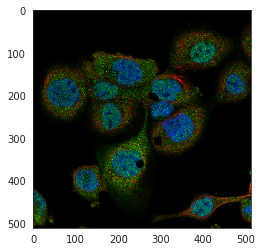

In [31]:
path = np.random.choice(corrupted[:100])

url_template = 'https://v18.proteinatlas.org/images/{}/{}.jpg'
name = os.path.basename(path).split('_')
image_sub_id = name[0]
image_id = '.'.join('_'.join(name[1:]).split('.')[:-1])

print(url_template.format(image_sub_id, image_id))
plt.imshow(cv2.imread(path))

In [ ]:
template = '../data/train_shrinked/*_blue_red_green.png'

corrupted = list()
for path in tqdm(glob(template)):
    image = cv2.imread(path)
    if not (image[..., 0] != image[..., 1]).sum():
        corrupted.append(path)

  3%|▎         | 2934/96730 [00:48<25:48, 60.58it/s]

In [27]:
len(corrupted)

3745

In [236]:
for path in tqdm(corrupted):
    if os.path.isfile(path):
        os.remove(path)

100%|██████████| 7713/7713 [00:00<00:00, 17174.43it/s]


In [171]:
for path in tqdm(corrupted):
    if os.path.isfile(path):
        os.remove(path)
    path = 'blue_red_green'.join(path.split('yellow'))
    if os.path.isfile(path):
        os.remove(path)

100%|██████████| 224/224 [00:00<00:00, 7709.17it/s]


In [169]:
corrupted[:10]

['../data/train_full_size/46491_701_B9_2_yellow.png',
 '../data/train_full_size/40401_418_D11_1_yellow.png',
 '../data/train_full_size/43840_522_E11_1_yellow.png',
 '../data/train_full_size/28700_264_C10_2_yellow.png',
 '../data/train_full_size/70604_1367_B10_3_yellow.png',
 '../data/train_full_size/34591_428_C5_1_yellow.png',
 '../data/train_full_size/46388_871_C6_2_yellow.png',
 '../data/train_full_size/39050_436_E12_5_yellow.png',
 '../data/train_full_size/46824_1381_F4_2_yellow.png',
 '../data/train_full_size/21556_535_B12_1_yellow.png']

In [64]:
key = '38715_435_A9_5_blue_red_green'
df.query('names==@key').values

array([['supported',
        'http://v18.proteinatlas.org/images/38715/435_A9_5_blue_red_green.jpg',
        'nucleus|vesicles|cytosol', 'ENSG00000110046',
        '38715_435_A9_5_blue_red_green',
        '../data/external_data_rgb/38715_435_A9_5_blue_red_green.png']],
      dtype=object)

# Shrink images

In [5]:
ids = config.labels.Id.values

In [6]:
colours = ['blue_red_green', 'yellow']

shrinked_template = '../data/train_shrinked/{}'
template = '../data/train_full_size/*{}.png'

for colour in colours:
    for path in tqdm(glob(template.format(colour))):
        shrinked_path = shrinked_template.format(os.path.basename(path))
        if os.path.isfile(shrinked_path):
            continue
        idx = os.path.basename(path).split('_' + colour)[0]
        if idx in ids:
            image = cv2.imread(path) if colour == 'blue_red_green' else cv2.imread(path, 0)
            image = cv2.resize(image, (config.PARAMS['SHRINKED_SIDE'], config.PARAMS['SHRINKED_SIDE']))
            cv2.imwrite(shrinked_path, image)


100%|██████████| 113235/113235 [28:24<00:00, 66.43it/s]


In [6]:
colours = ['blue_red_green', 'yellow']

shrinked_template = '../data/test_shrinked/{}'
template = '../data/test_full_size/*{}.png'

for colour in colours:
    for path in tqdm(glob(template.format(colour))):
        shrinked_path = shrinked_template.format(os.path.basename(path))
        if os.path.isfile(shrinked_path):
            continue
        idx = os.path.basename(path).split('_' + colour)[0]

        image = cv2.imread(path) if colour == 'blue_red_green' else cv2.imread(path, 0)
        image = cv2.resize(image, (config.PARAMS['SHRINKED_SIDE'], config.PARAMS['SHRINKED_SIDE']))
        cv2.imwrite(shrinked_path, image)


100%|██████████| 11702/11702 [02:52<00:00, 67.83it/s]
